In [35]:
# pip install -U kaleido
# pip install --upgrade scikit-learn


In [36]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.spatial import KDTree
import numpy as np

# Additional imports
import pystac_client
import xarray as xr
import pathlib
import os
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors
import rasterio

import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
from rasterio.plot import show

import matplotlib.colors as mcolors
from shapely.geometry import Point
import pandas as pd

from tqdm import tqdm

import webbrowser
from pathlib import Path
import os
import time

from itertools import compress
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from tqdm import tqdm

from shapely.geometry import box



In [37]:
directory_path_main = r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data_CVI_components\Caribbean Thesis_Results\Validation\Hazard" 

## Now We do the Clustering
#### Remember to save the upper limits of each to a CSV

In [38]:
# Read the CSV file into a DataFrame
circle_center_df = pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data_CVI_components\Hazard\Present\Caribbean_Hazards_including_TC.csv")
circle_center_df



transect_id country_id      continent        country_name  \
0       BOX_116_353_2        COL  South America            Colombia   
1       BOX_116_353_3        COL  South America            Colombia   
2       BOX_116_353_4        COL  South America            Colombia   
3       BOX_116_353_5        COL  South America            Colombia   
4       BOX_116_353_6        COL  South America            Colombia   
...               ...        ...            ...                 ...   
37504  BOX_139_002_61        DOM  North America  Dominican Republic   
37505  BOX_139_002_62        DOM  North America  Dominican Republic   
37506  BOX_139_002_63        DOM  North America  Dominican Republic   
37507  BOX_139_002_64        DOM  North America  Dominican Republic   
37508  BOX_139_002_65        DOM  North America  Dominican Republic   

                                        geometry  ESL_100yrRP  EWH_100yrRP  \
0            POINT (-71.8798045985 12.250683718)     0.946771     4.455543   
1        POINT (-71.87698143850001 12.247308305)     0.946771     4.455543   
2           POINT (-71.8756318462 12.2431443263)     0.946771     4.455543   
3           POINT (-71.8752334021 12.2387721729)     0.946771     4.455543   
4           POINT (-71.8748349513 12.2343999454)     0.946771     4.455543   
...                                          ...          ...          ...   
37504       POINT (-71.6681862112 17.9652589019)     1.246410     6.922152   
37505       POINT (-71.6662284163 17.9614175026)     1.246410     6.922152   
37506        POINT (-71.664582619 17.9574419454)     1.246410     6.922152   
37507  POINT (-71.6629367897 17.953466310899998)     1.246410     6.922152   
37508  POINT (-71.6612909283 17.949490598900002)     1.246410     6.922152   

       Land_Subsidence_2010  Shoreline_Change_Rate_PC  \
0                       NaN                -16.441771   
1                       NaN                  0.335379   
2                       NaN                  1.878836   
3                       NaN                  0.490707   
4                       NaN                 -0.052123   
...                     ...                       ...   
37504                   2.0                  0.288753   
37505                   2.0                  0.166001   
37506                   2.0                  0.092415   
37507                   2.0                 -0.027472   
37508                   2.0                 -0.094827   

       Cat3_Hurricane_Return_Period_PC  
0                             7.042254  
1                             7.042254  
2                             7.042254  
3                             7.042254  
4                             7.042254  
...                                ...  
37504                         6.369427  
37505                         6.369427  
37506                         6.369427  
37507                         6.369427  
37508                         6.369427  

[37509 rows x 10 columns]

In [39]:

# Identify the correct geometry column (replace 'geometry_column_name' with the actual column name)
geometry_column_name = 'geometry'
circle_center_df['x'] = circle_center_df[geometry_column_name].apply(lambda point_str: float(point_str.strip('POINT ()').split()[0]))
circle_center_df['y'] = circle_center_df[geometry_column_name].apply(lambda point_str: float(point_str.strip('POINT ()').split()[1]))

circle_center_df = circle_center_df.drop(columns=[geometry_column_name])

# Create the GeoDataFrame with the correct geometry column
circle_center = gpd.GeoDataFrame(circle_center_df, geometry=gpd.points_from_xy(circle_center_df.x, circle_center_df.y))



# Slice the DataFrame to exclude 'geometry', 'x', and 'y' columns
other_columns = circle_center.iloc[:, 0:-3]

# Concatenate the 'geometry' column with the other columns
circle_center2 = gpd.GeoDataFrame(geometry=circle_center.geometry, data=other_columns)


circle_center=circle_center2
circle_center
isinstance(circle_center, gpd.GeoDataFrame)



img_lat = 18.1
img_lon = -77.3
view_width = 10

In [40]:
circle_center_storage_orig=circle_center.copy()
circle_center_storage_orig["country_name"].unique()

array(['Colombia', 'Saint Kitts and Nevis', 'Netherlands', 'France',
       'Antigua and Barbuda', 'Venezuela', 'Montserrat', 'Curacao',
       'Saint Lucia', 'Aruba', 'Barbados', 'Dominican Republic',
       'Saint Vincent and the Grenadines', 'Grenada', 'Dominica', 'Haiti',
       'Cuba', 'Jamaica', 'The Bahamas', 'Turks and Caicos Islands',
       'unknown', 'United States of America', 'Cayman Islands',
       'British Virgin Islands', 'Puerto Rico',
       'United States Virgin Islands', 'Saint Barthelemy', 'Anguilla',
       'Saint Martin'], dtype=object)

In [41]:
countries=["Jamaica","Turks and Caicos Islands","Barbados","The Bahamas","Saint Lucia"]
zoom_levels=[8,9,9.5,6.8,10]
for zoom,country in zip(zoom_levels,countries):
    print(zoom,country)

8 Jamaica
9 Turks and Caicos Islands
9.5 Barbados
6.8 The Bahamas
10 Saint Lucia


In [42]:
# len(circle_center_nans.iloc[:,0])

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.

C:\Users\rowe\AppData\Local\Temp\ipykernel_15724\3083711179.py:238: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



no points for Land_Subsidence_2010_kmeans_Turks and Caicos Islands


c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.



no points for Land_Subsidence_2010_percentile_Turks and Caicos Islands
no points for Land_Subsidence_2010_Jenkspy_Turks and Caicos Islands


c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.



no points for Land_Subsidence_2010_kmeans_Barbados


c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.



no points for Land_Subsidence_2010_percentile_Barbados
no points for Land_Subsidence_2010_Jenkspy_Barbados


c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.



no points for Land_Subsidence_2010_kmeans_Saint Lucia


c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.



no points for Land_Subsidence_2010_percentile_Saint Lucia
no points for Land_Subsidence_2010_Jenkspy_Saint Lucia


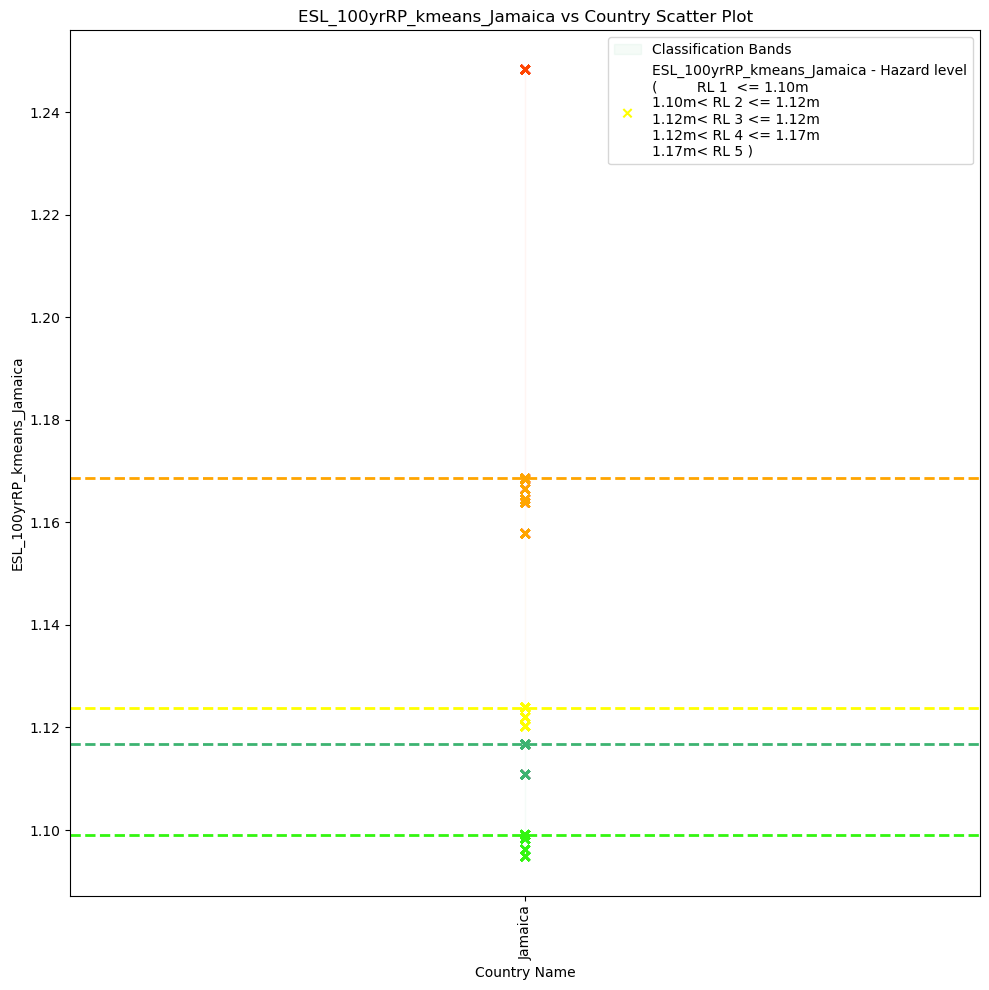

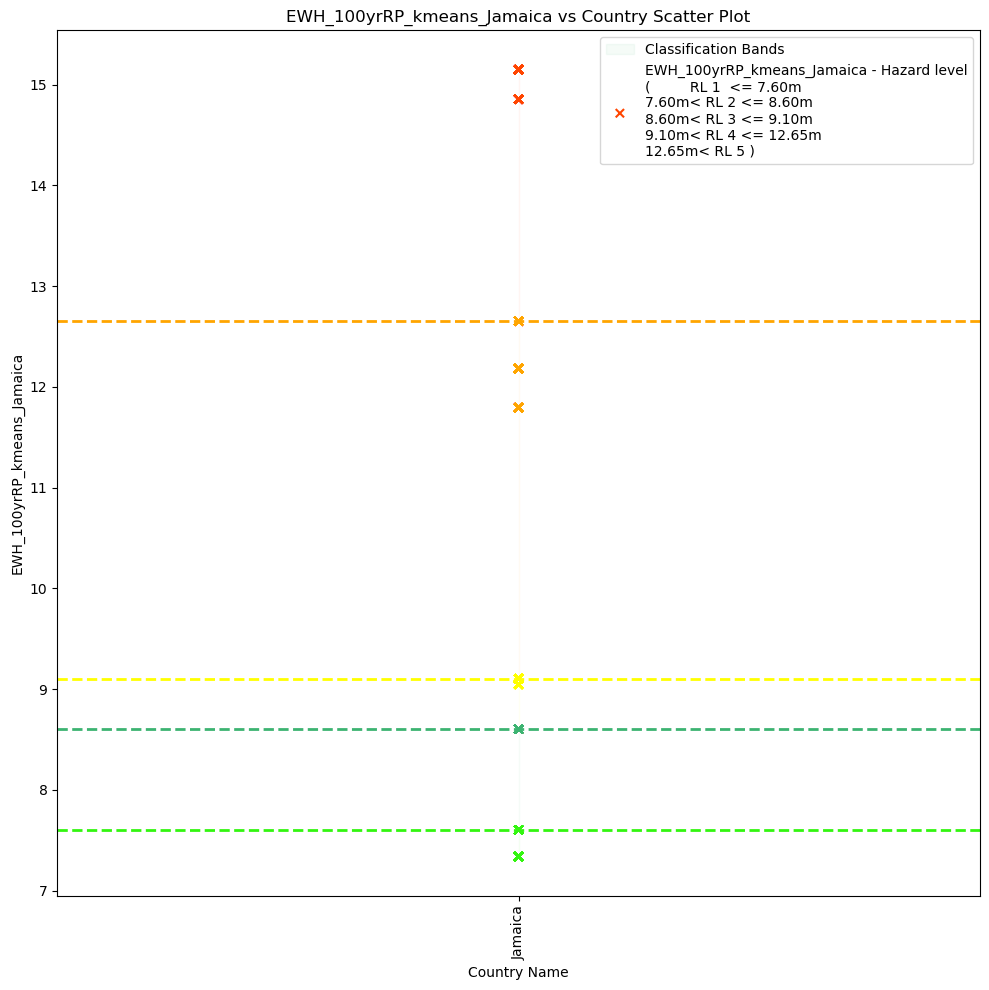

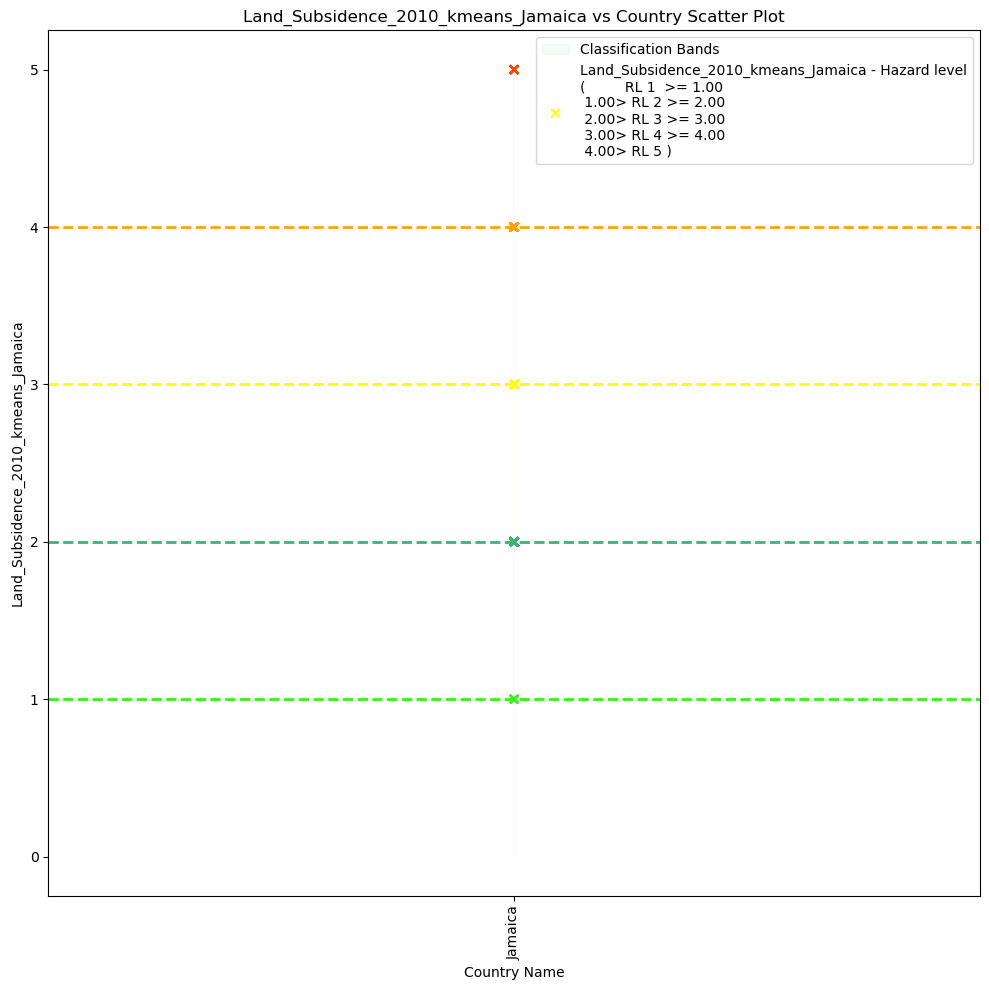

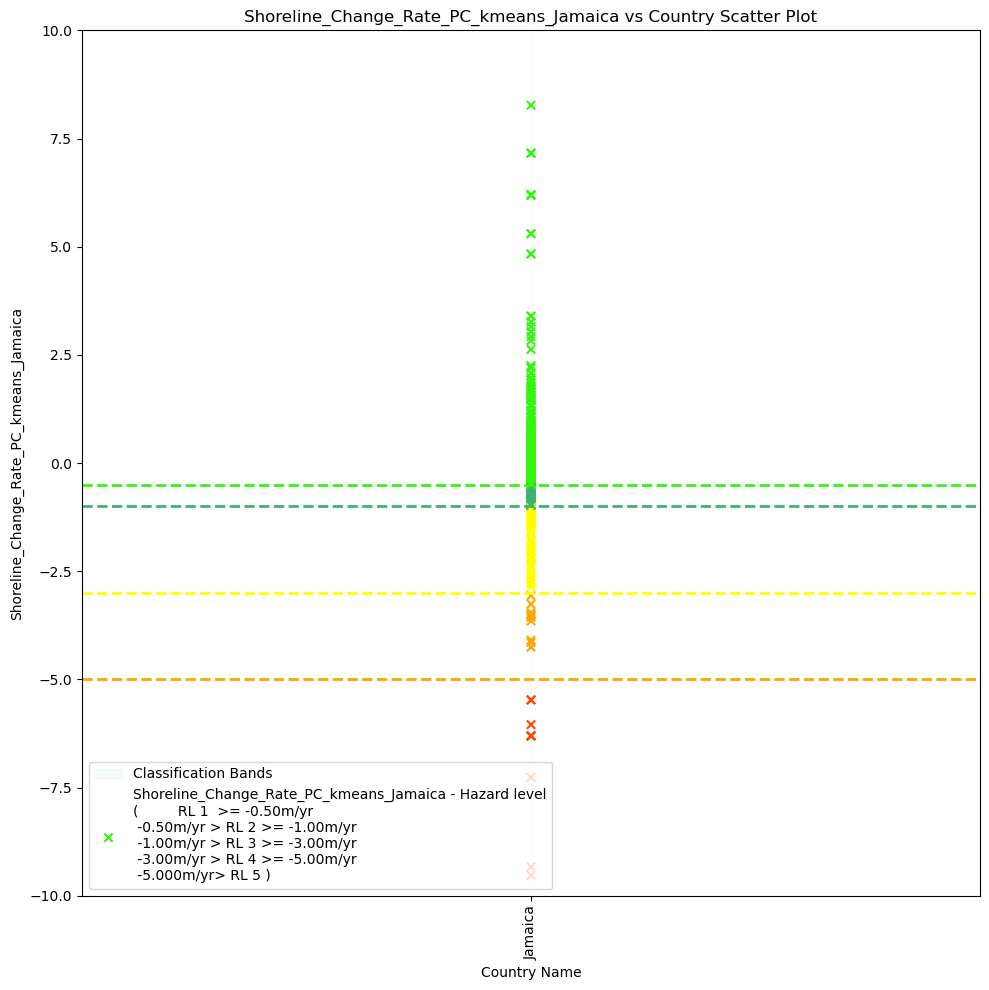

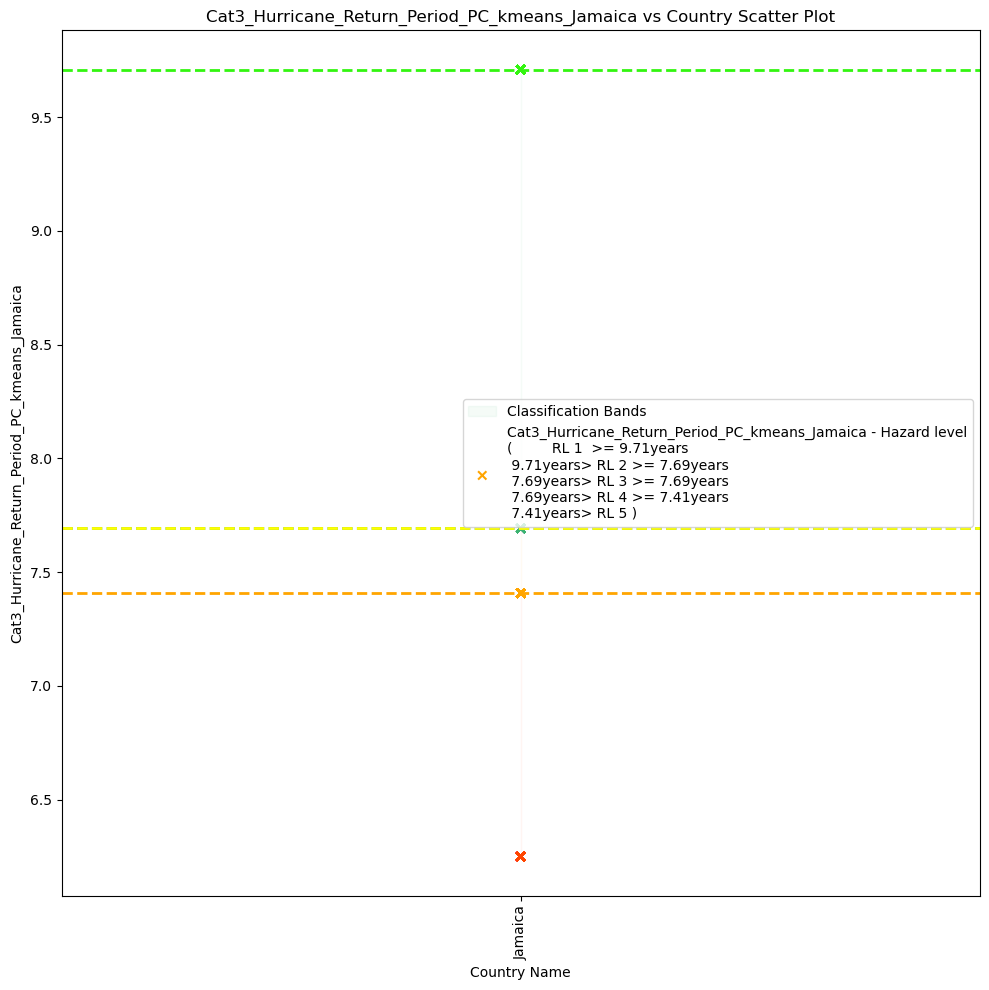

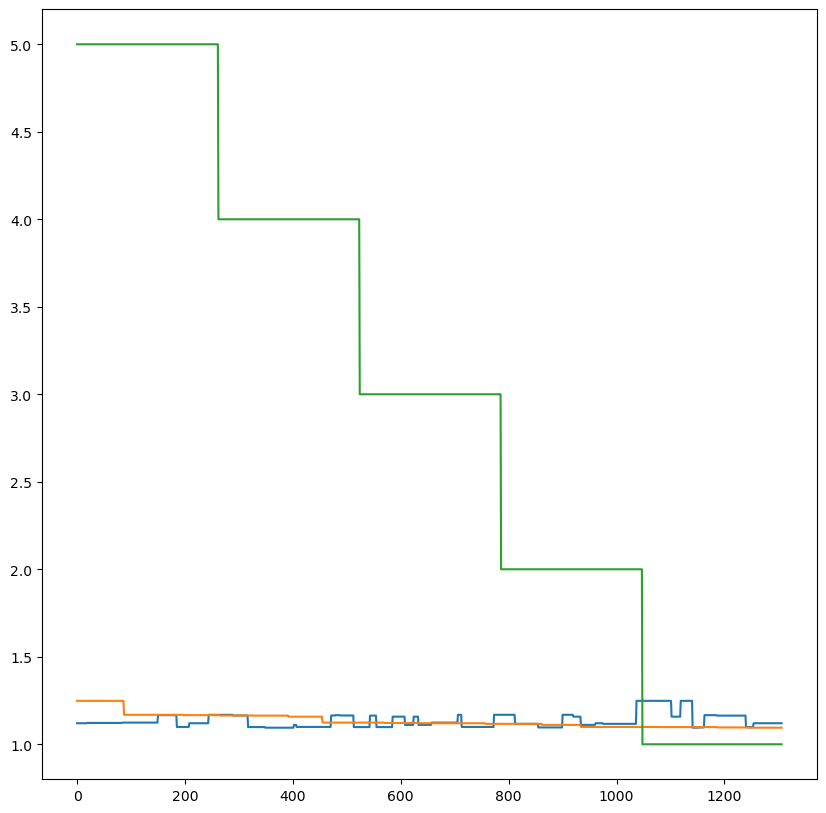

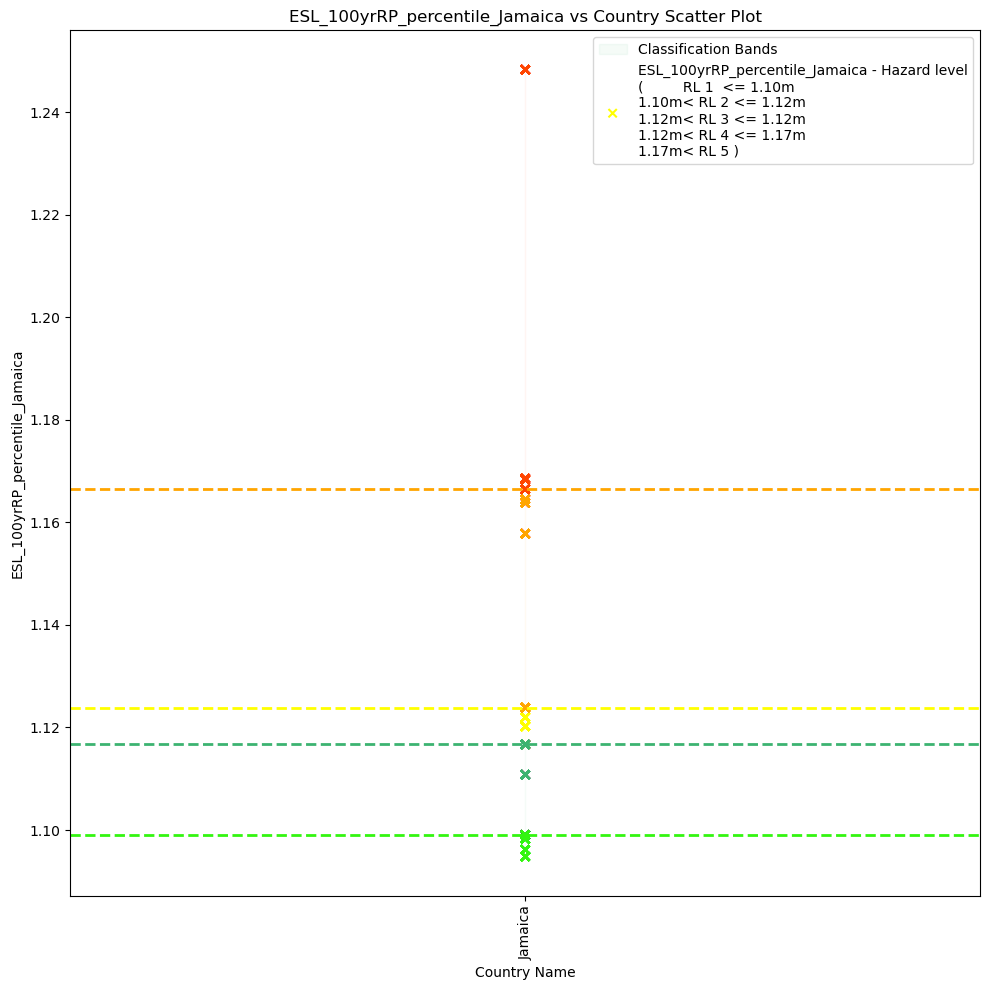

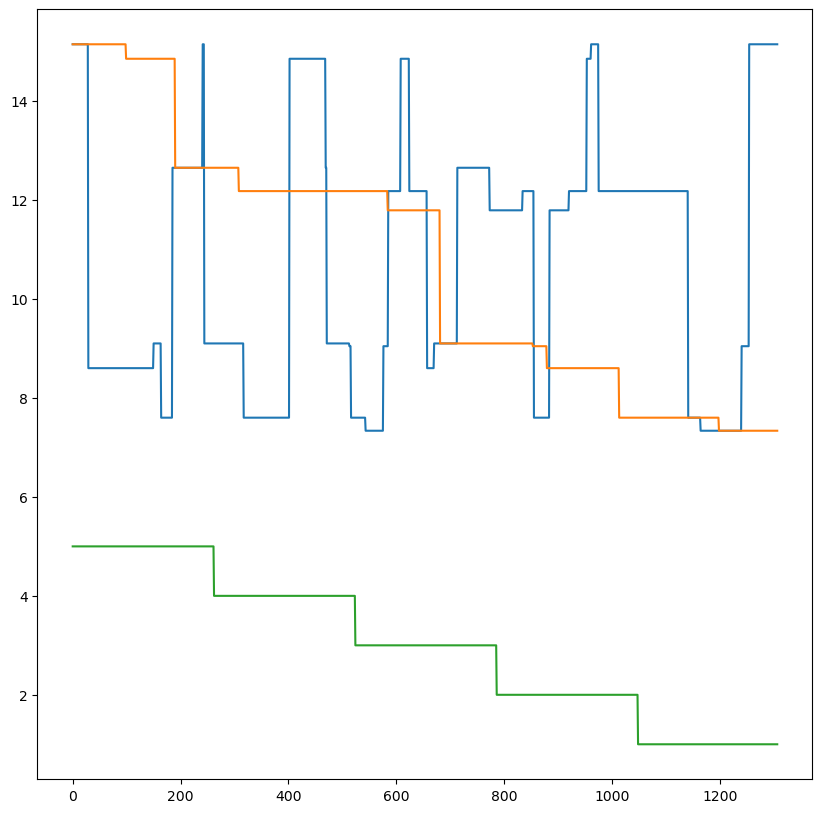

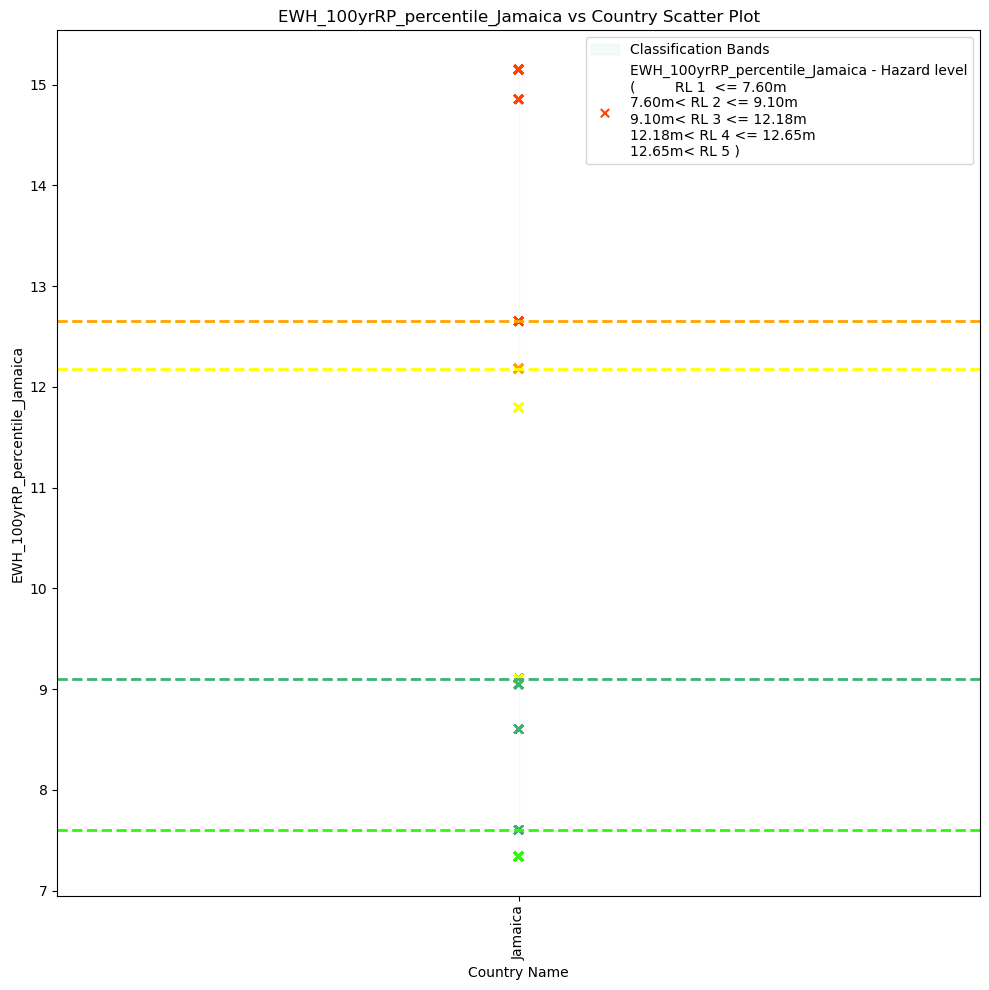

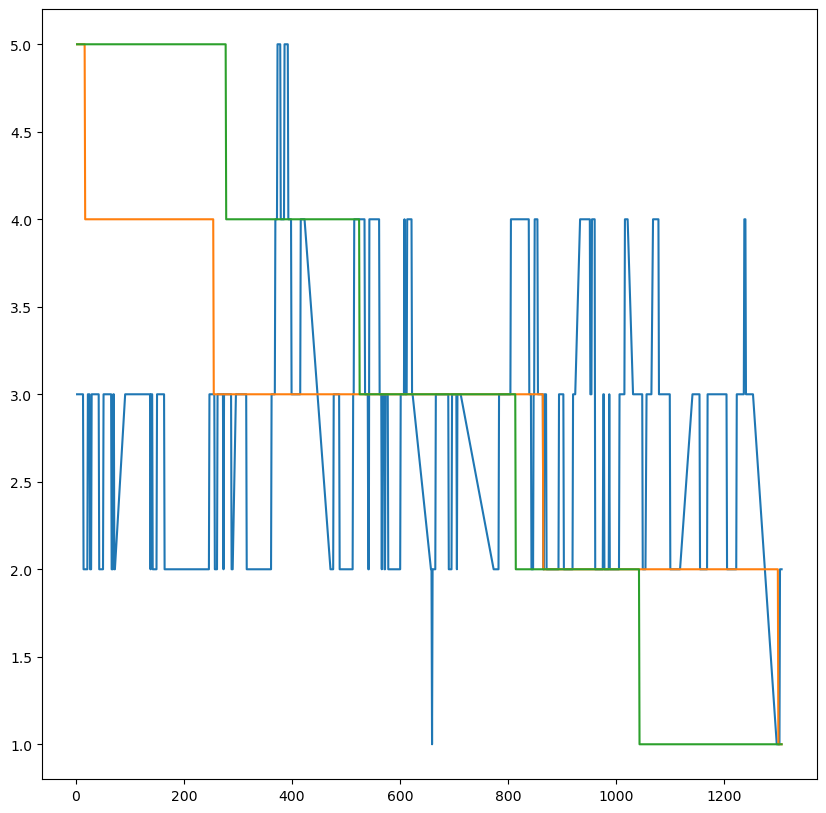

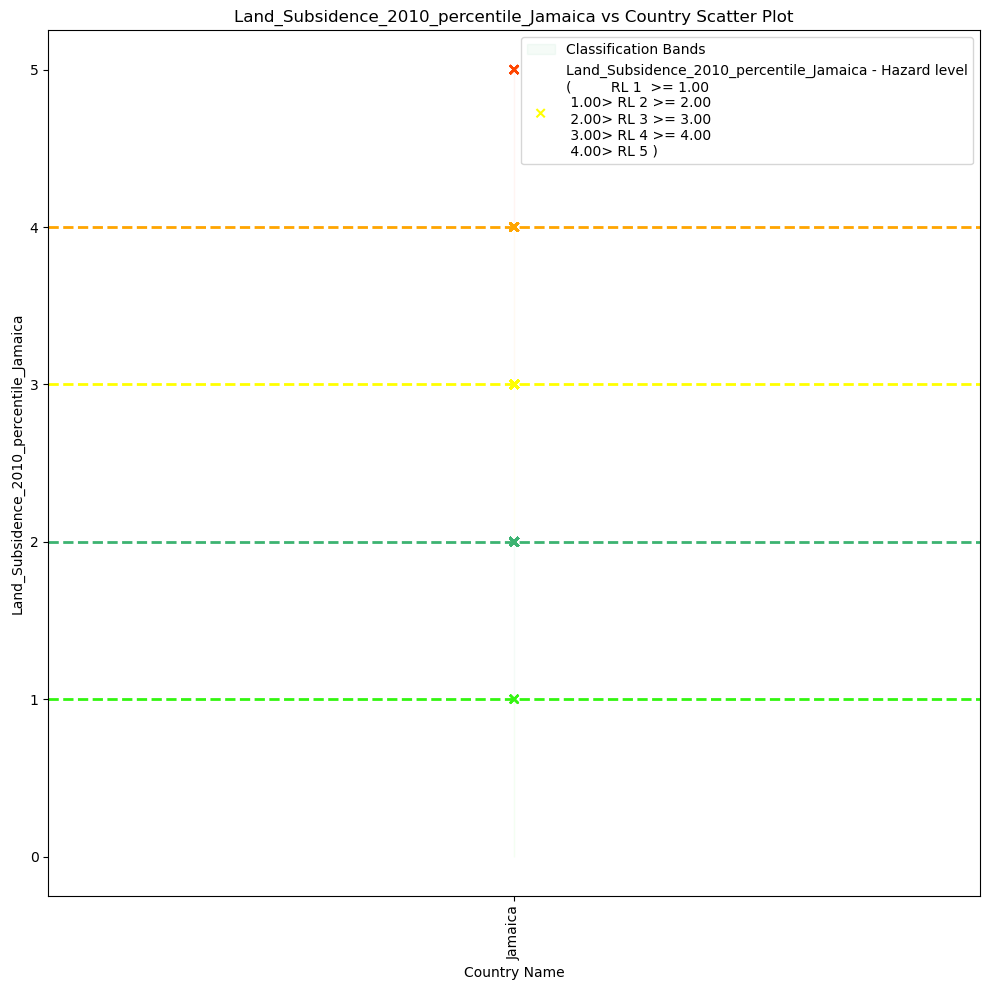

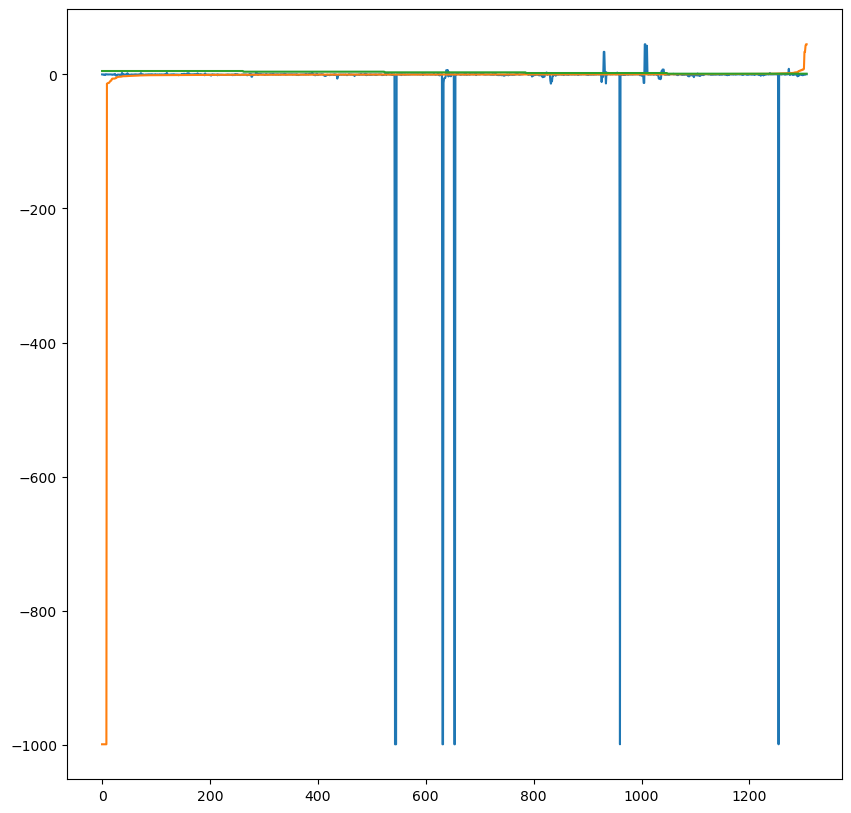

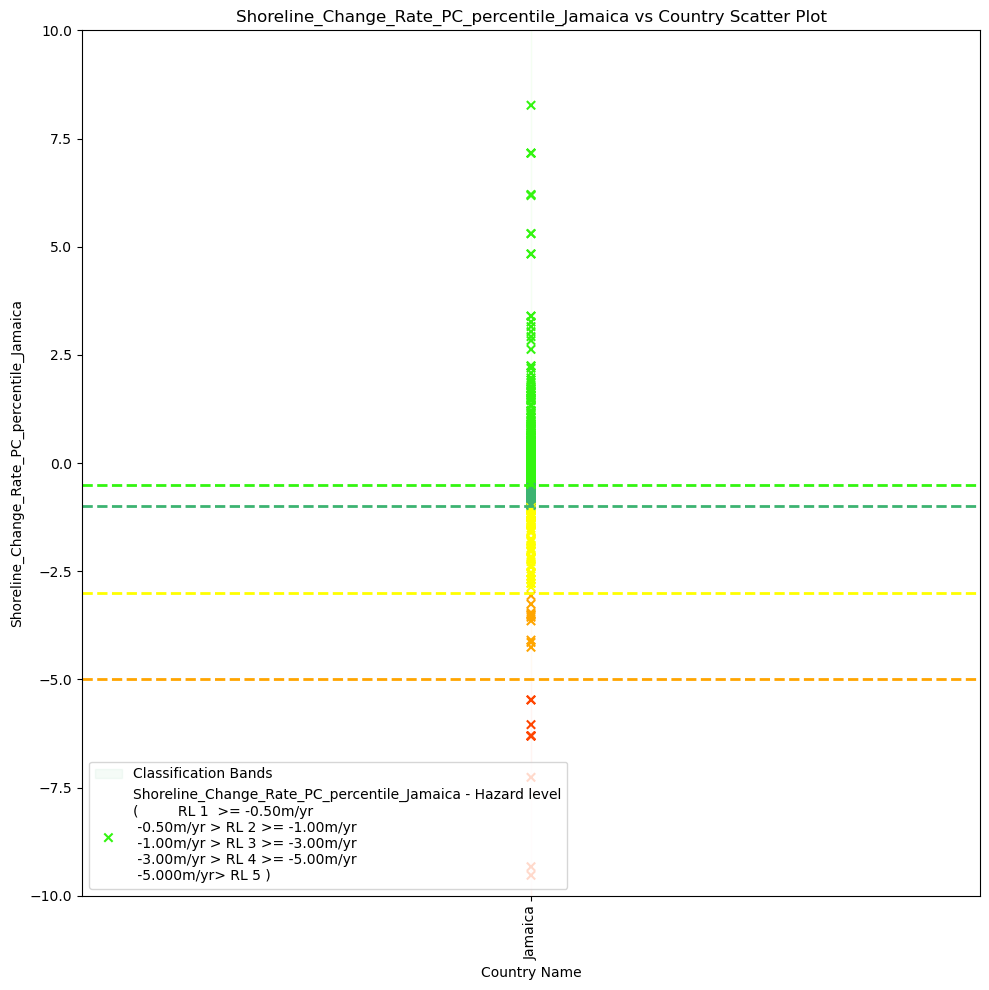

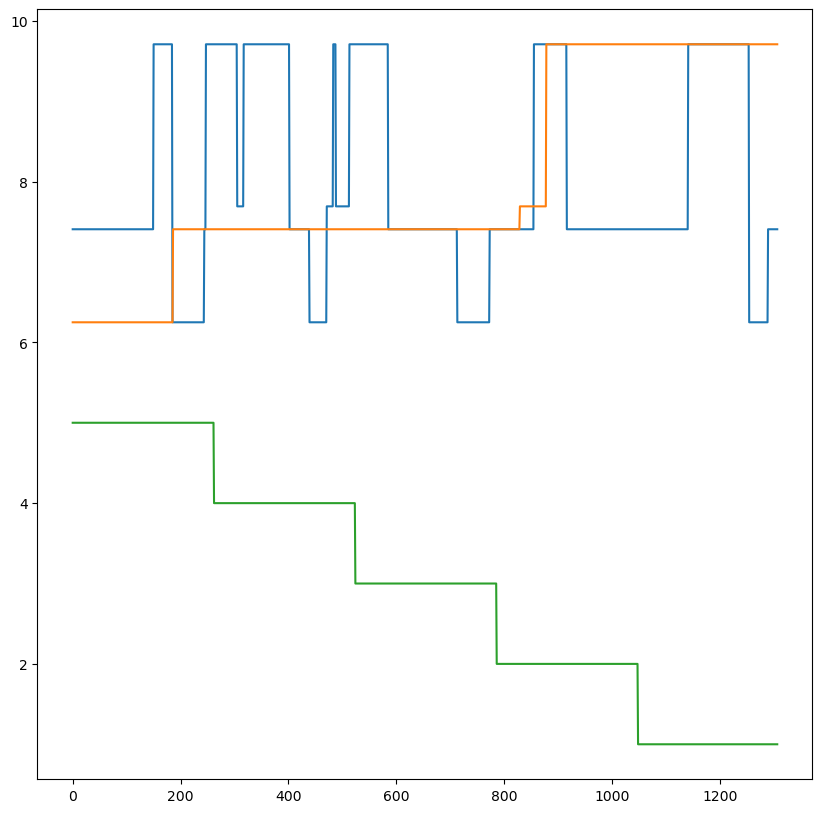

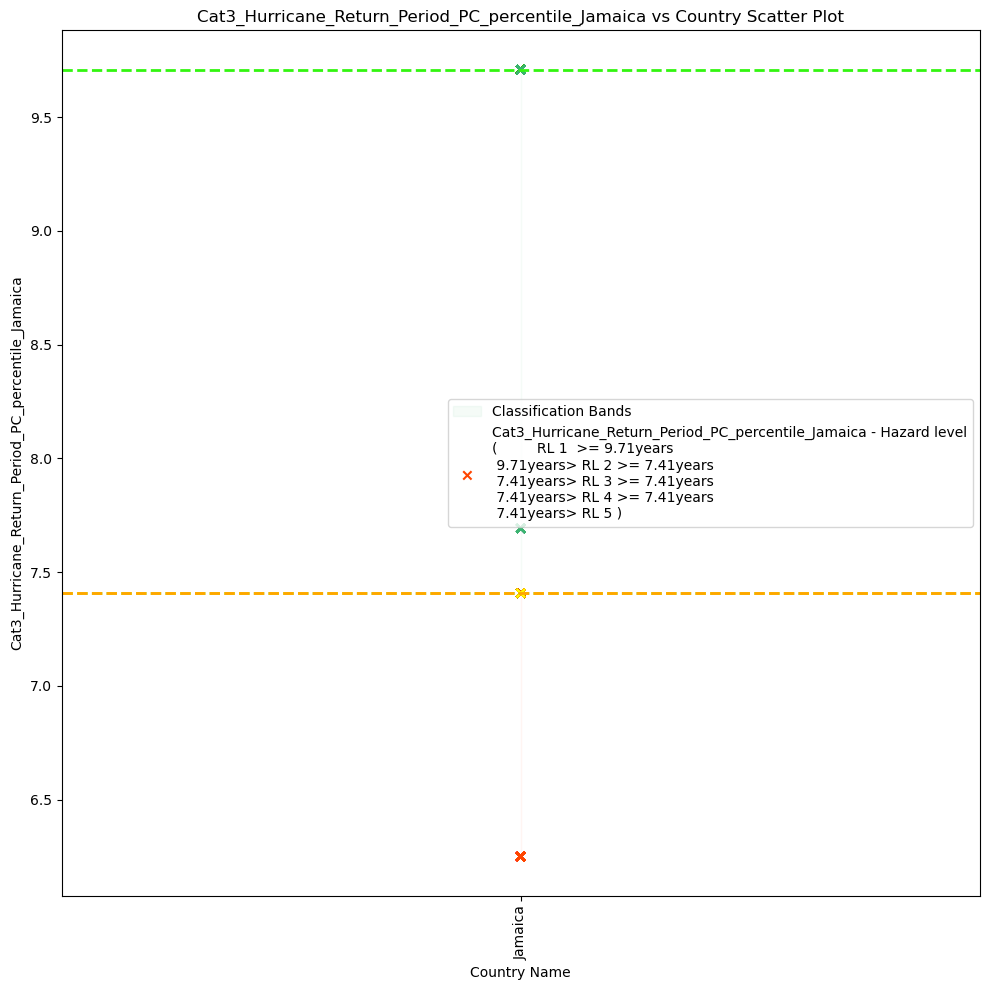

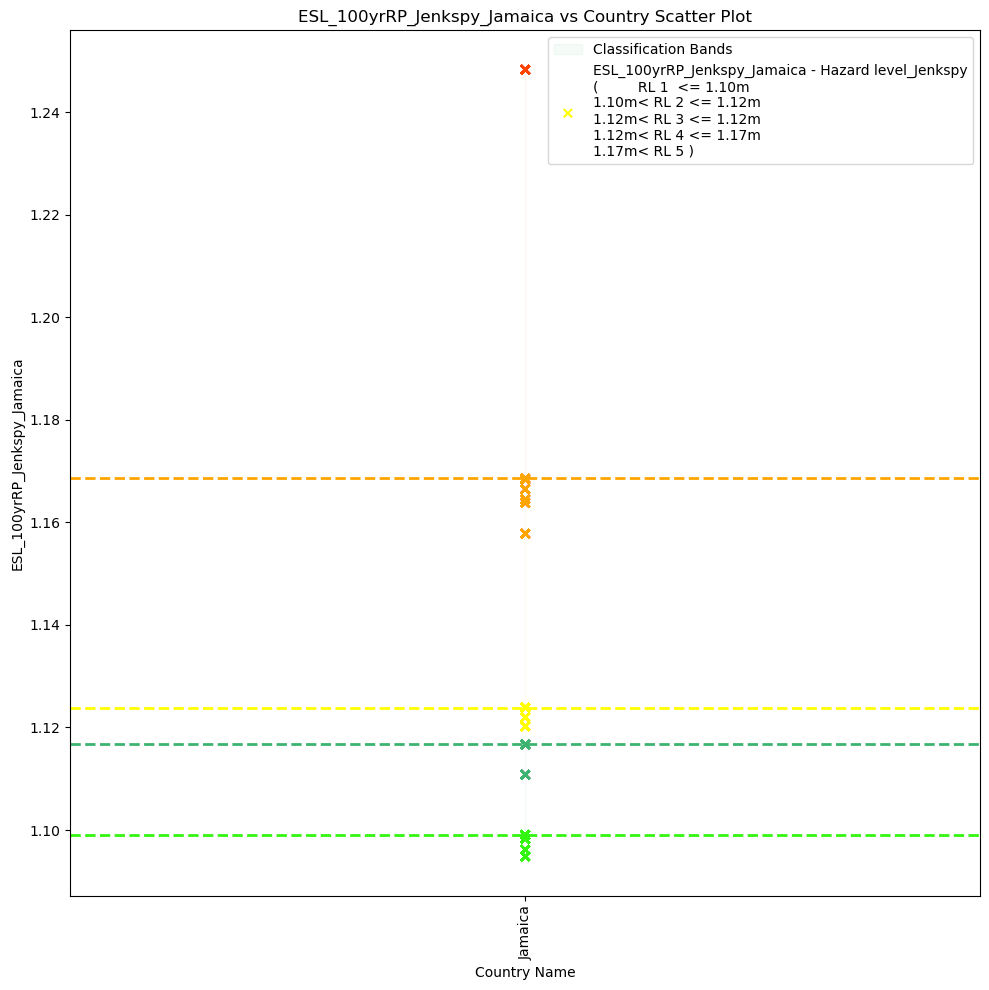

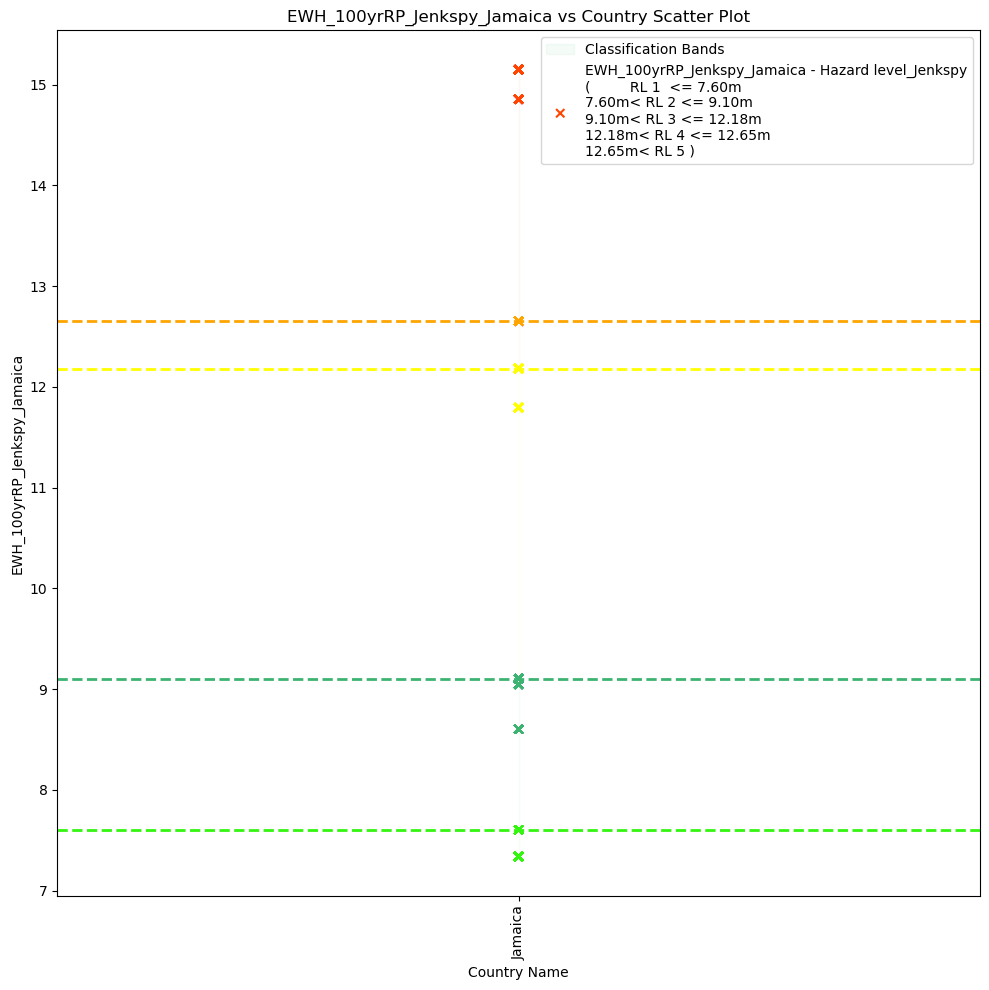

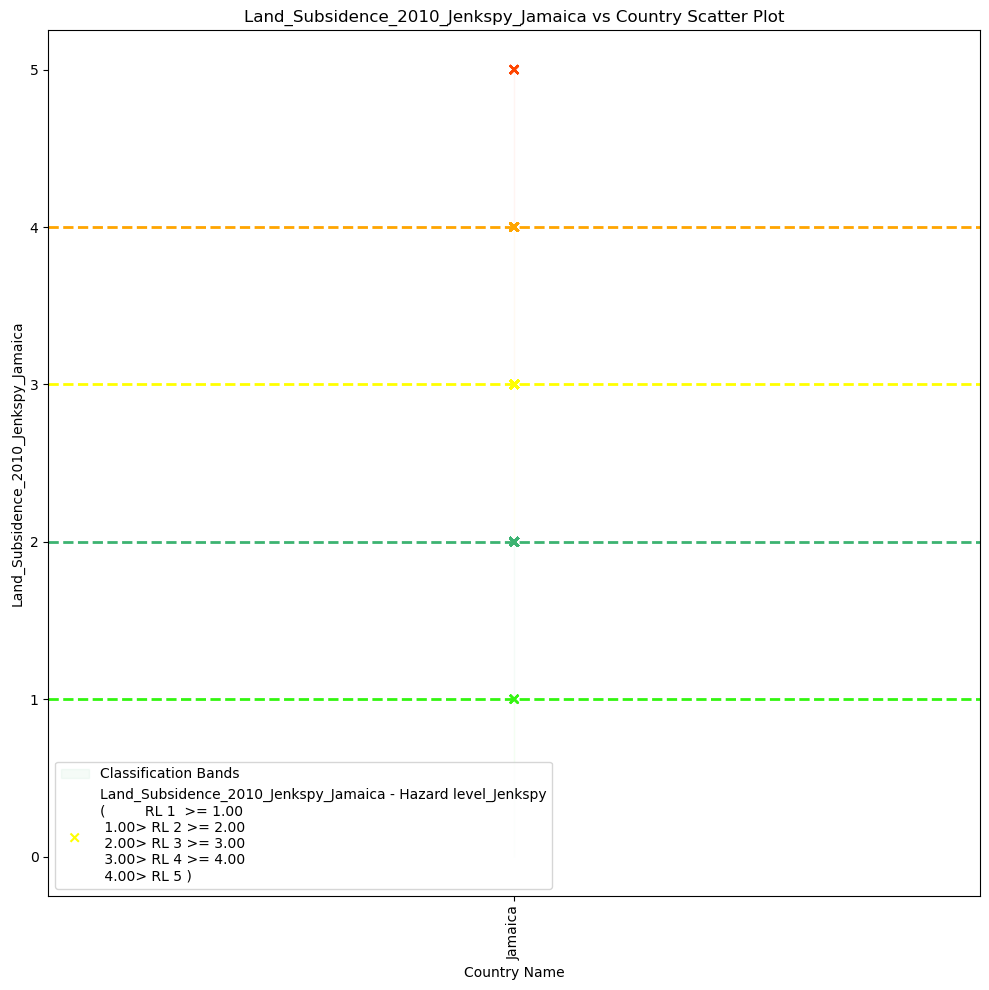

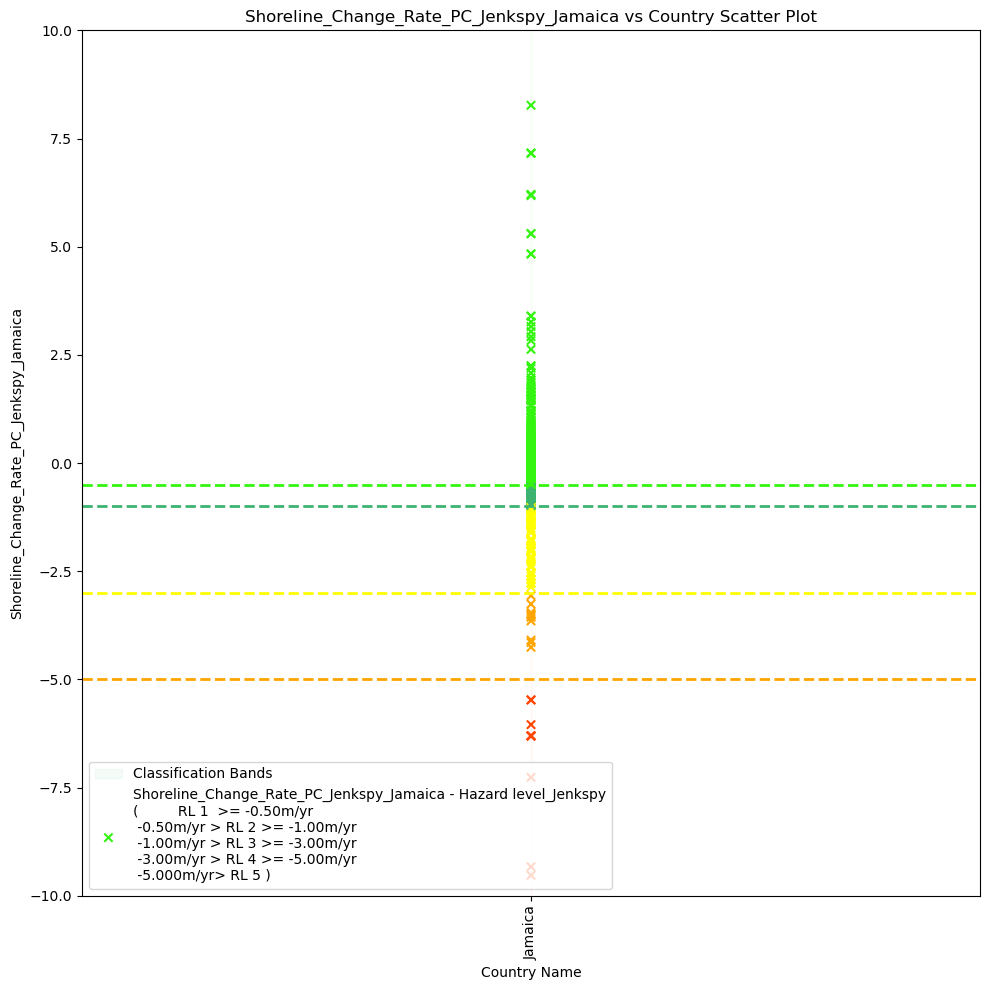

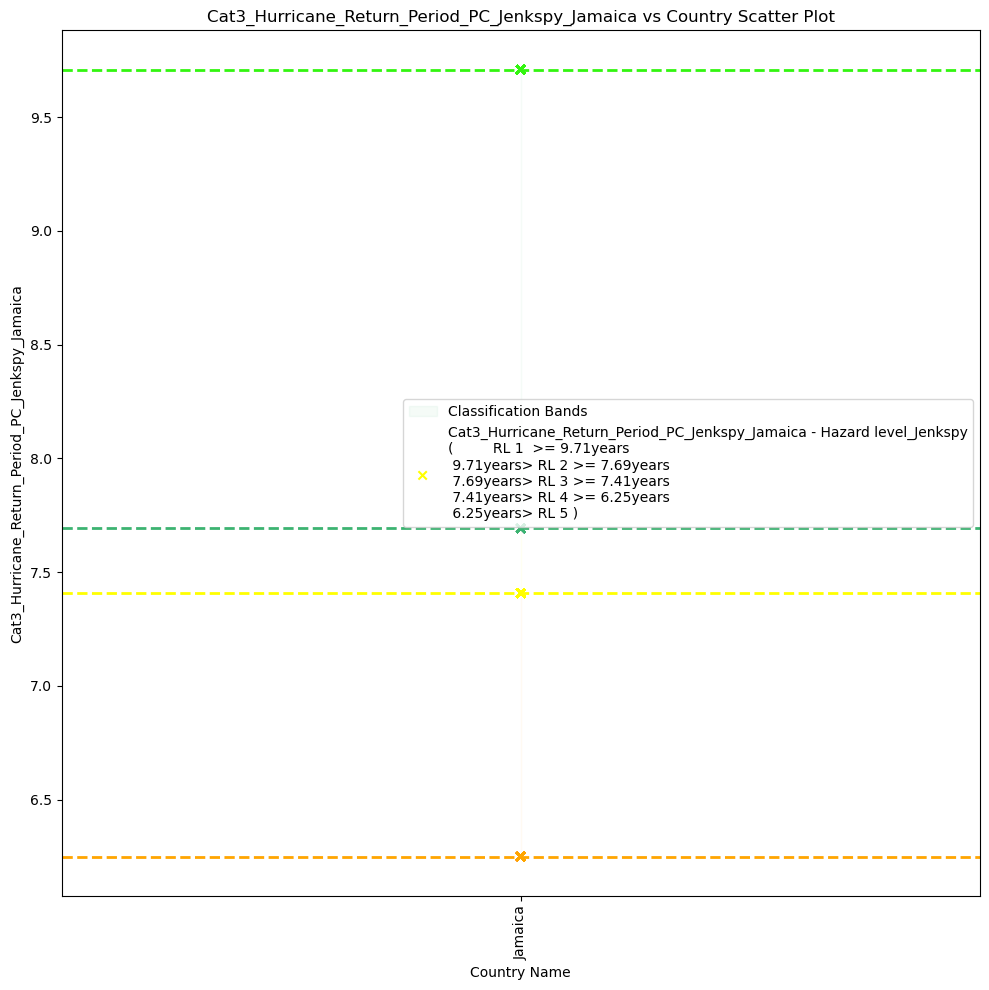

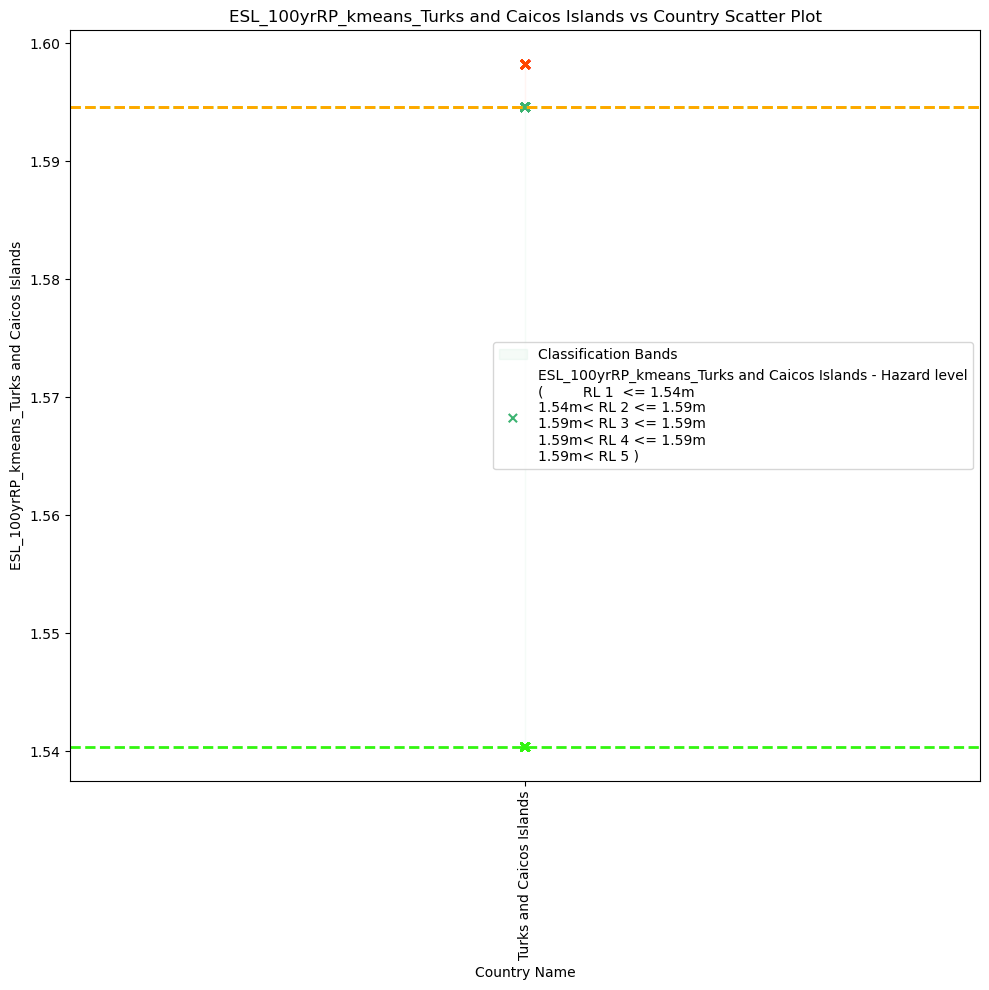

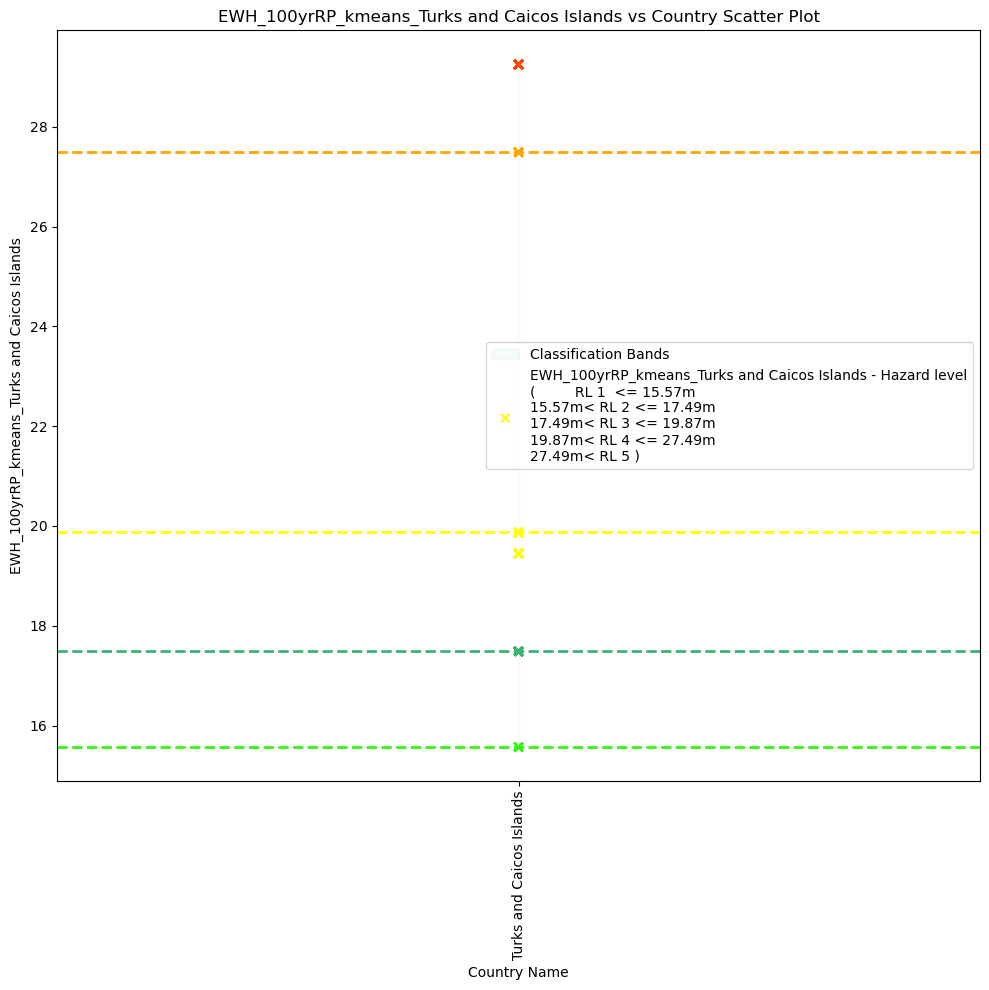

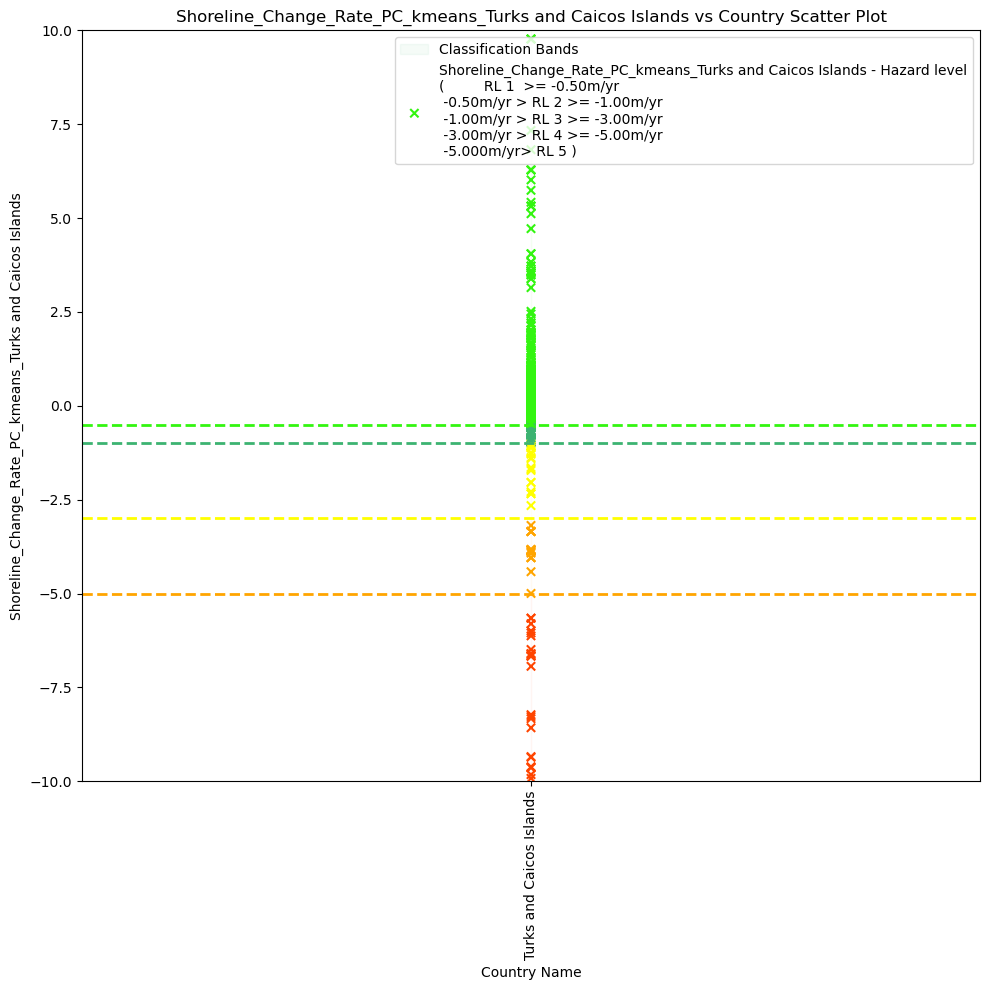

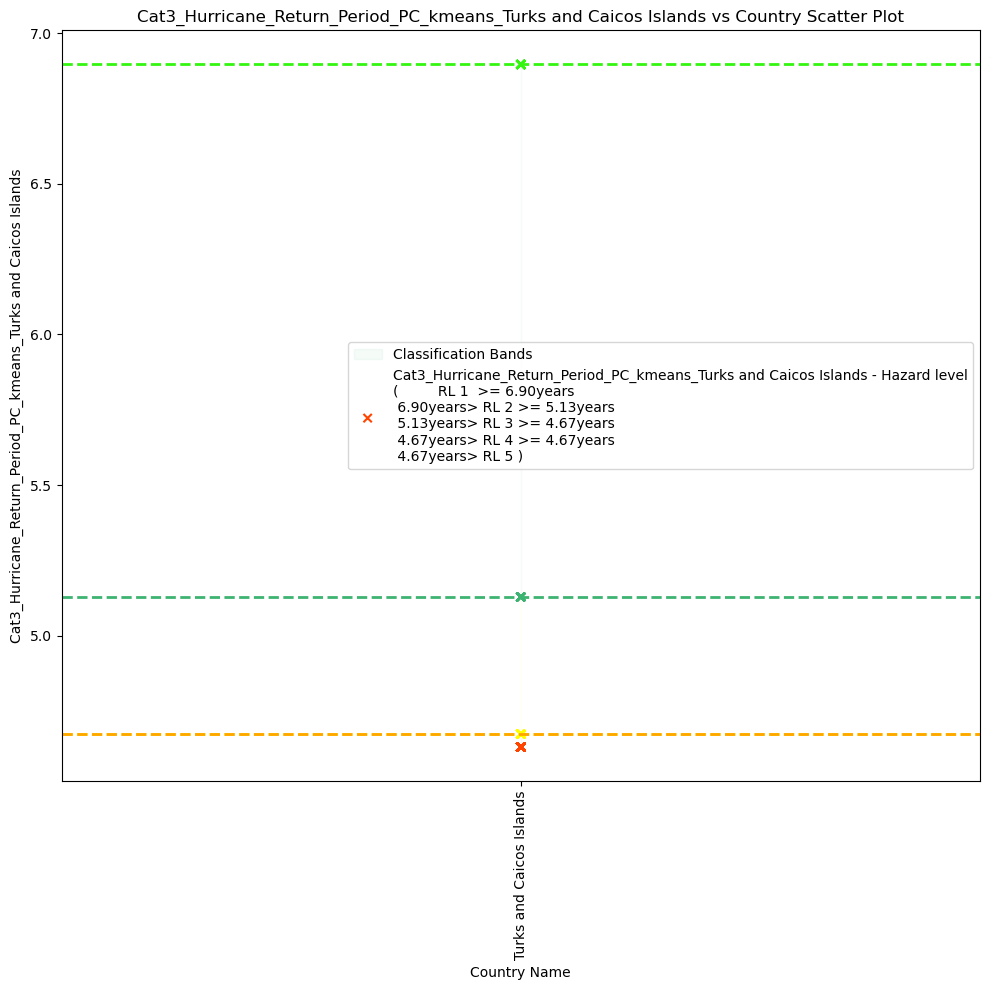

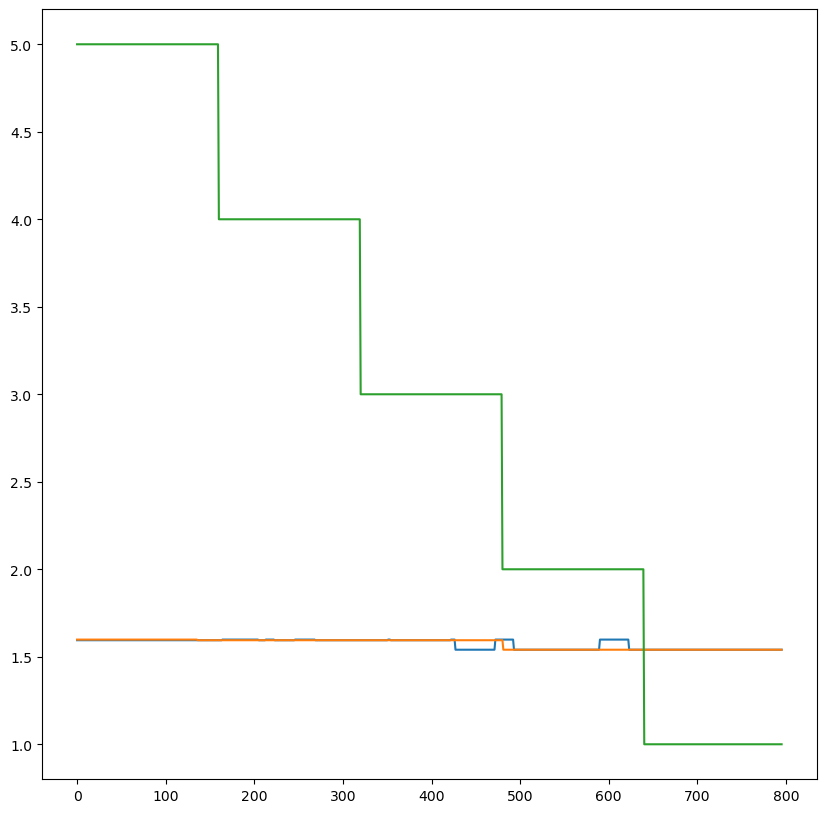

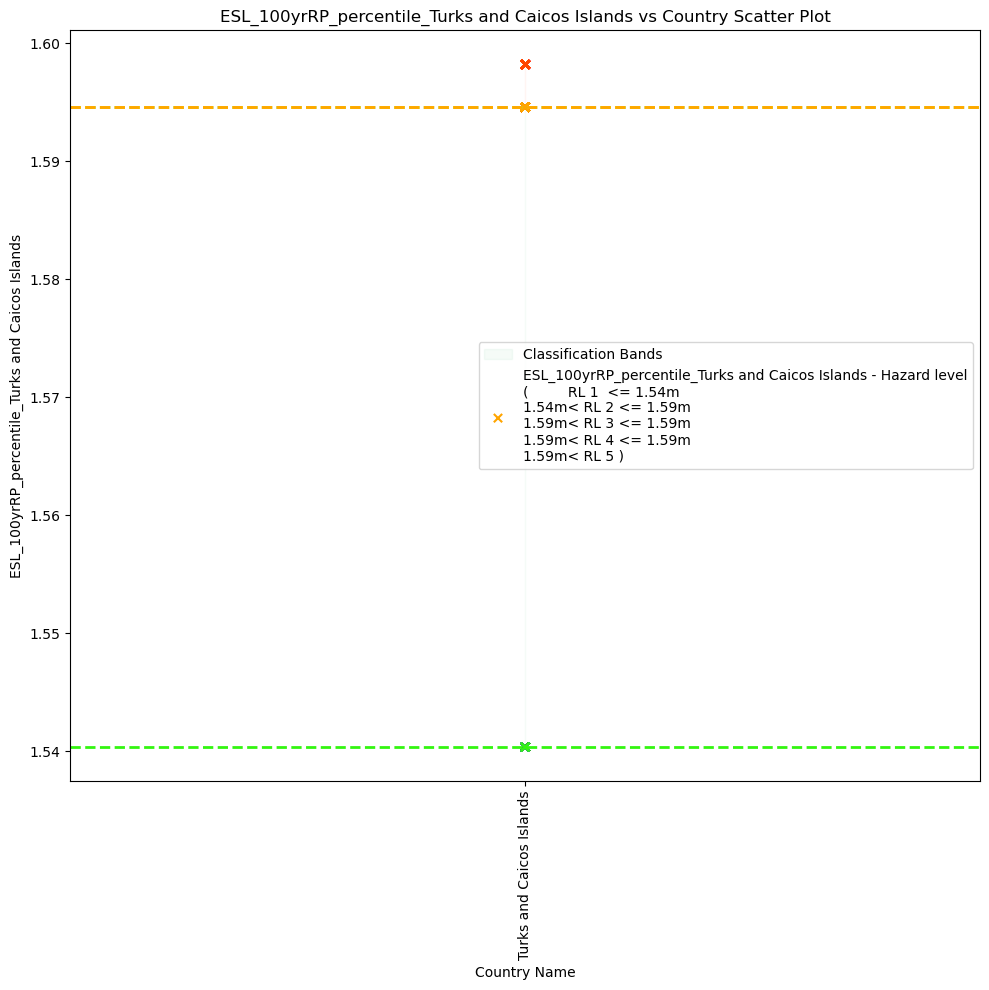

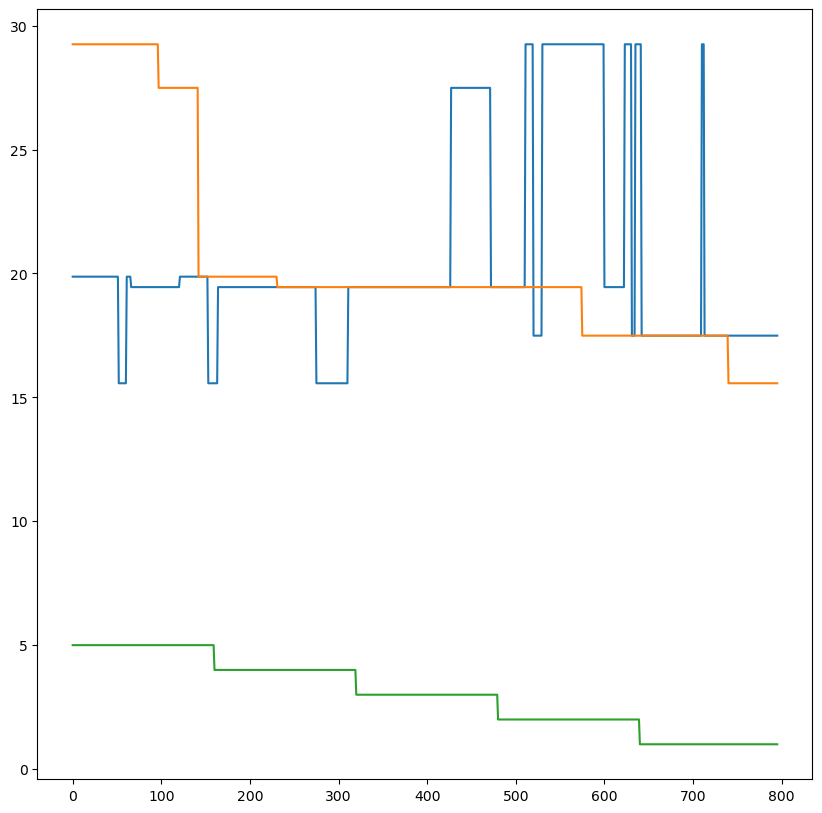

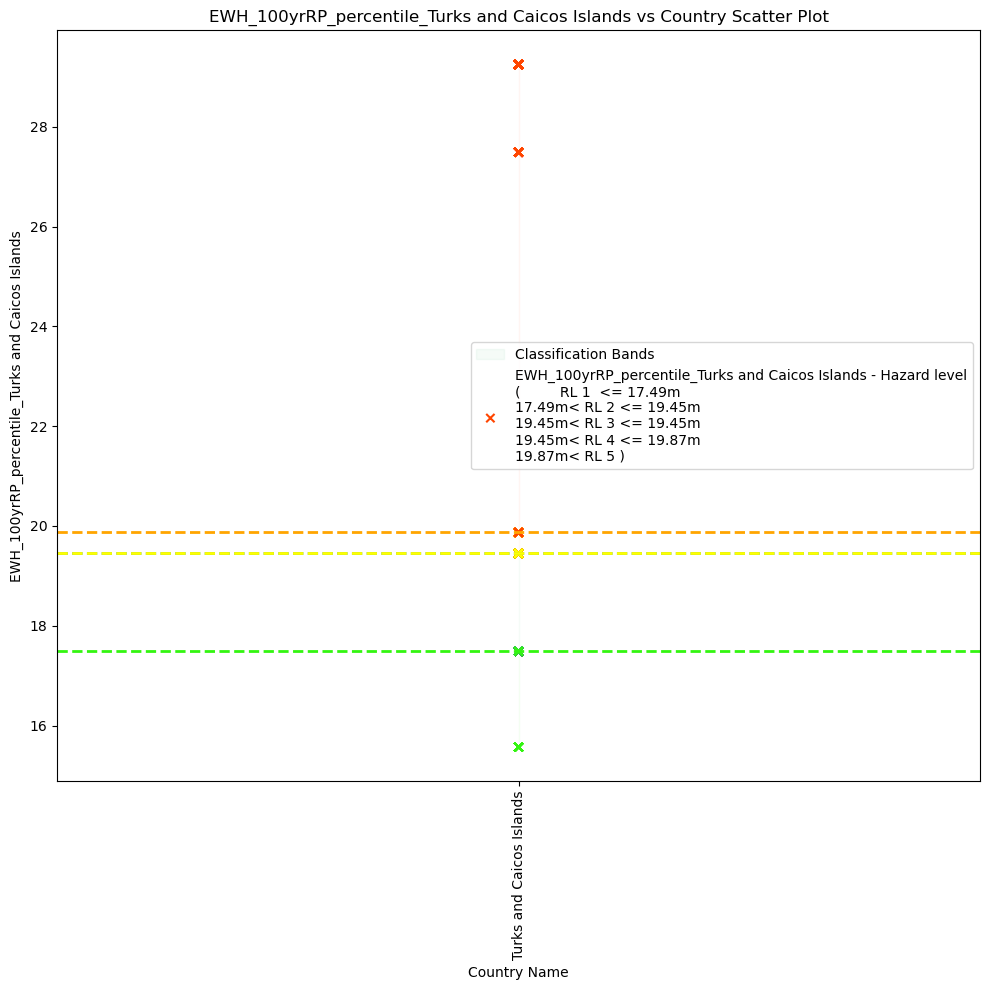

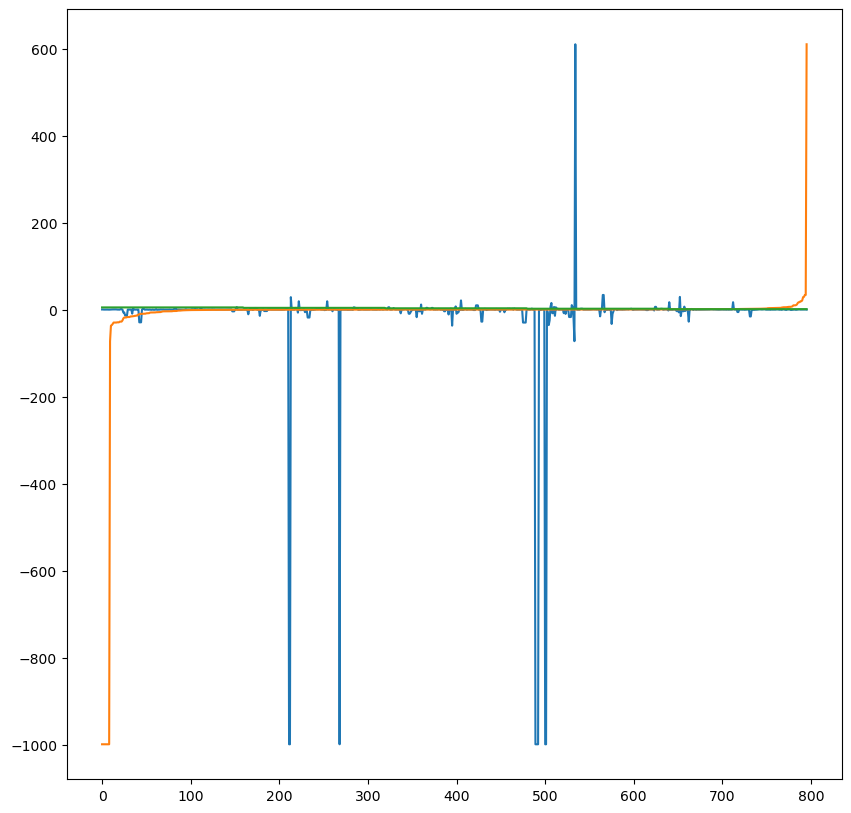

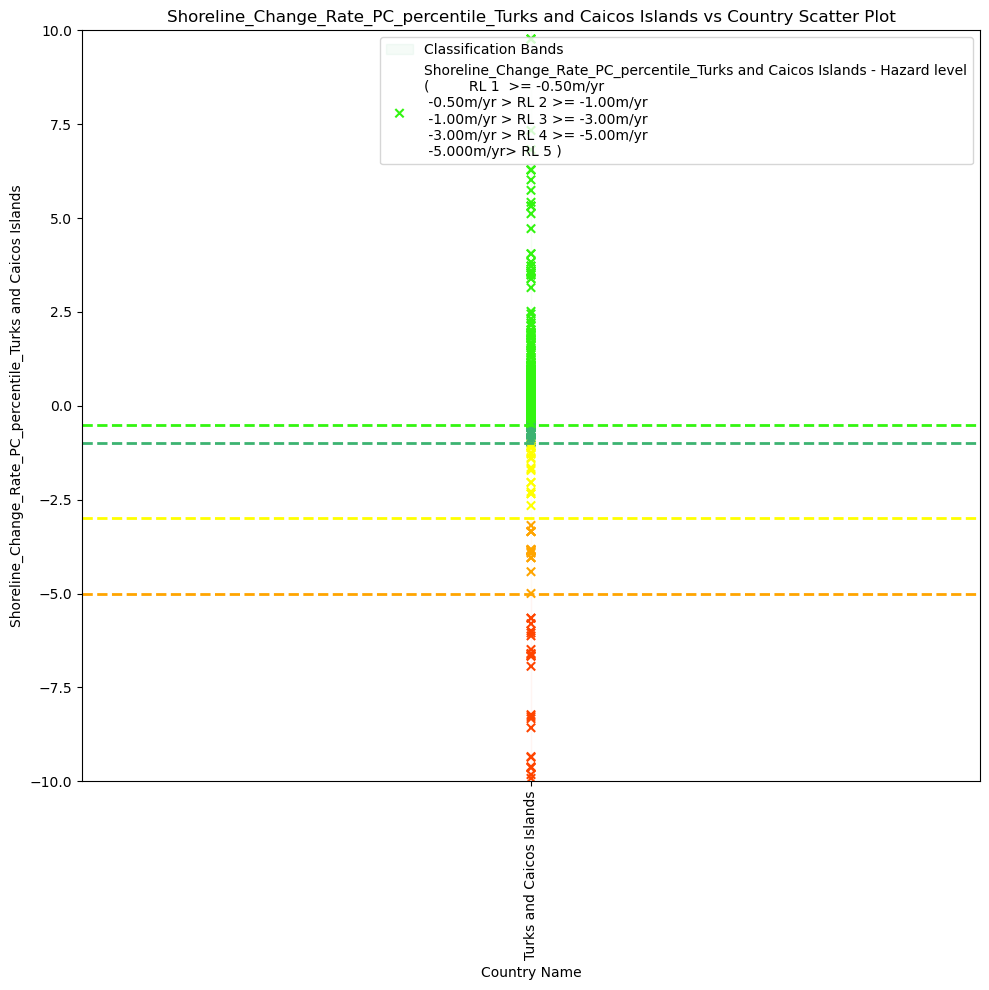

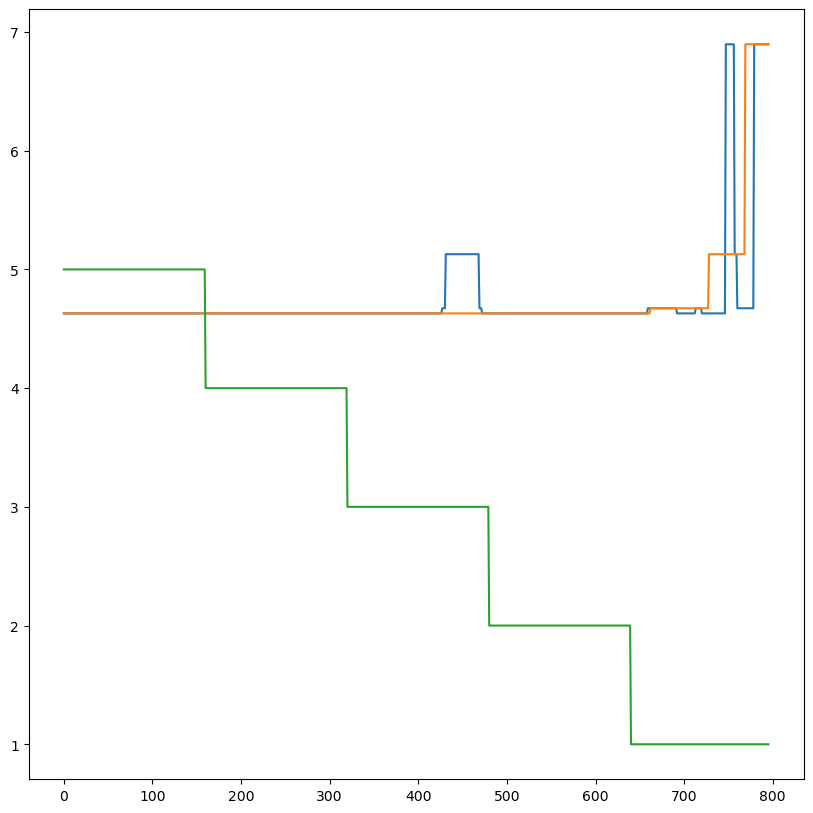

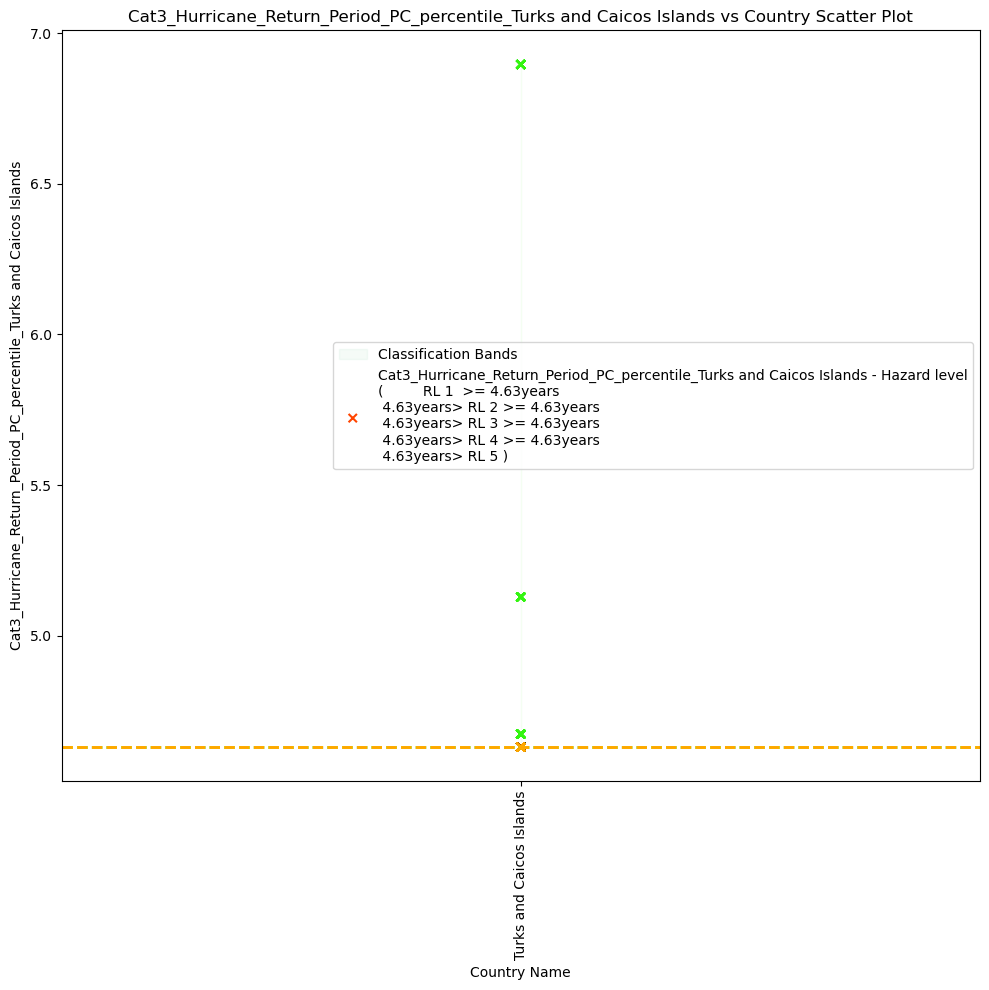

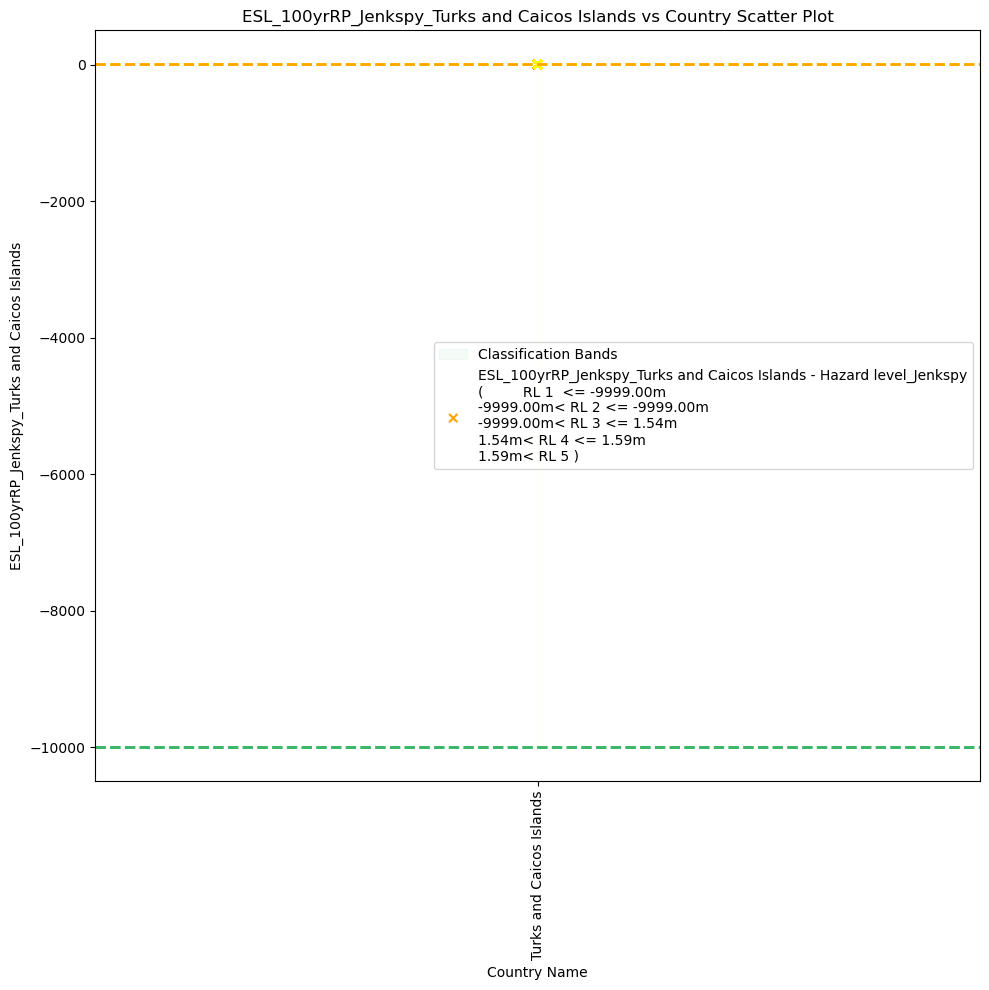

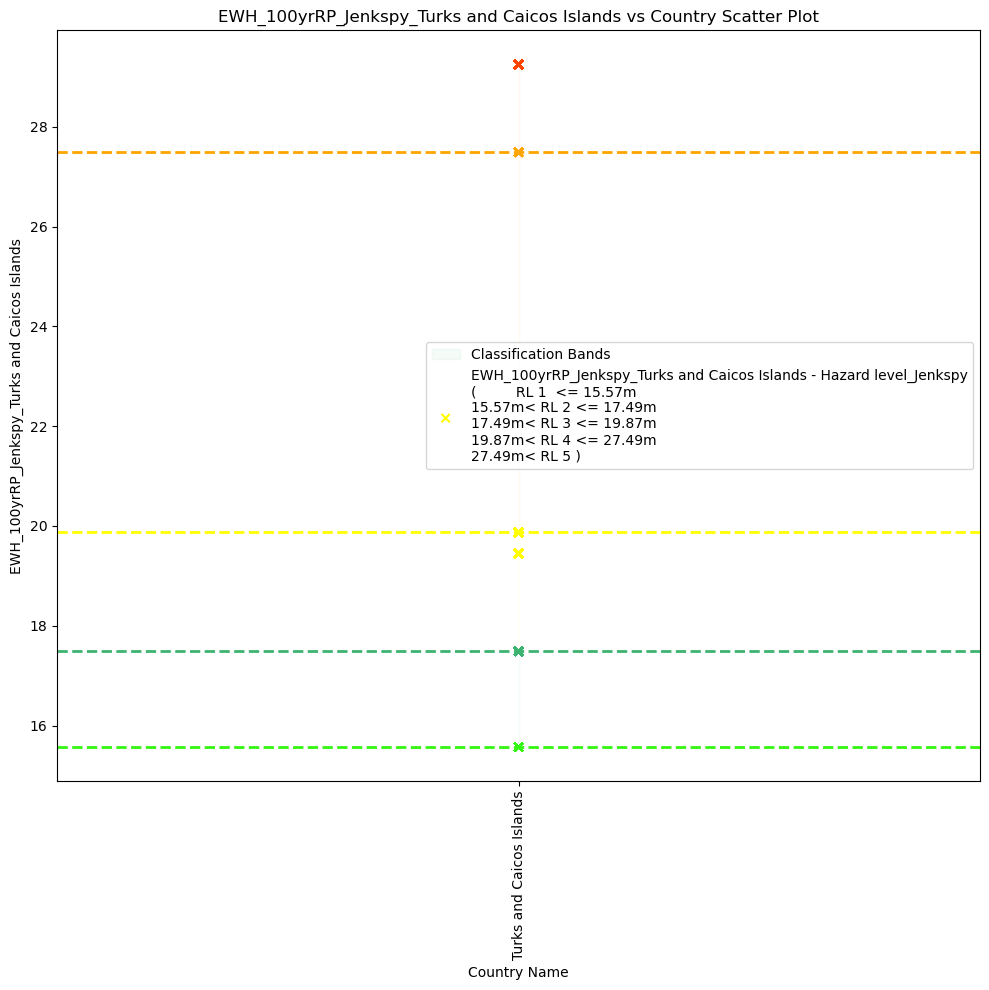

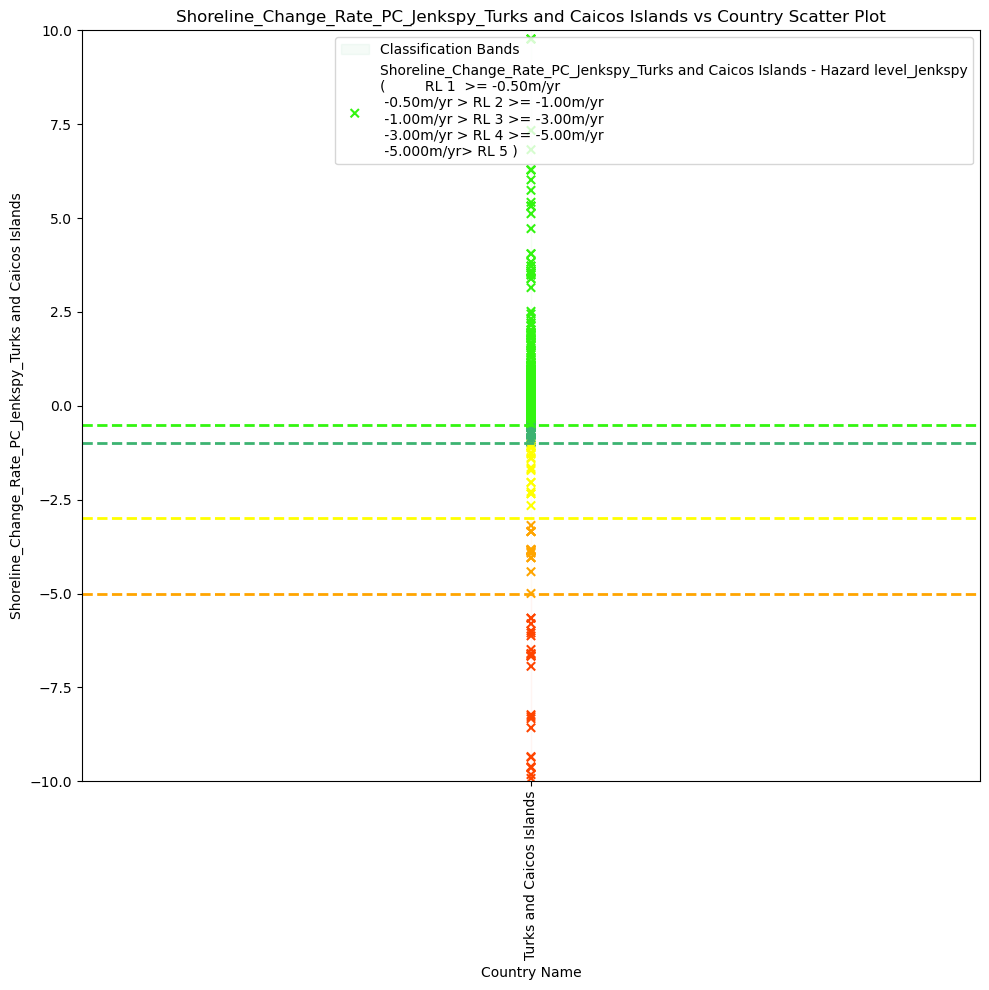

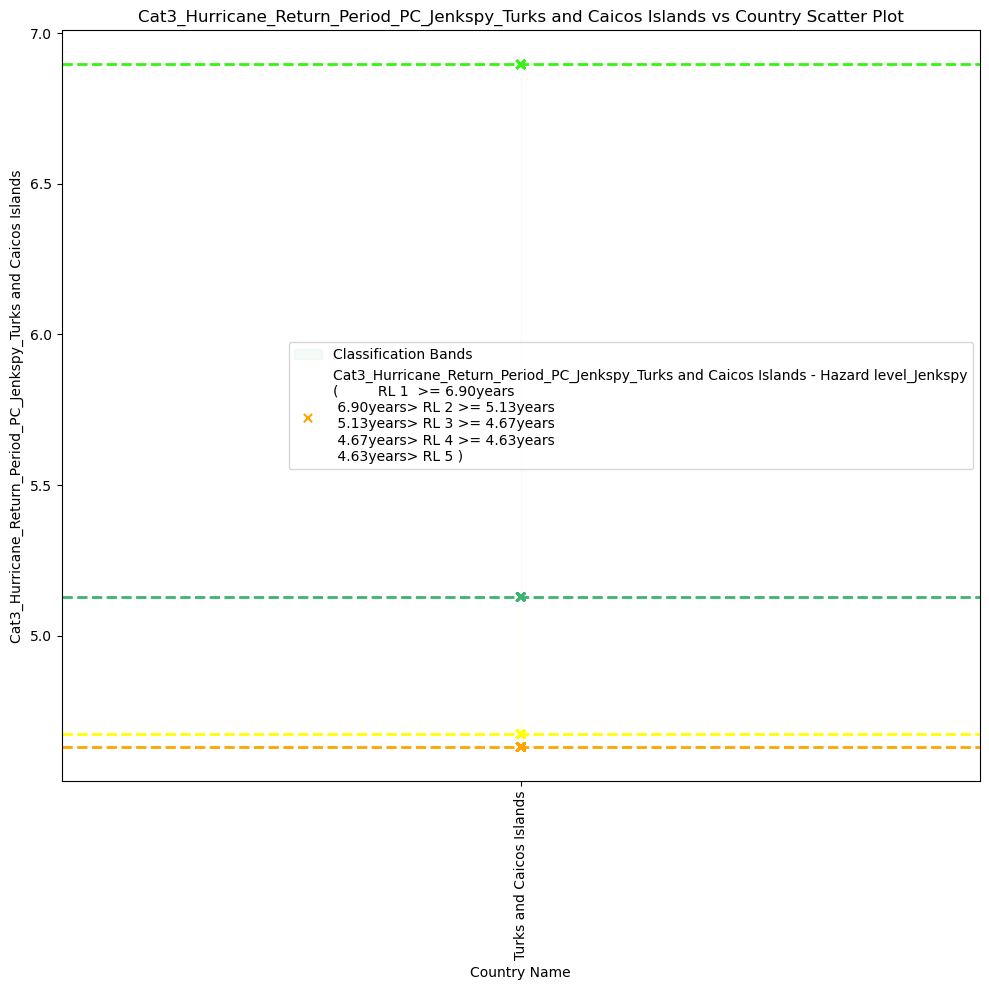

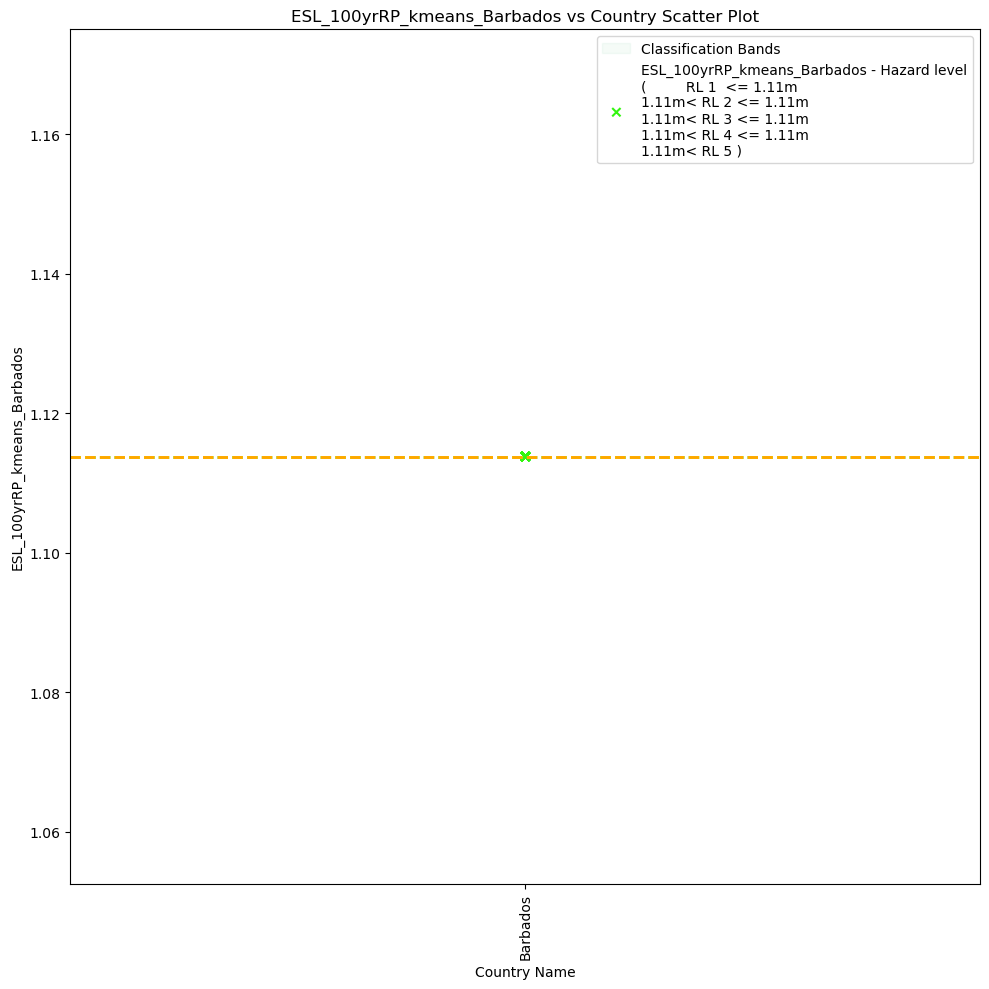

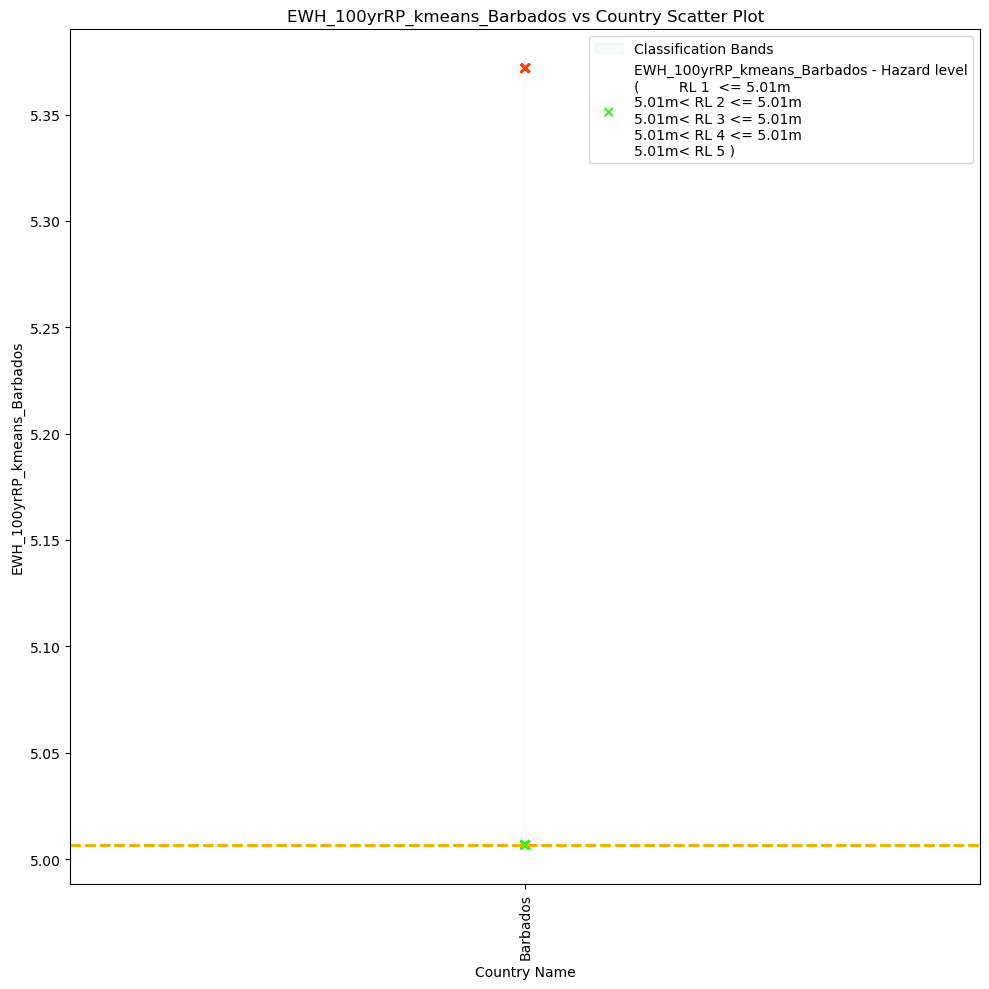

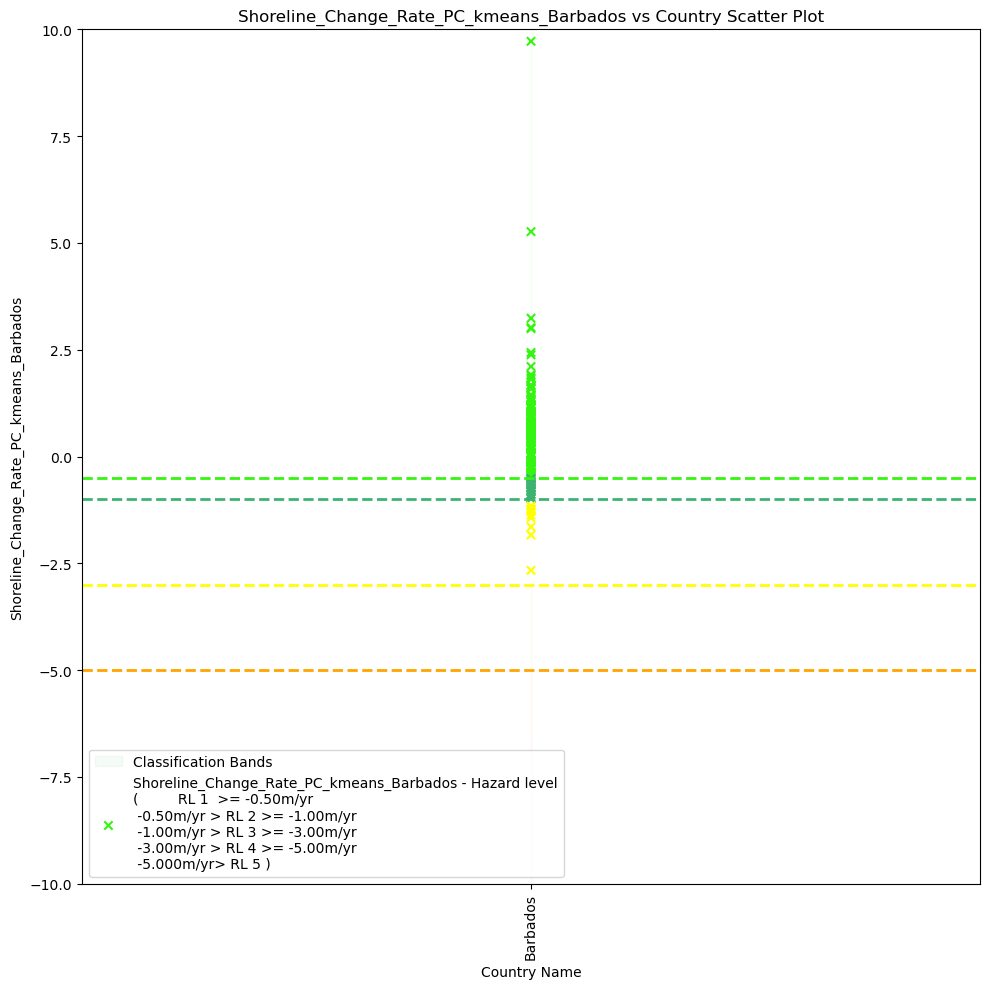

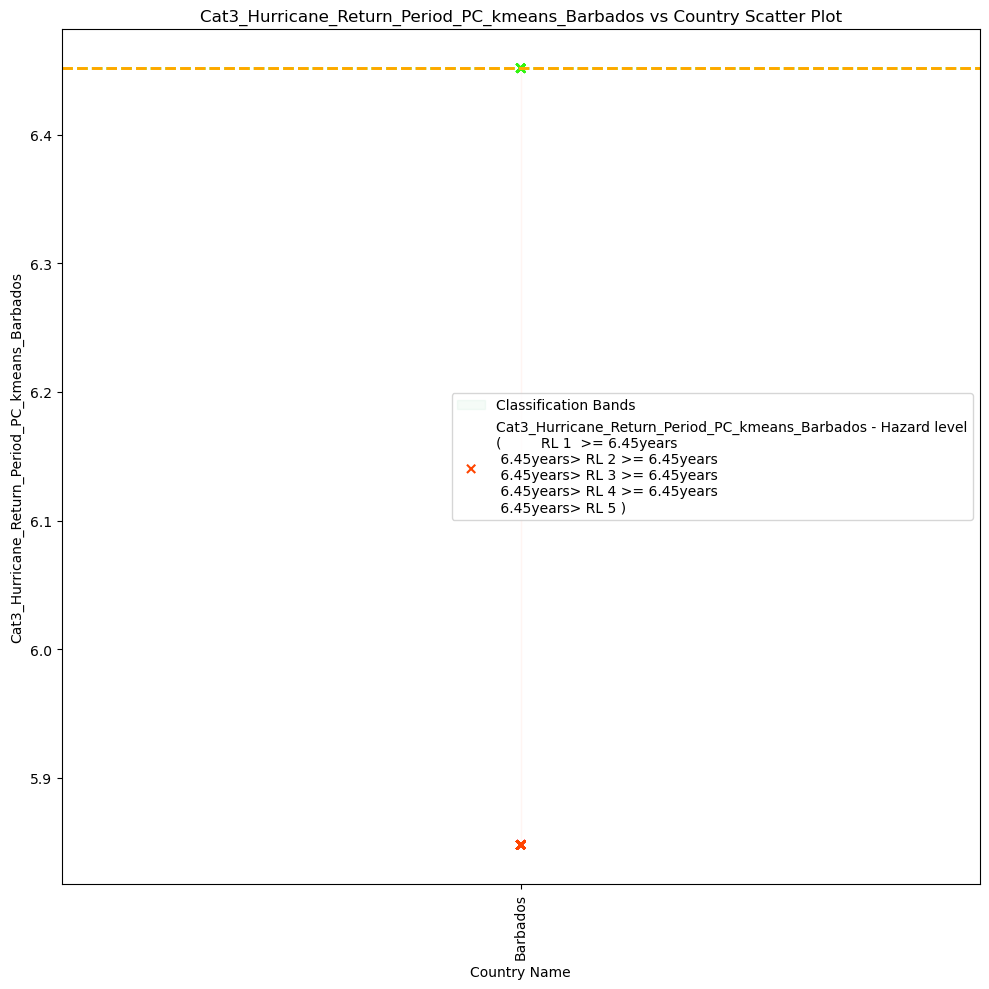

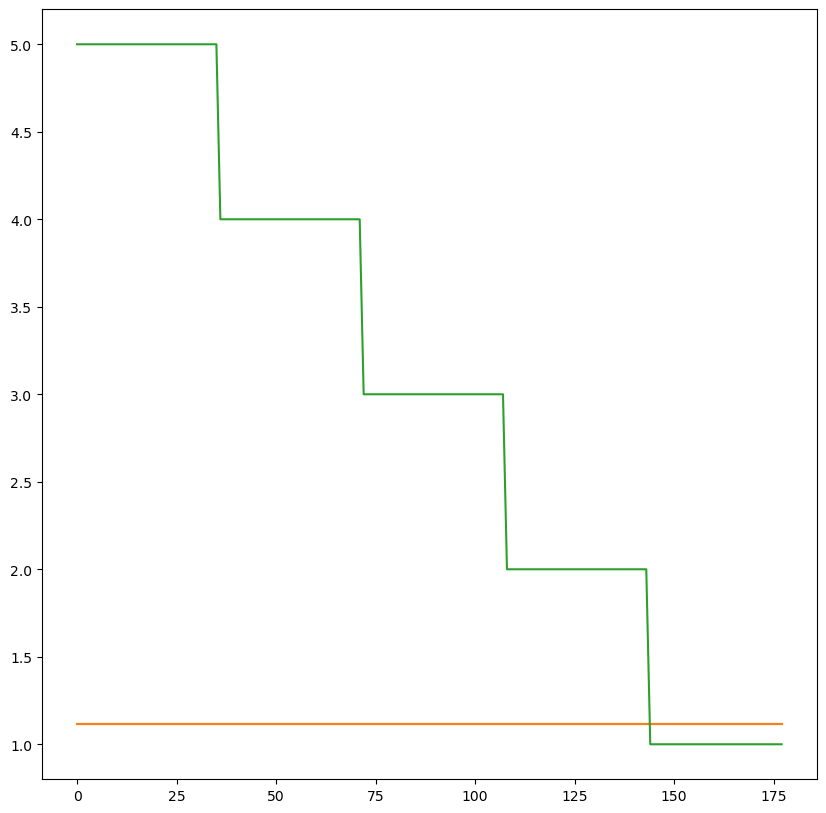

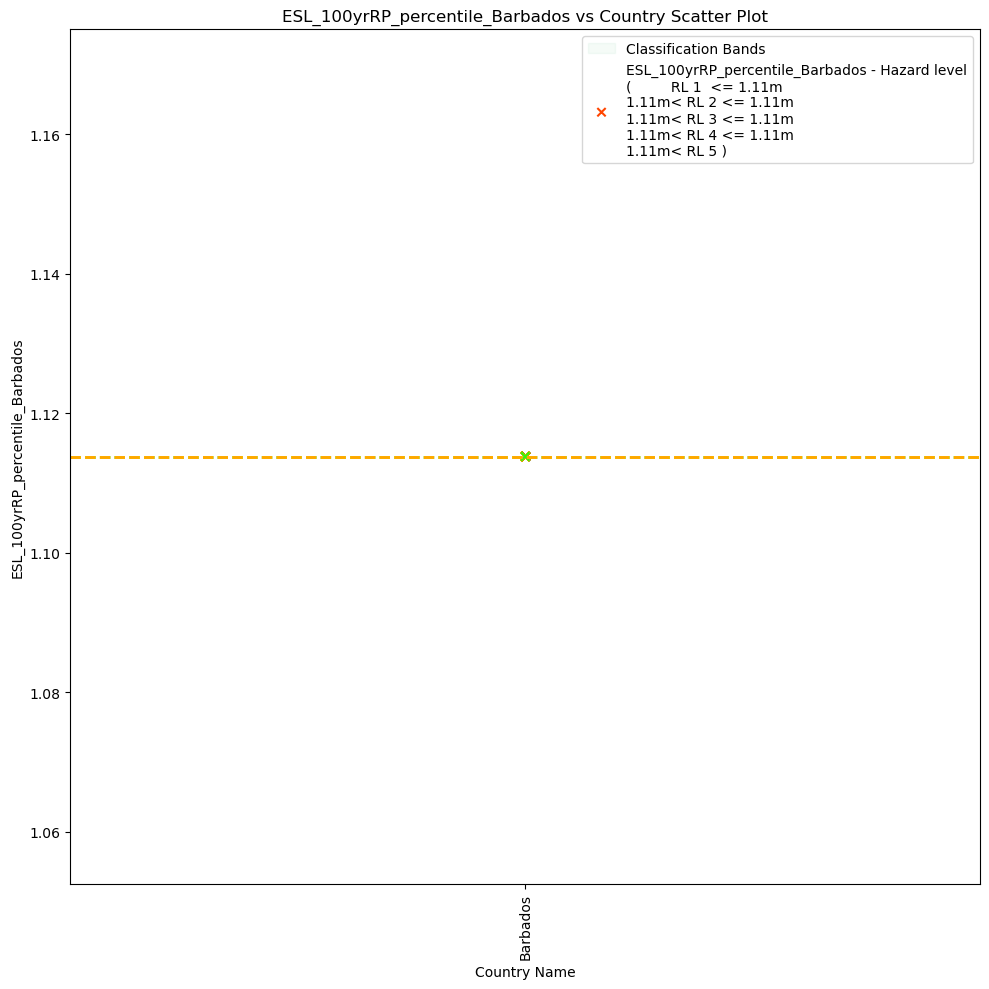

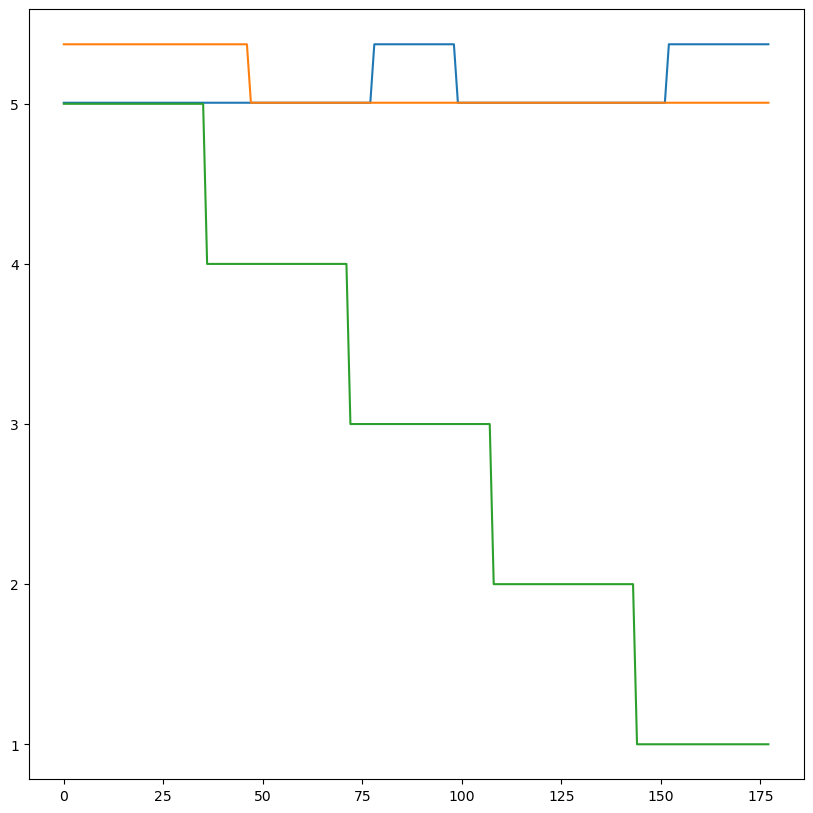

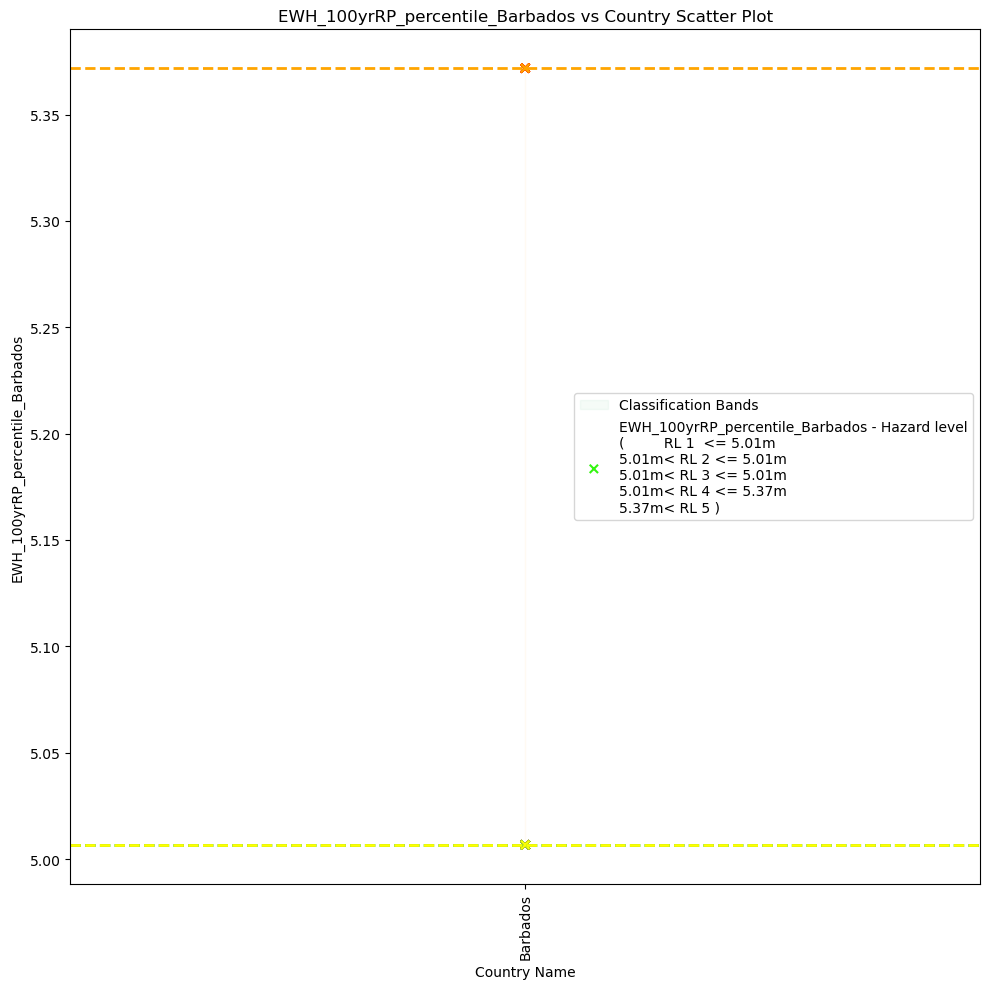

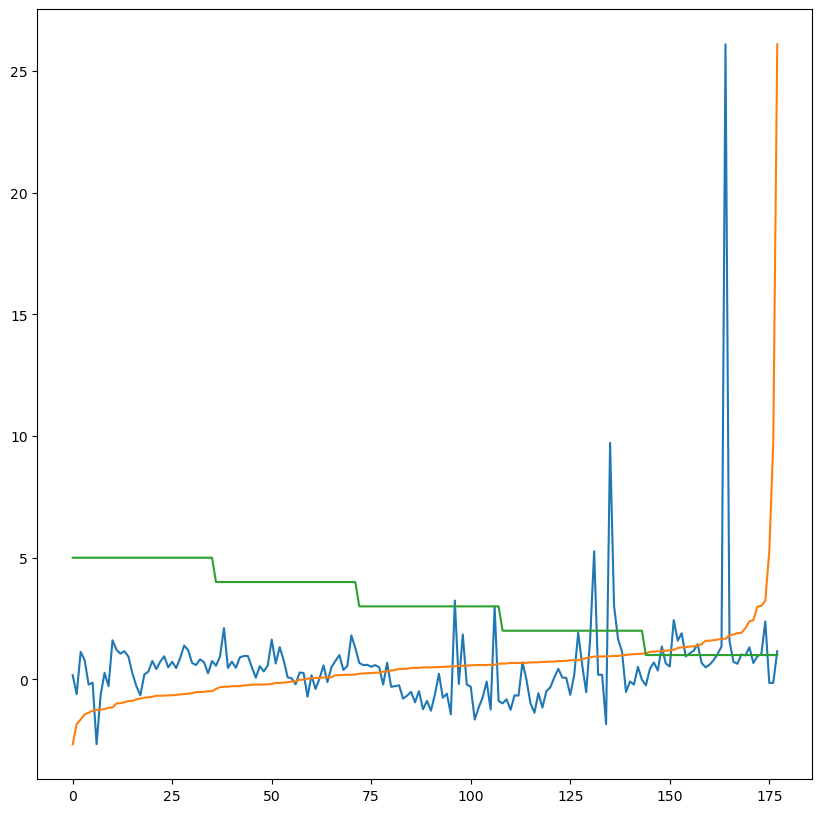

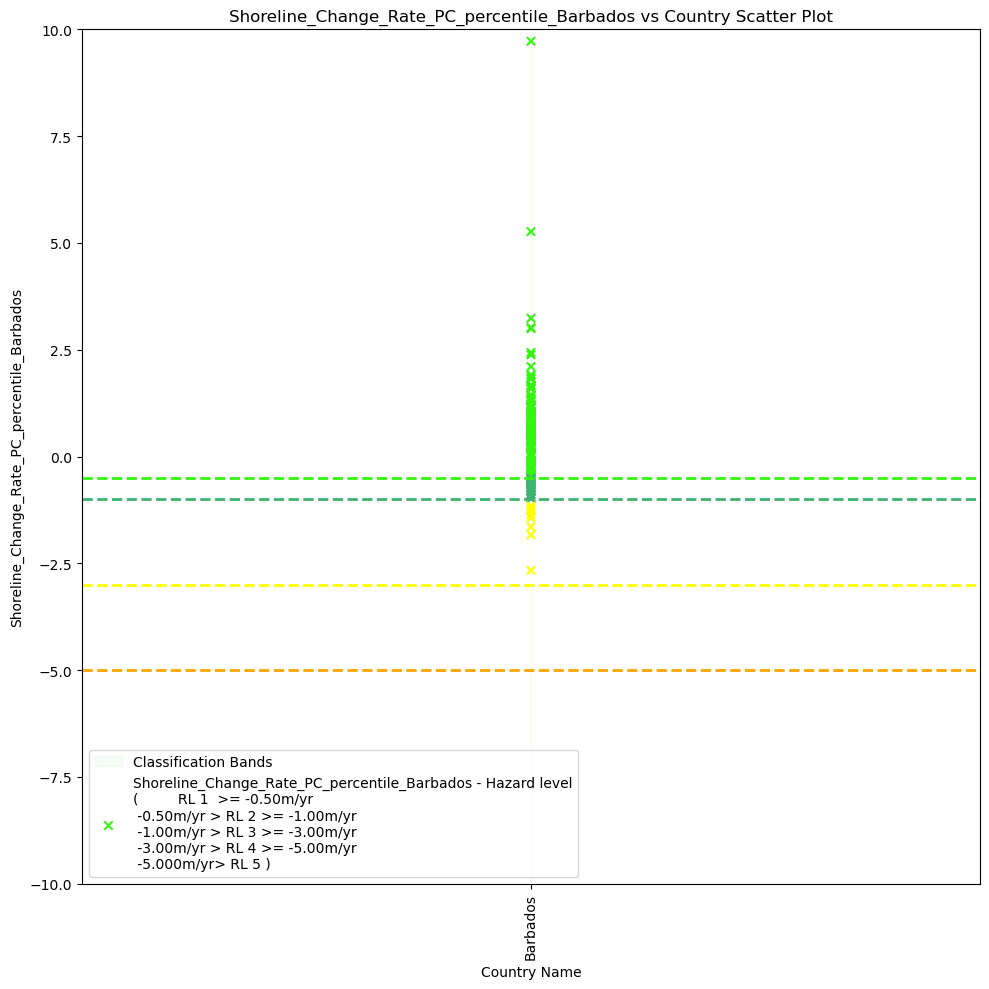

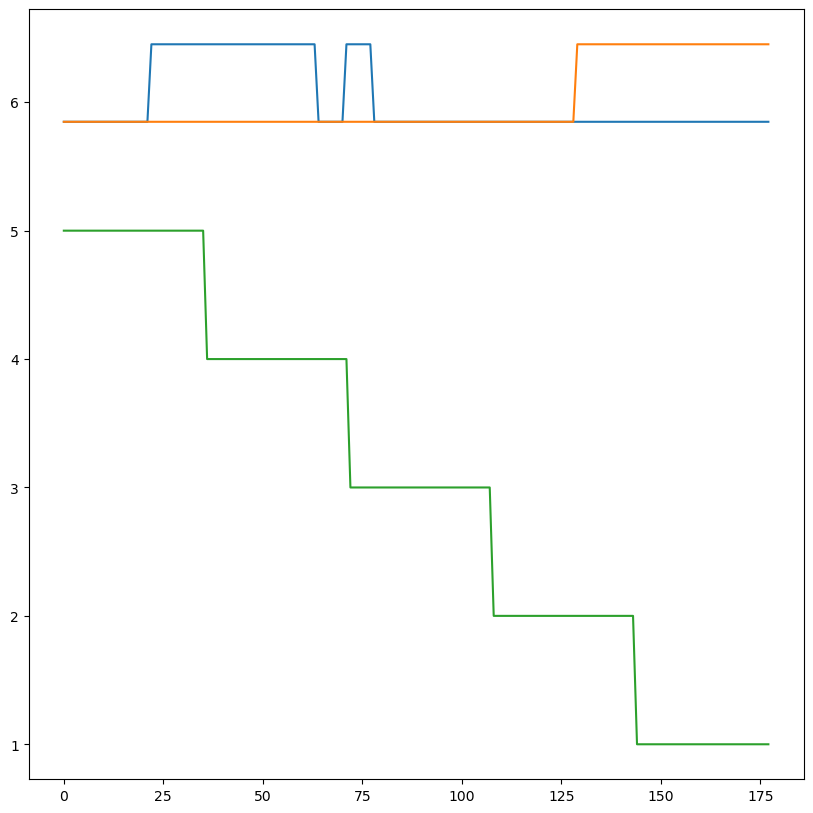

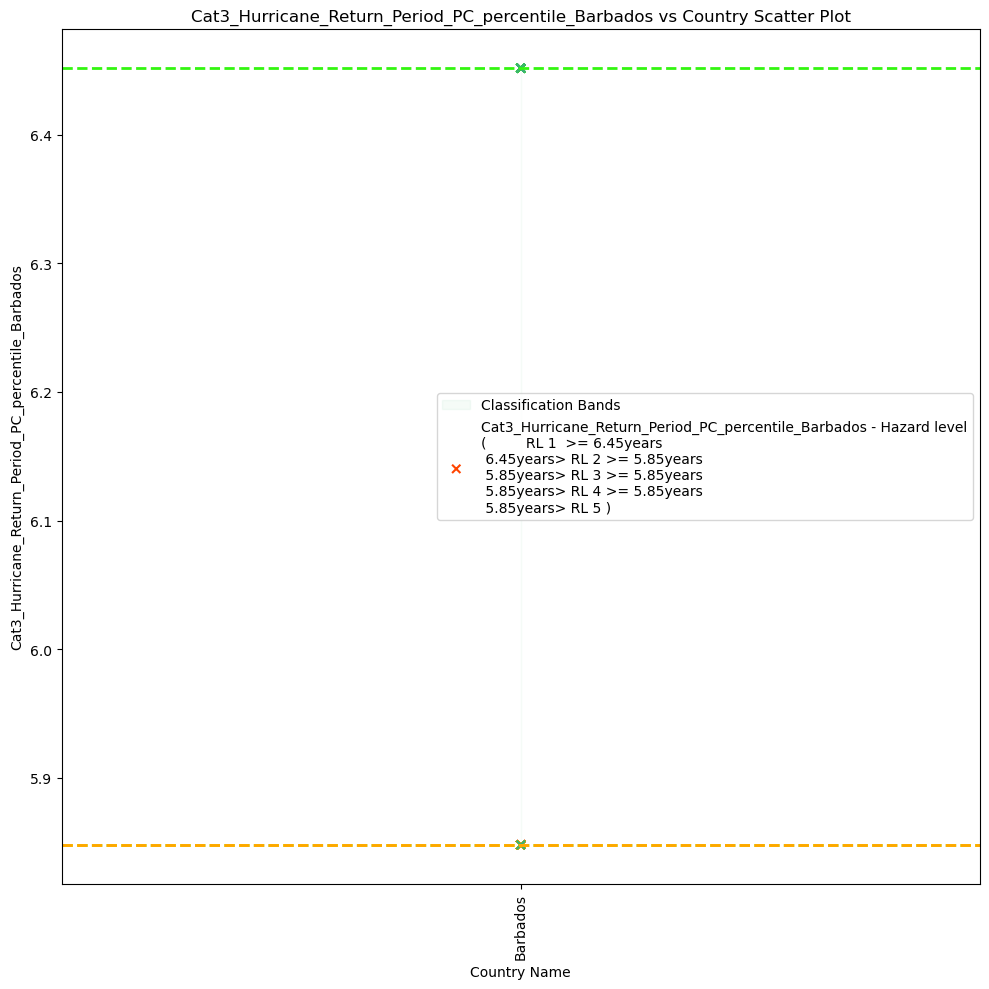

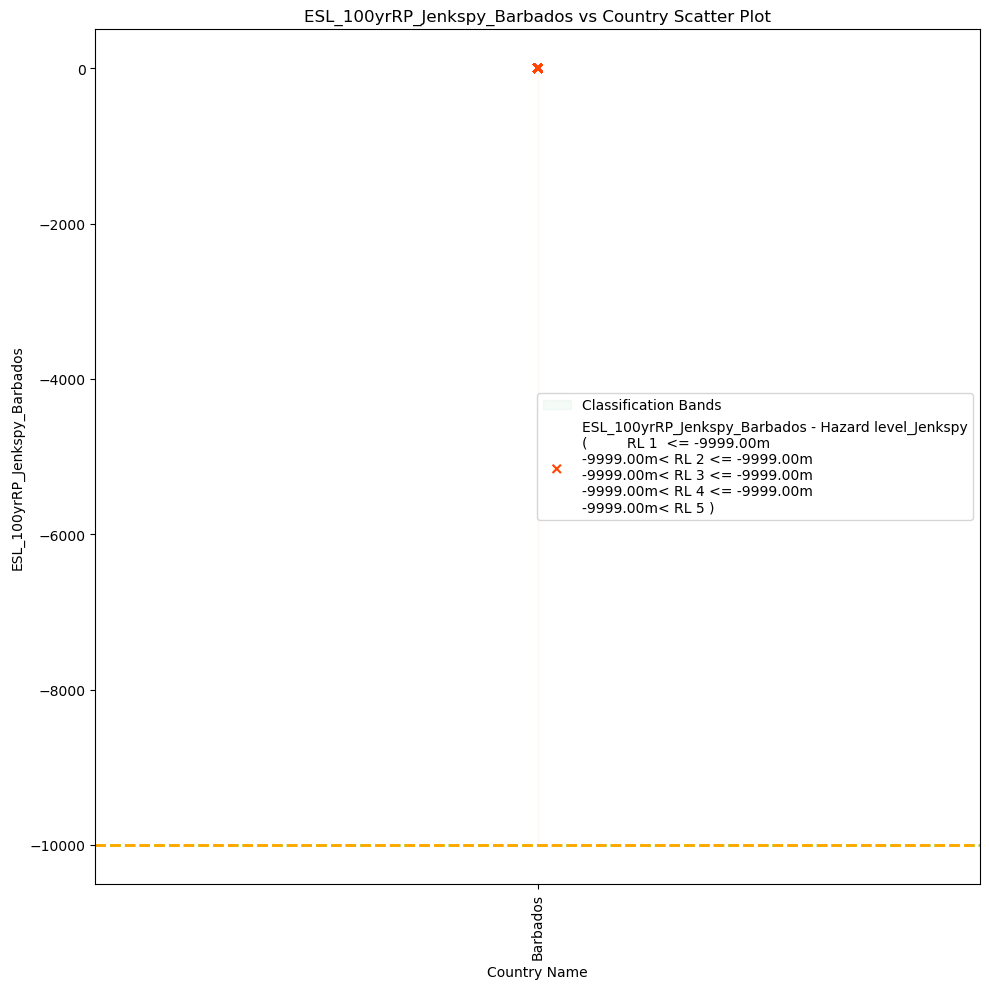

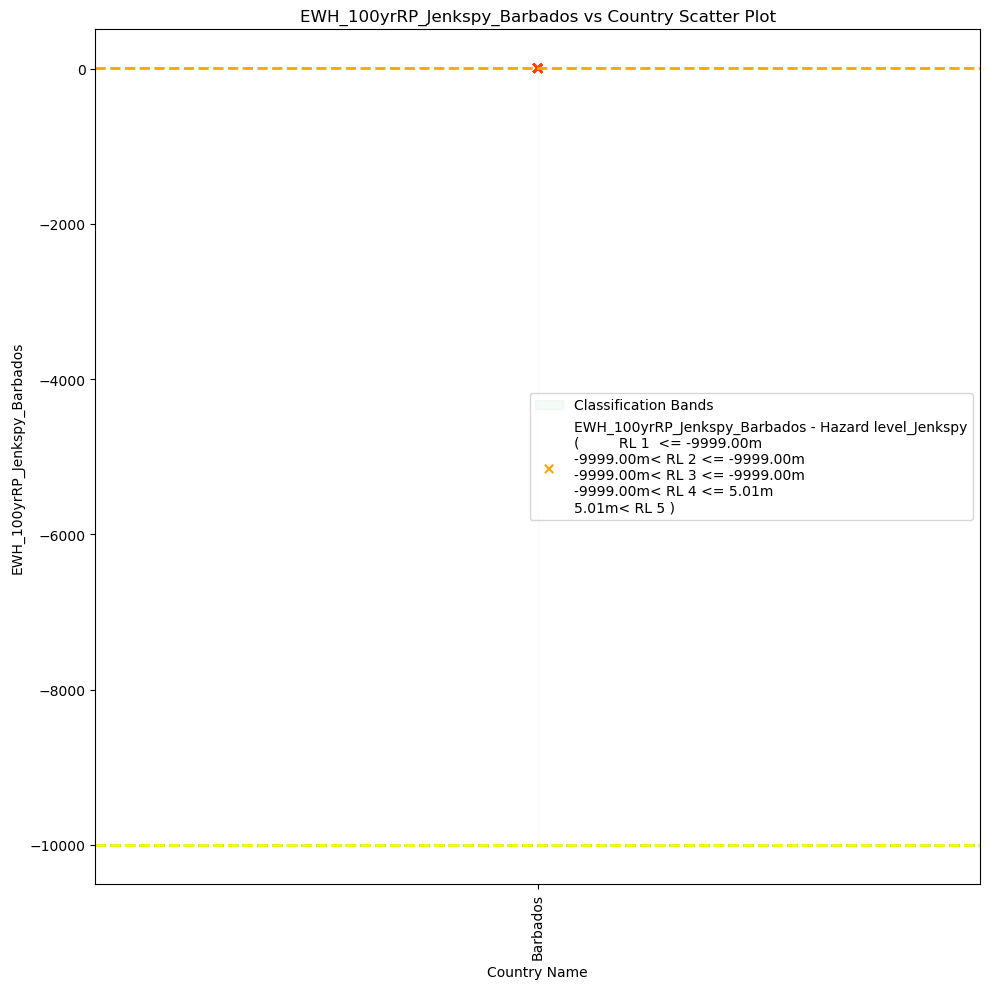

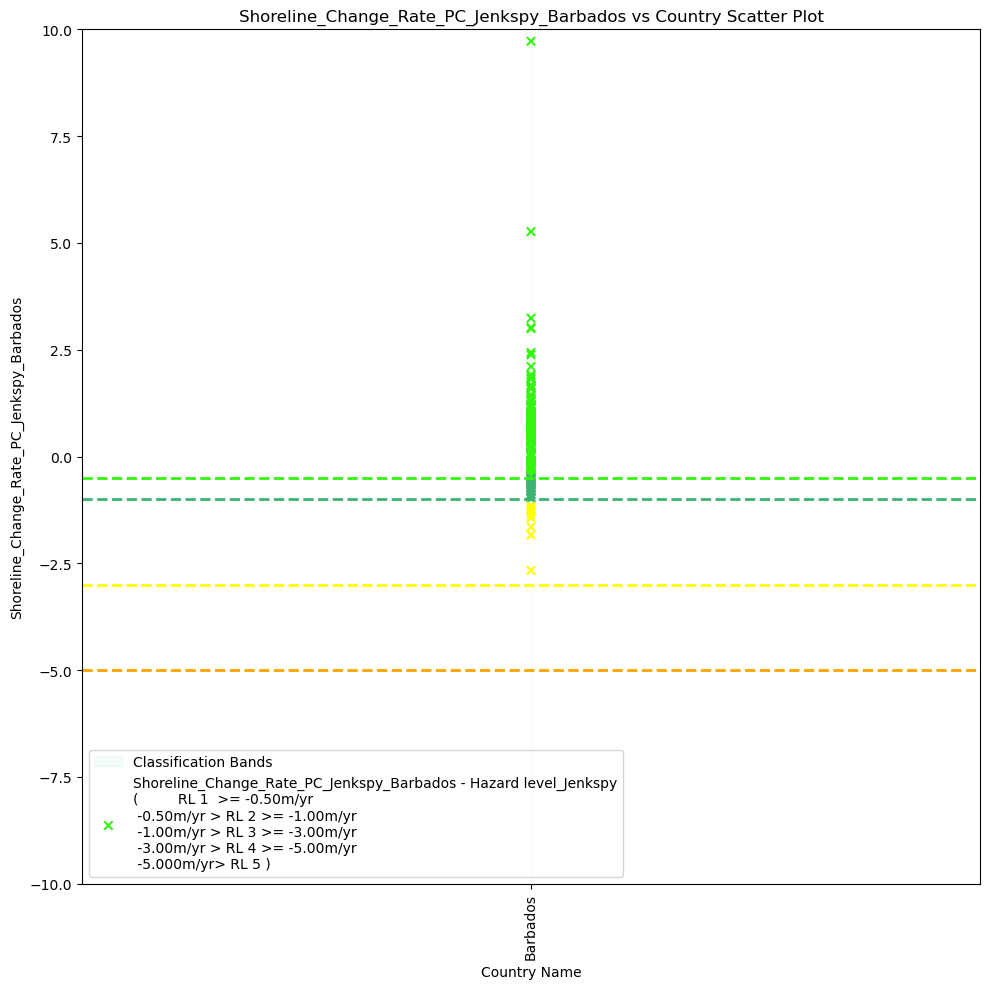

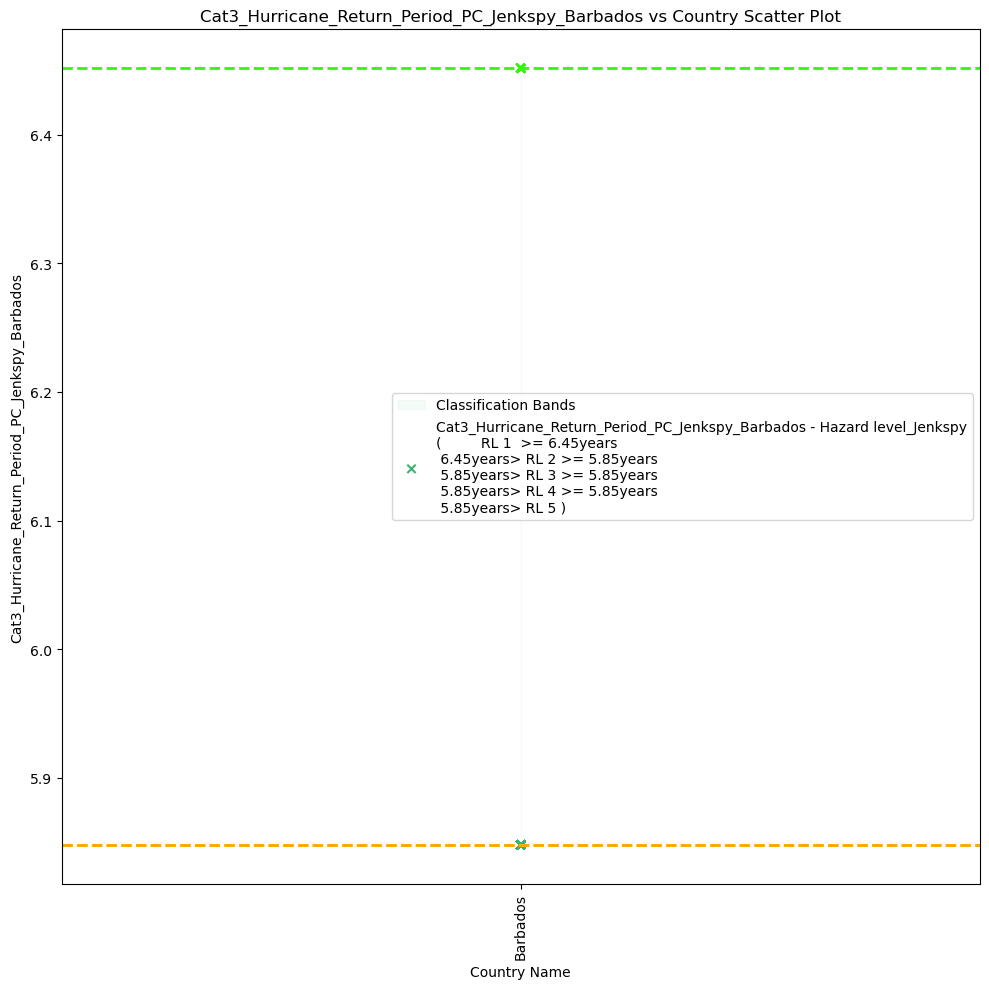

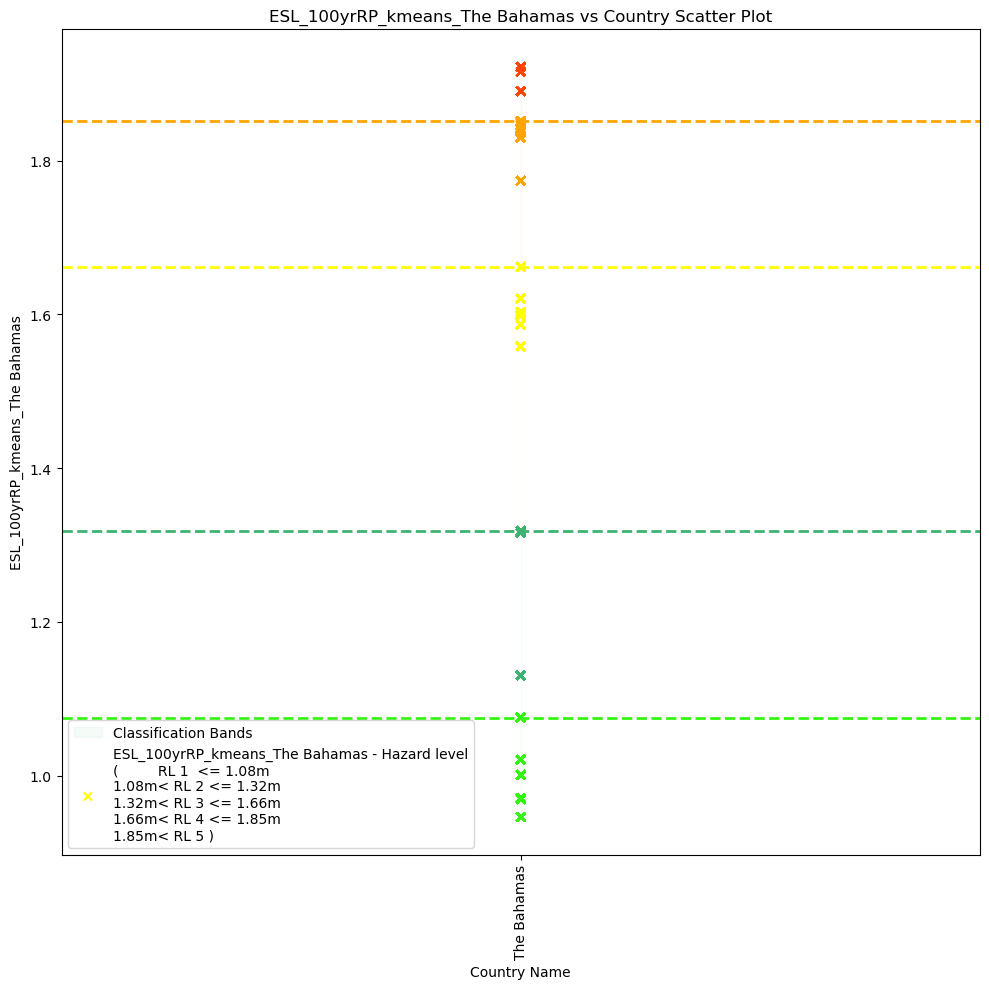

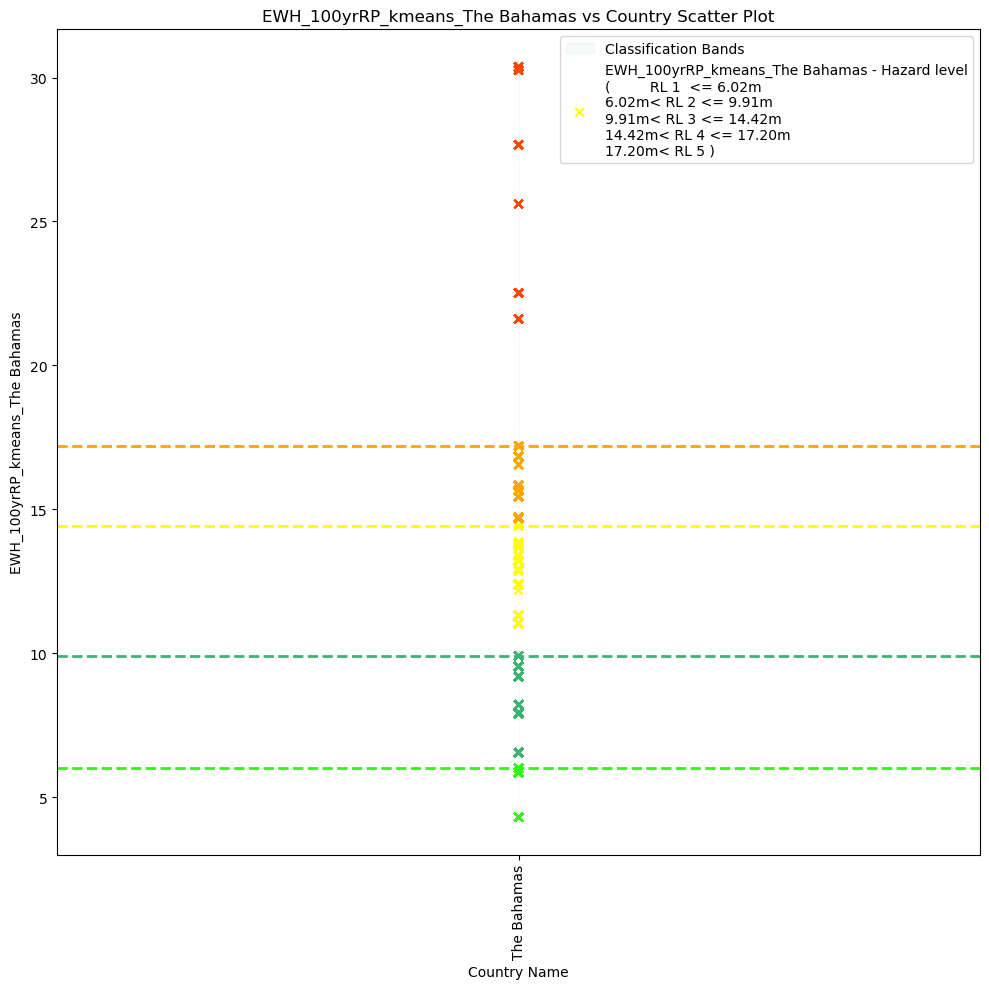

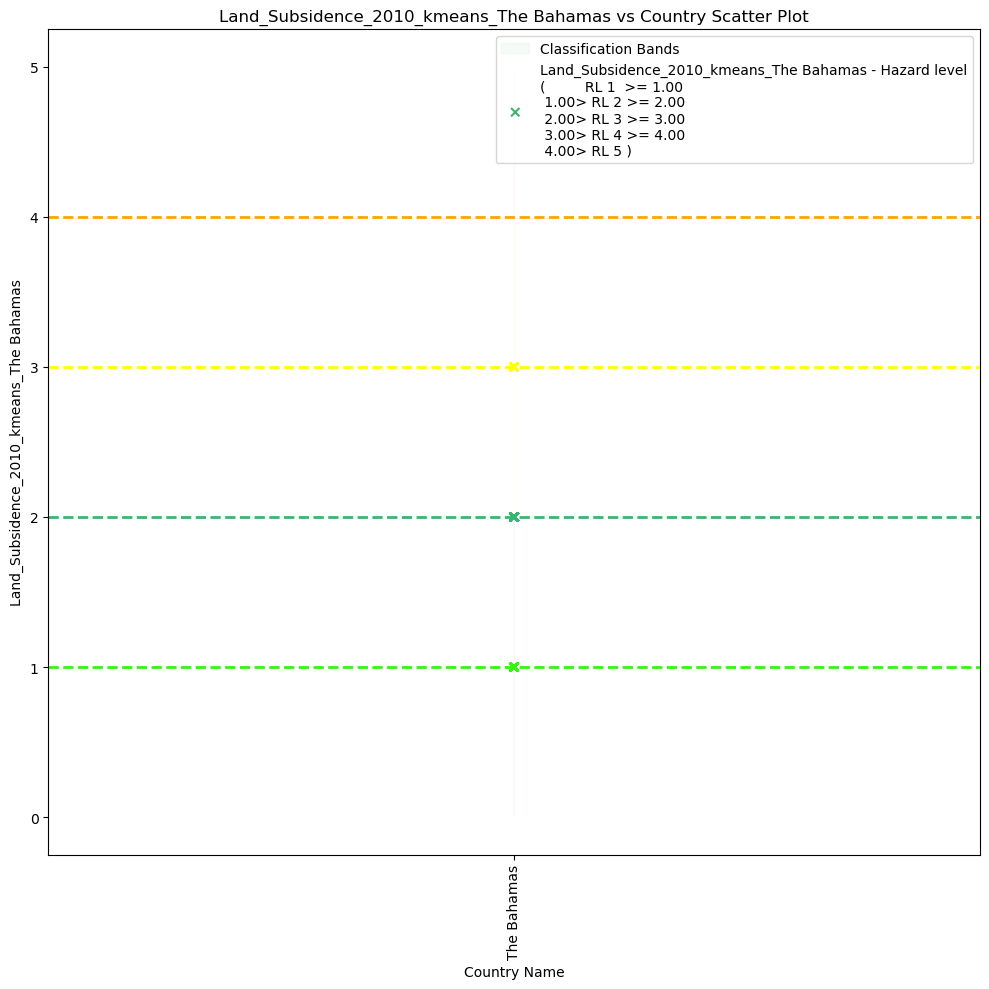

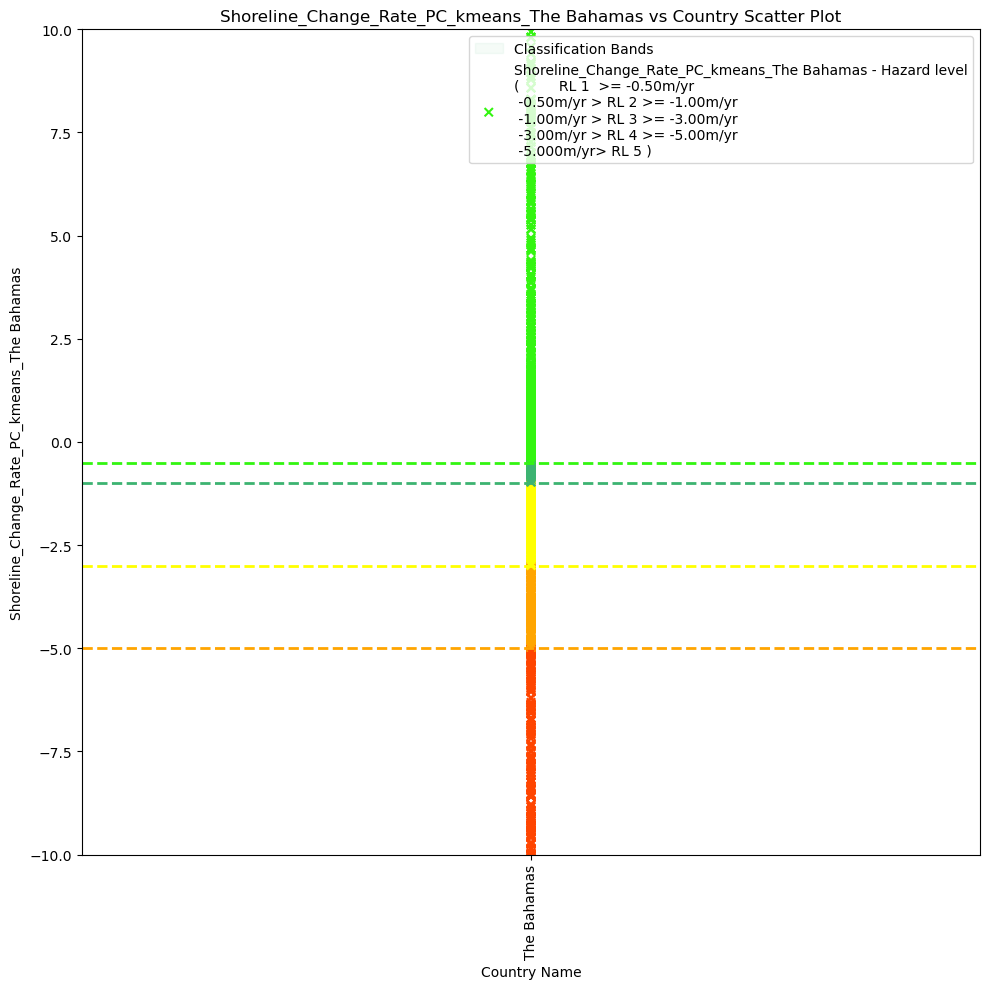

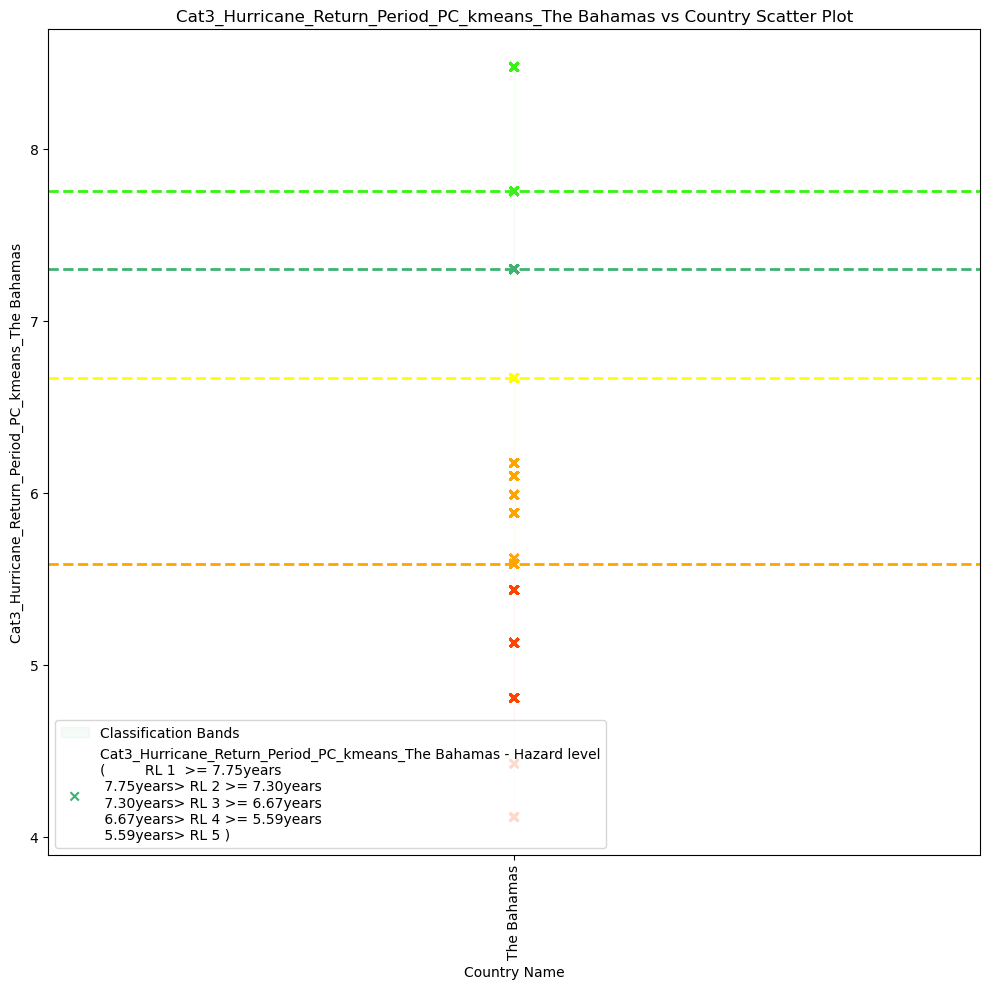

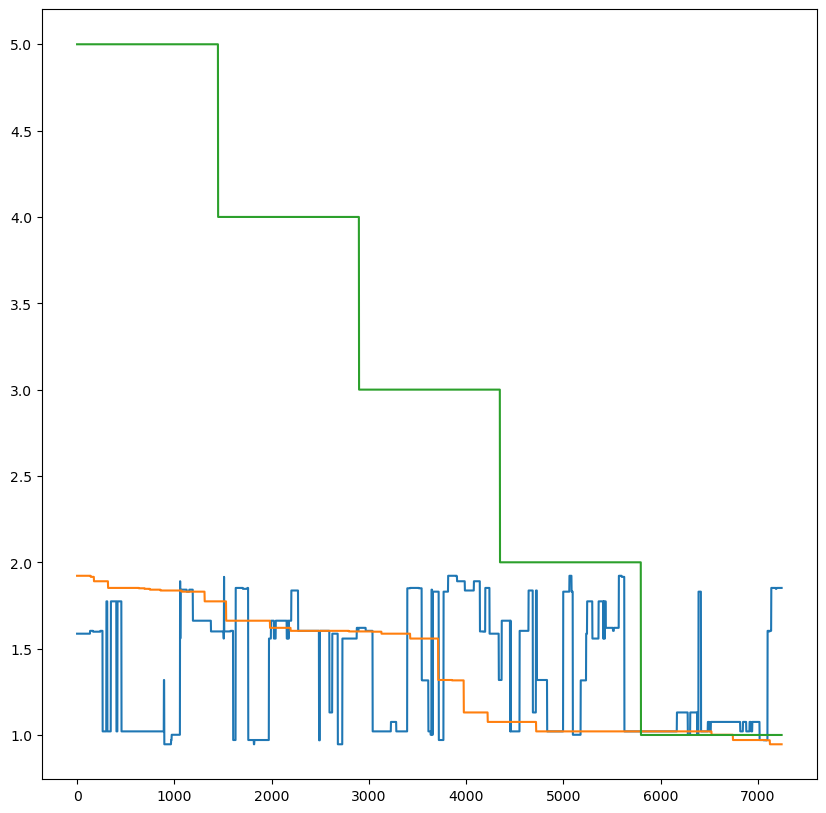

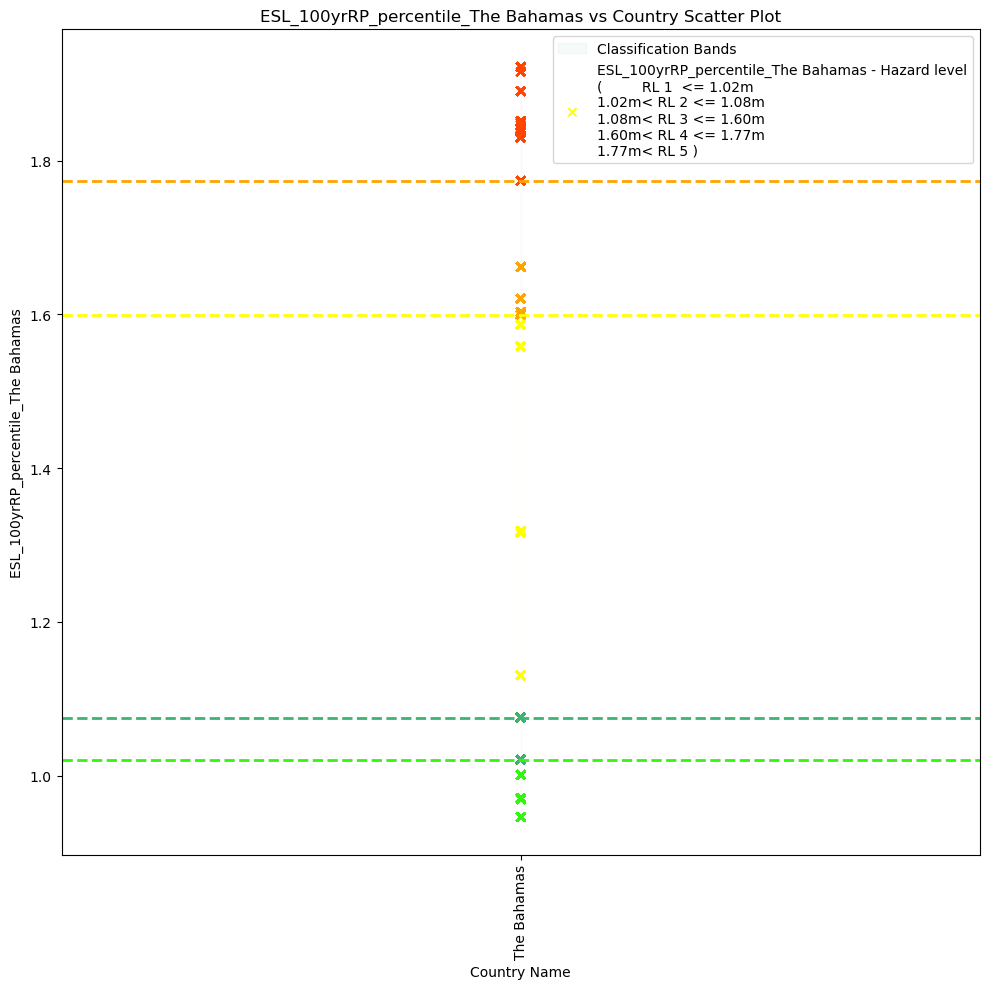

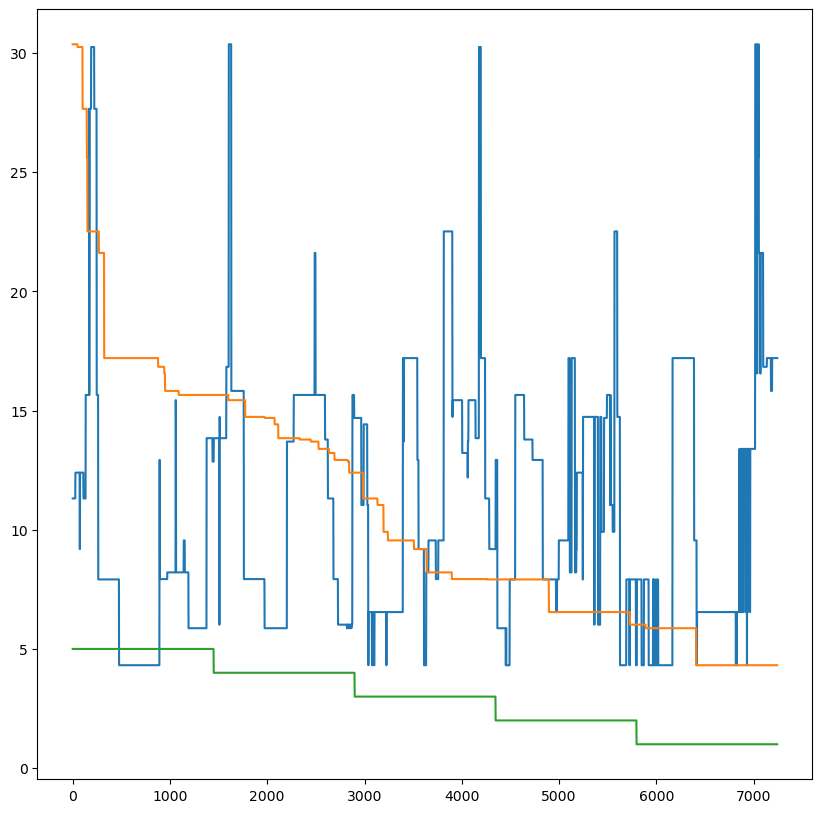

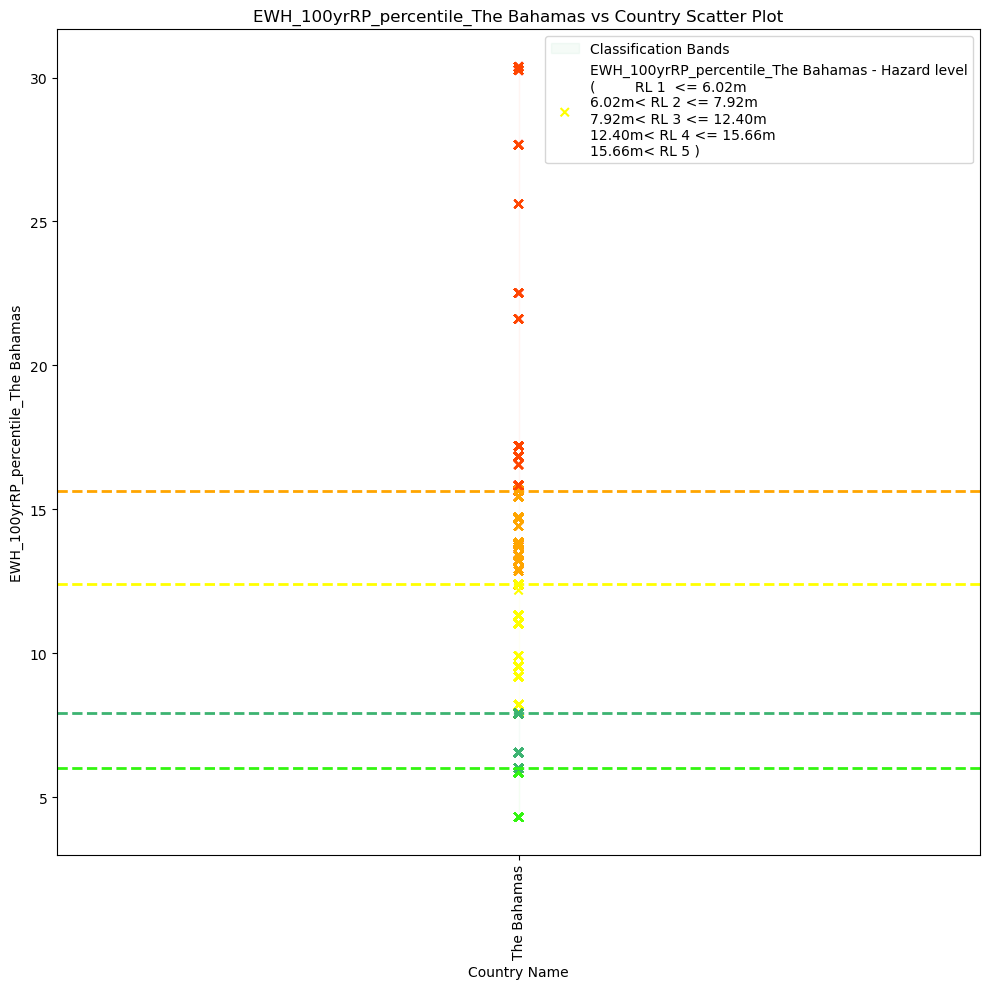

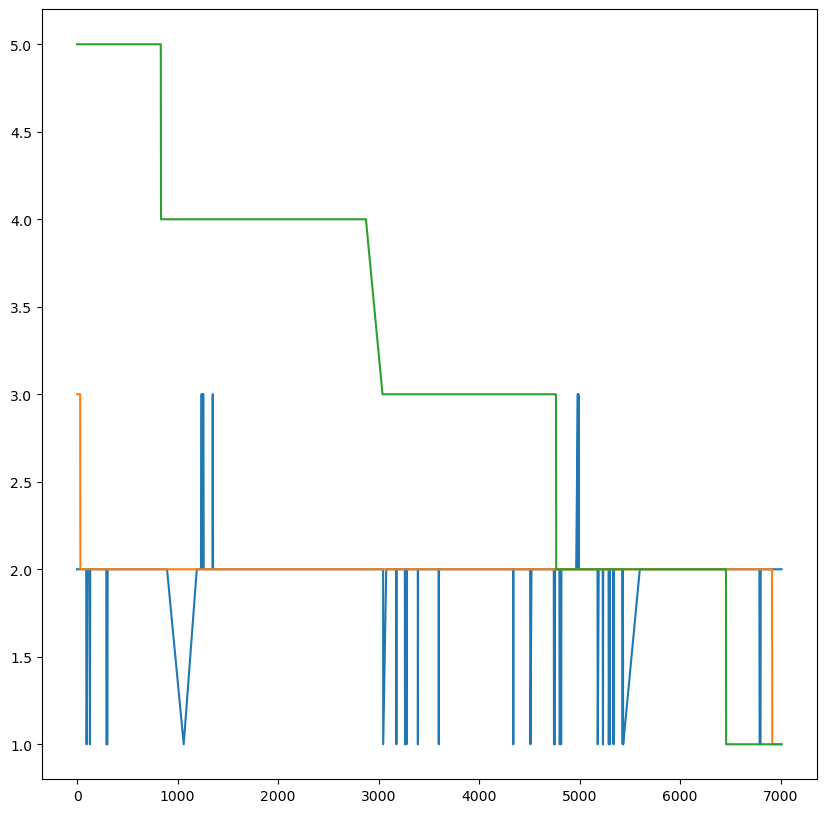

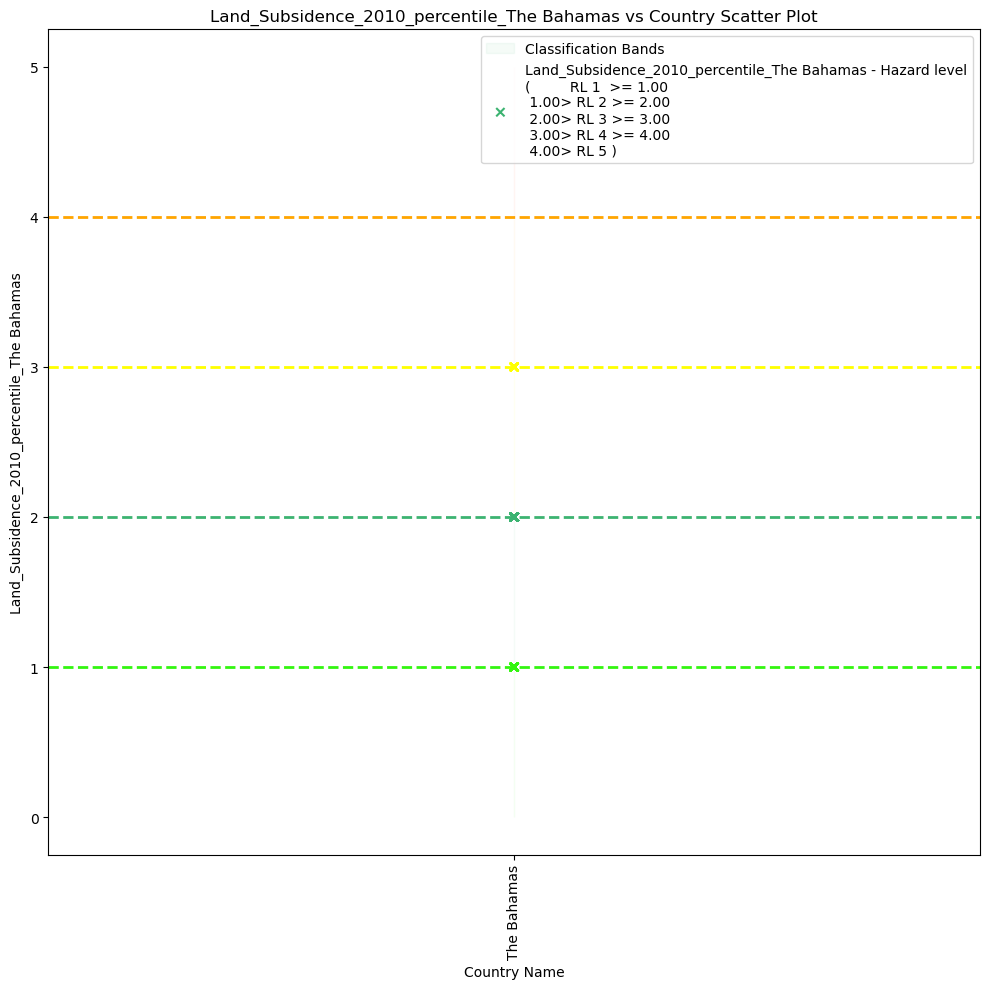

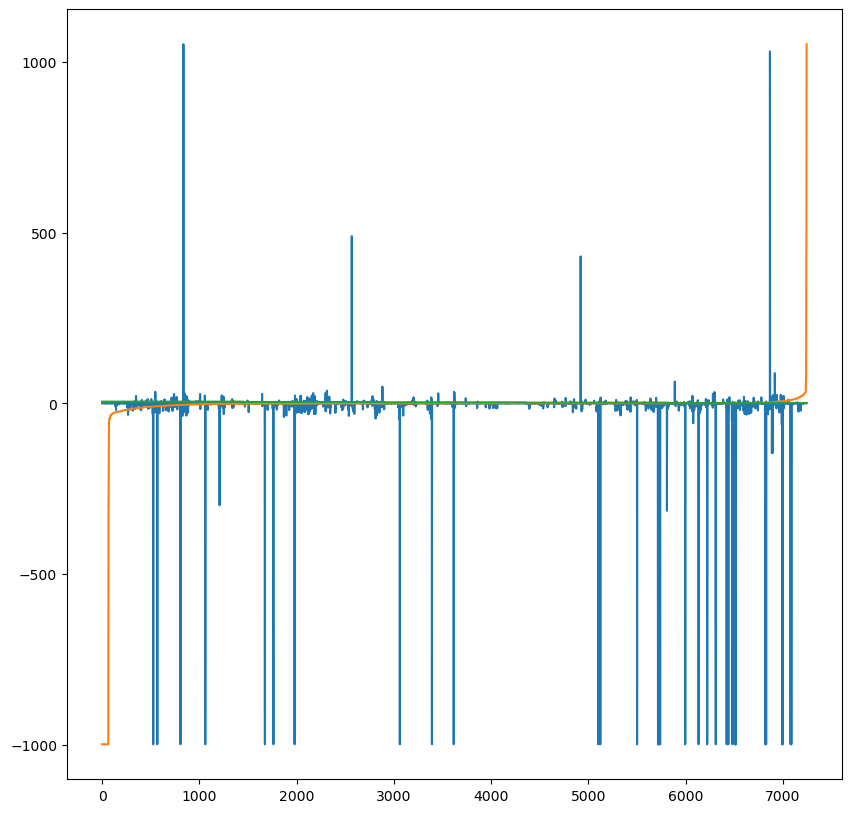

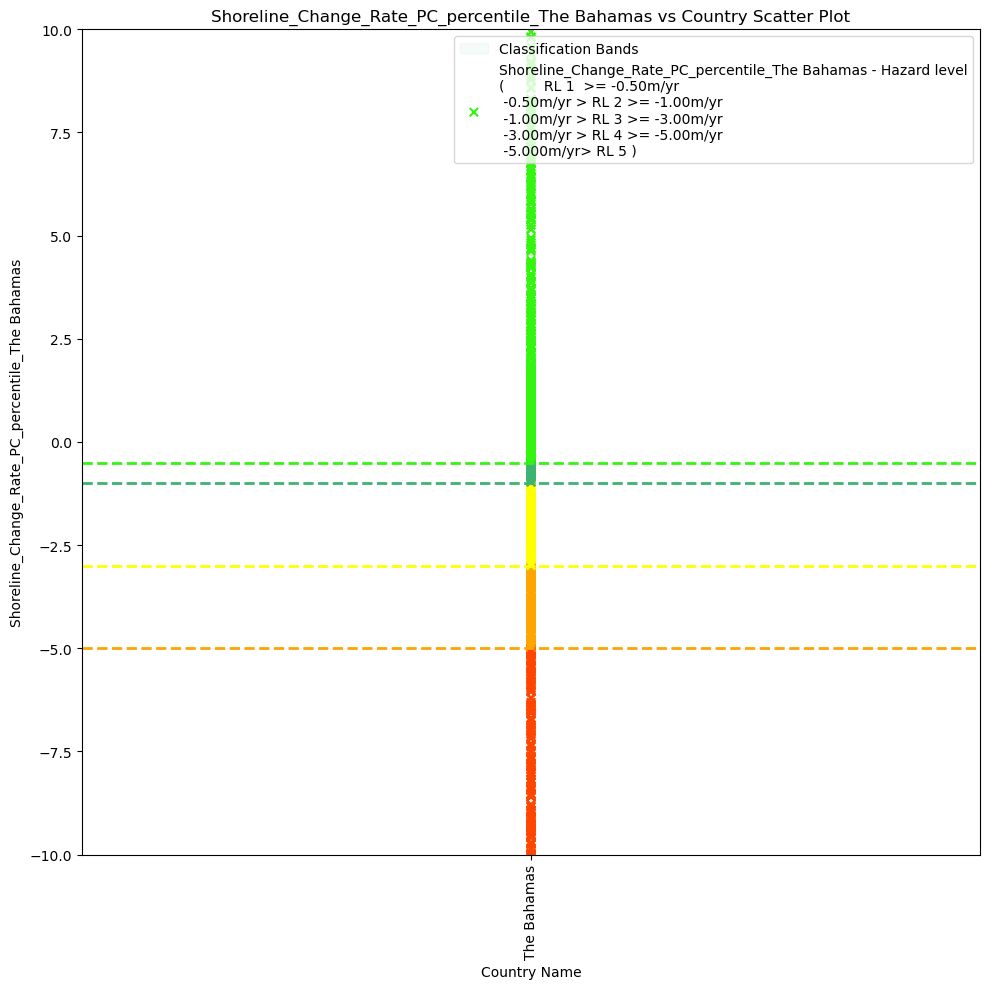

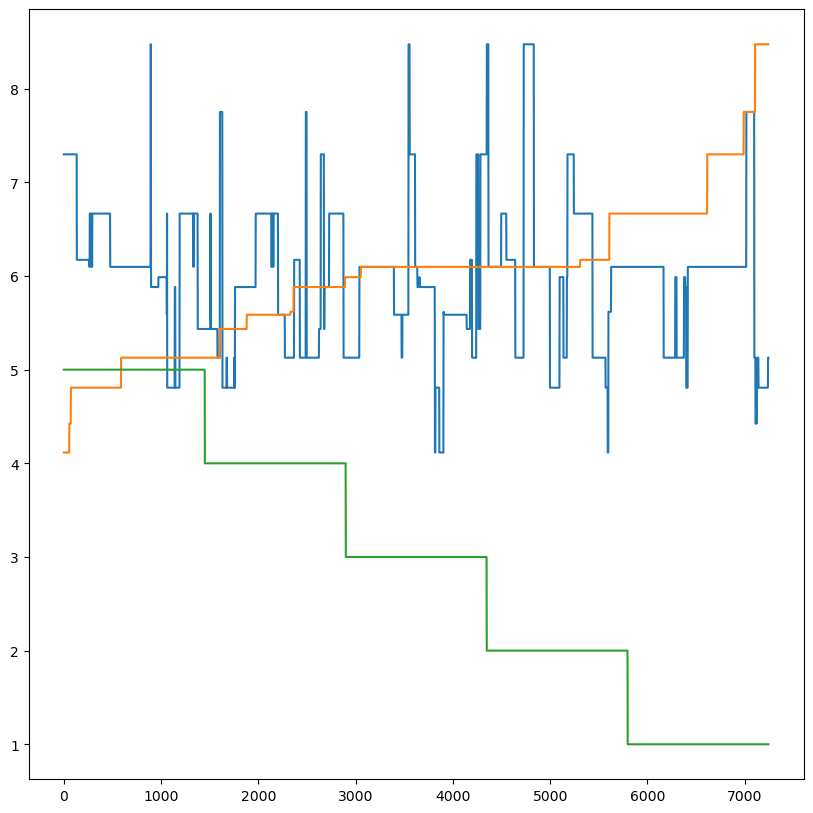

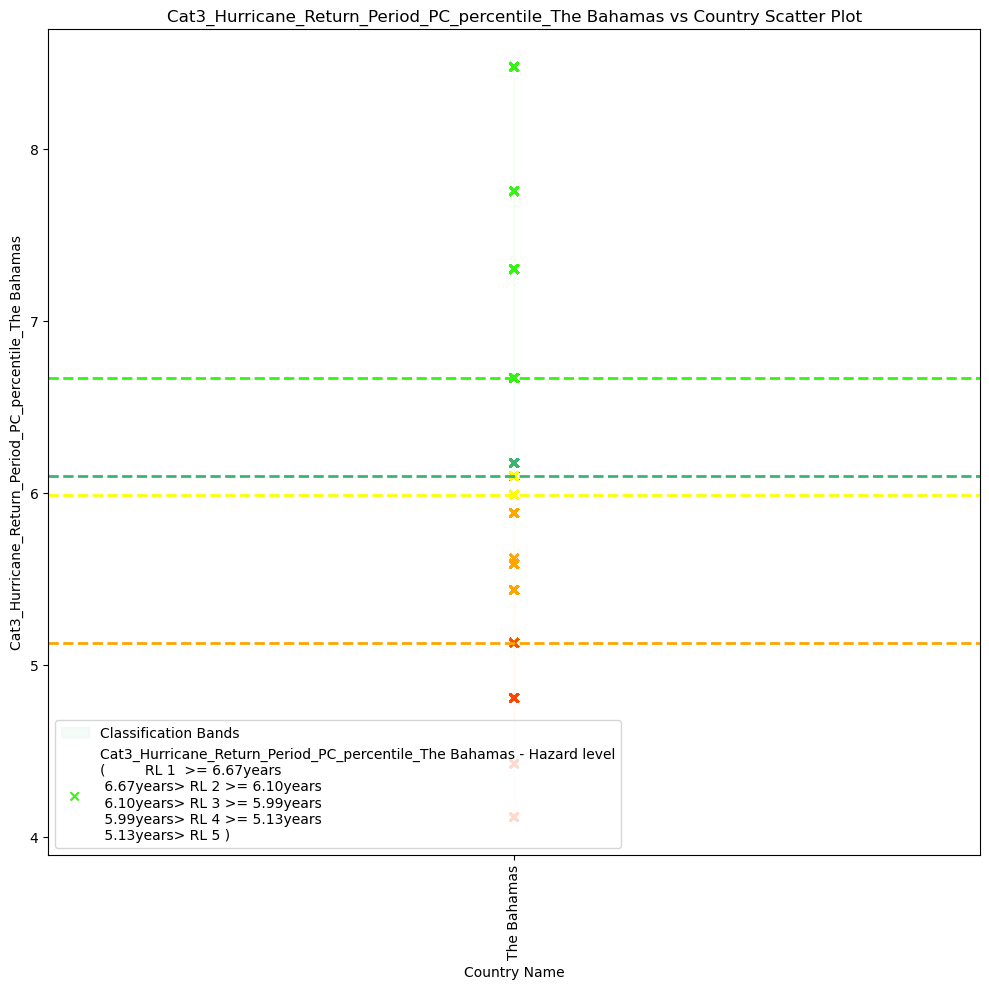

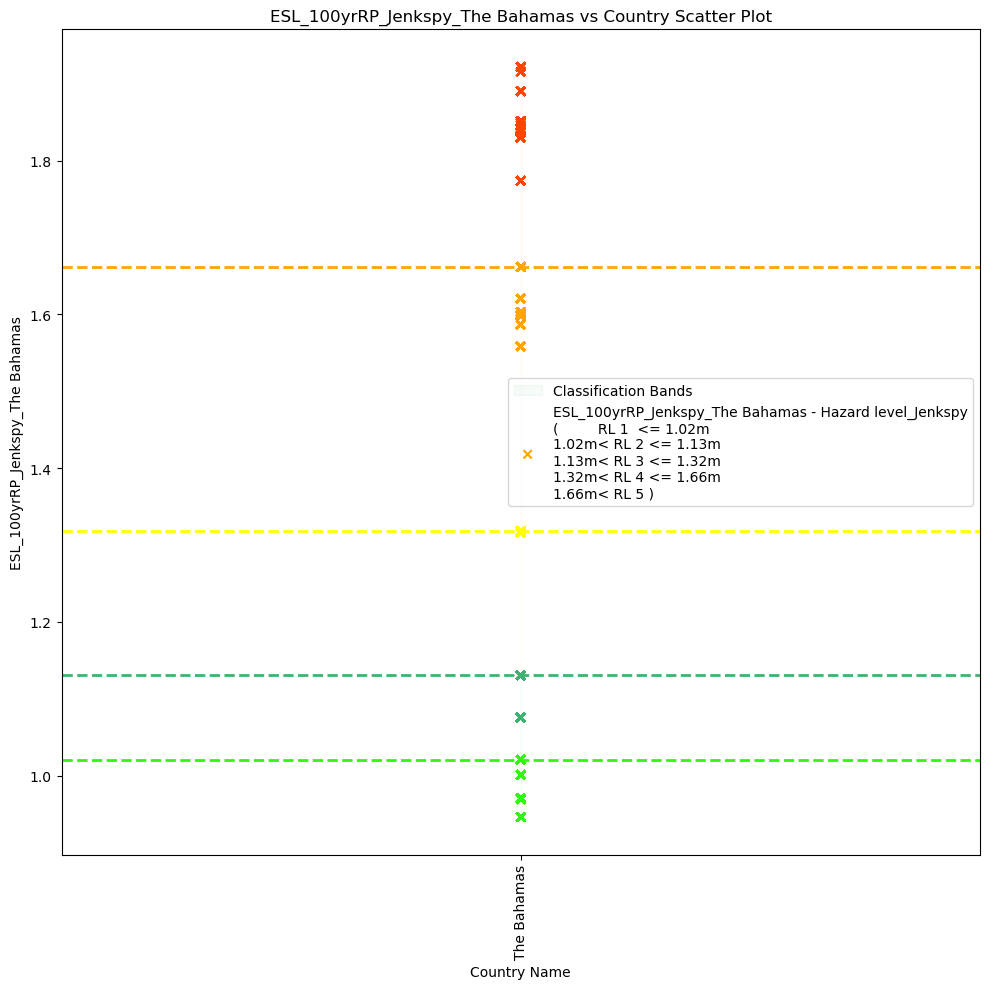

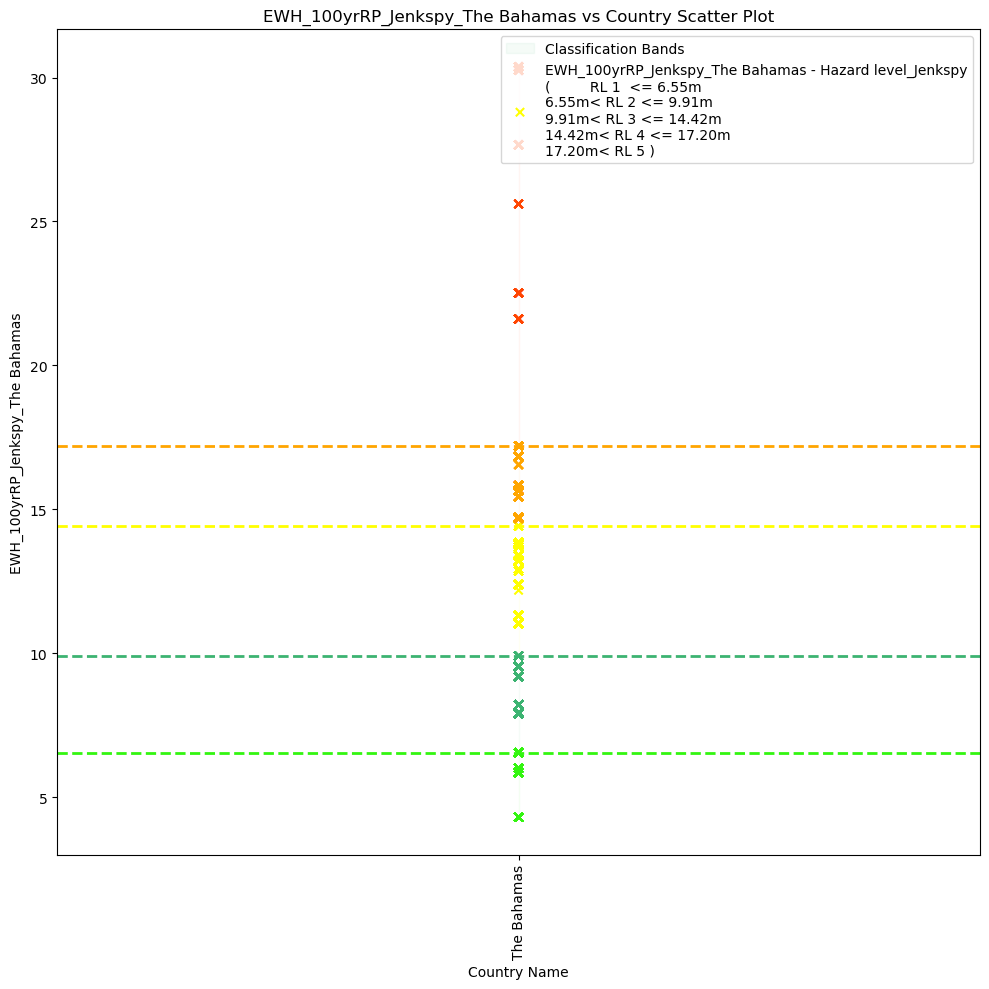

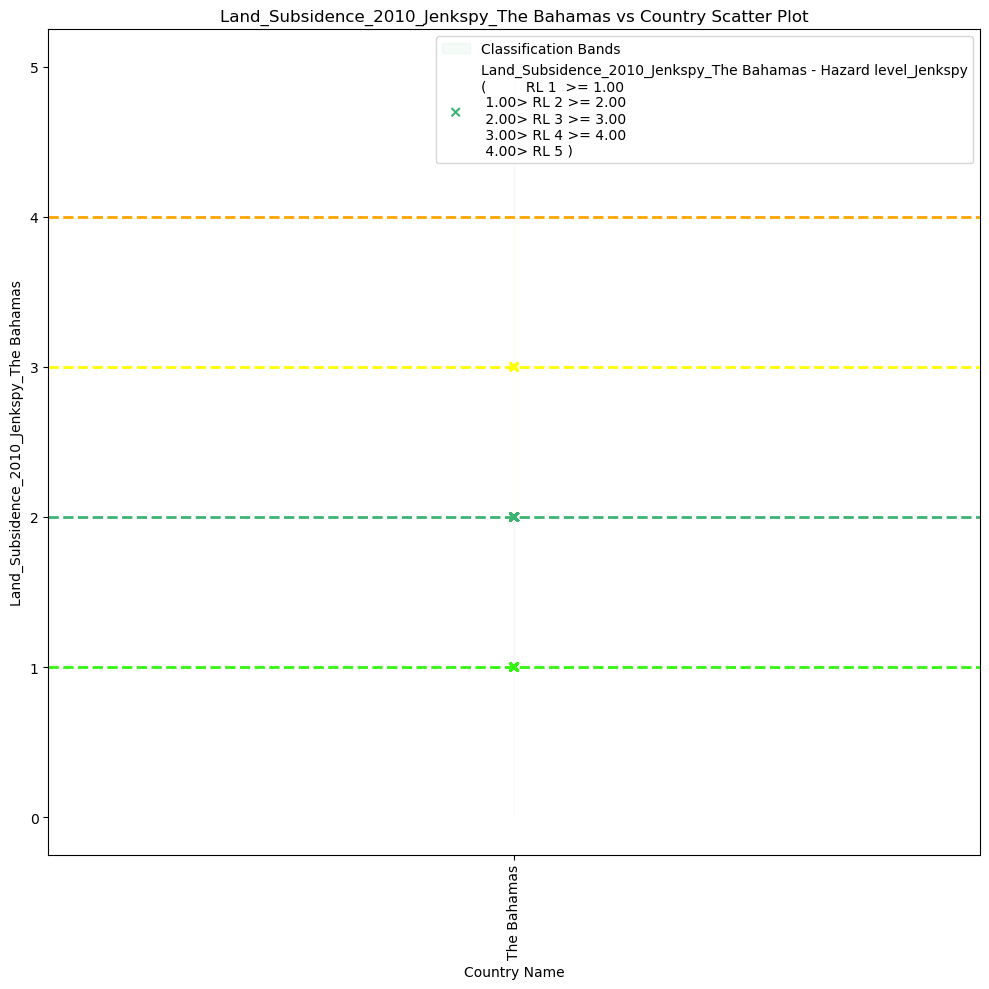

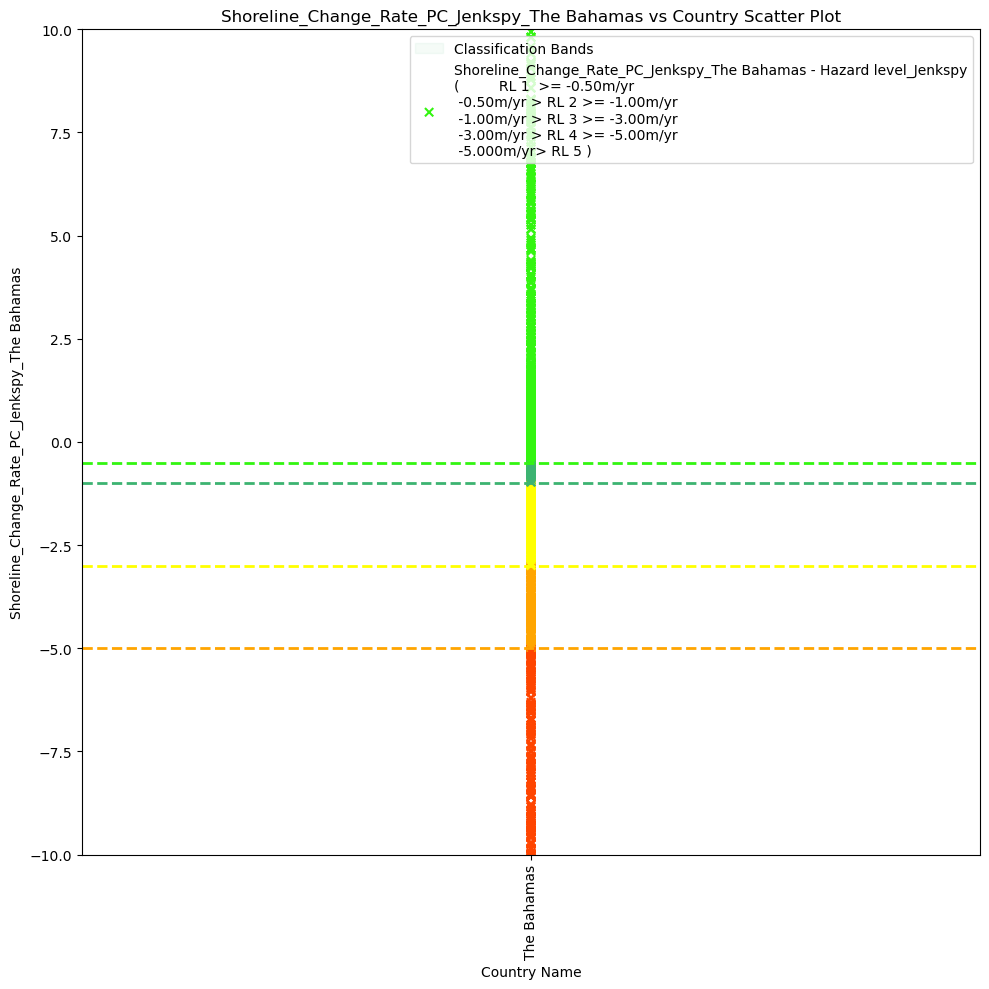

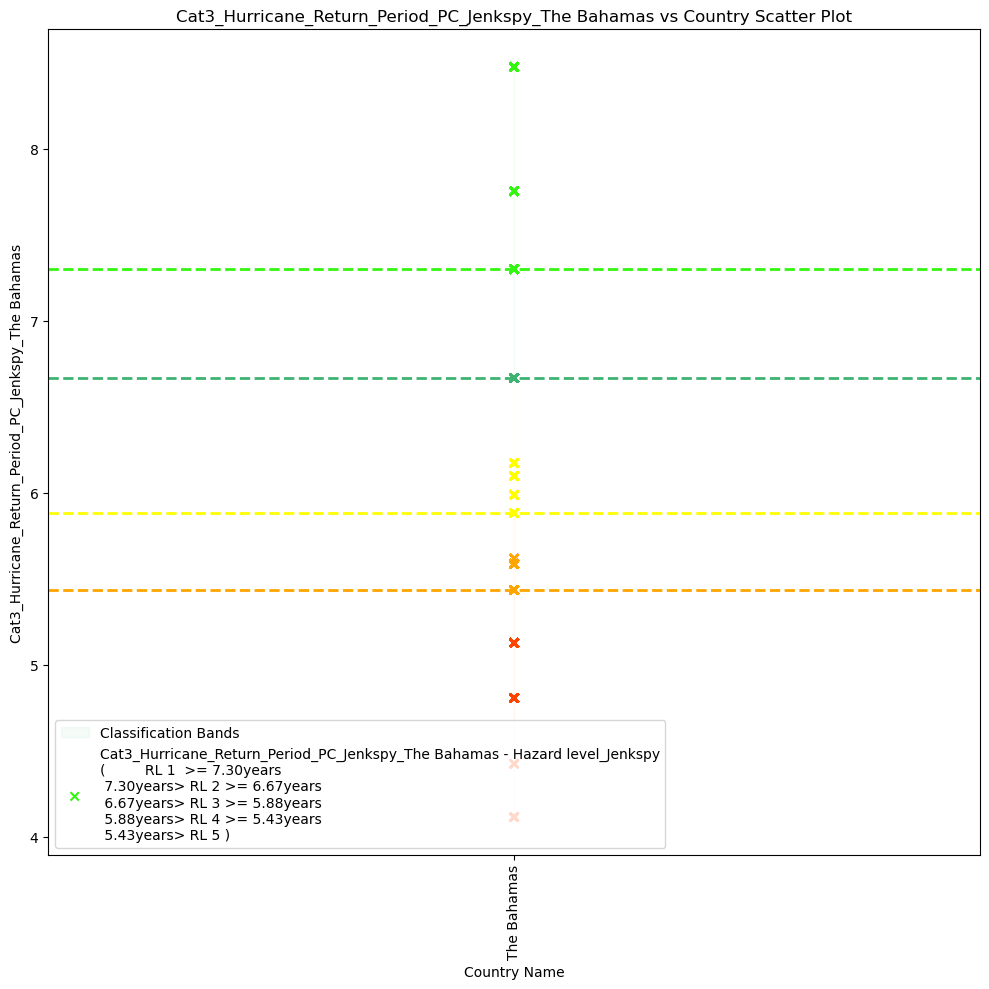

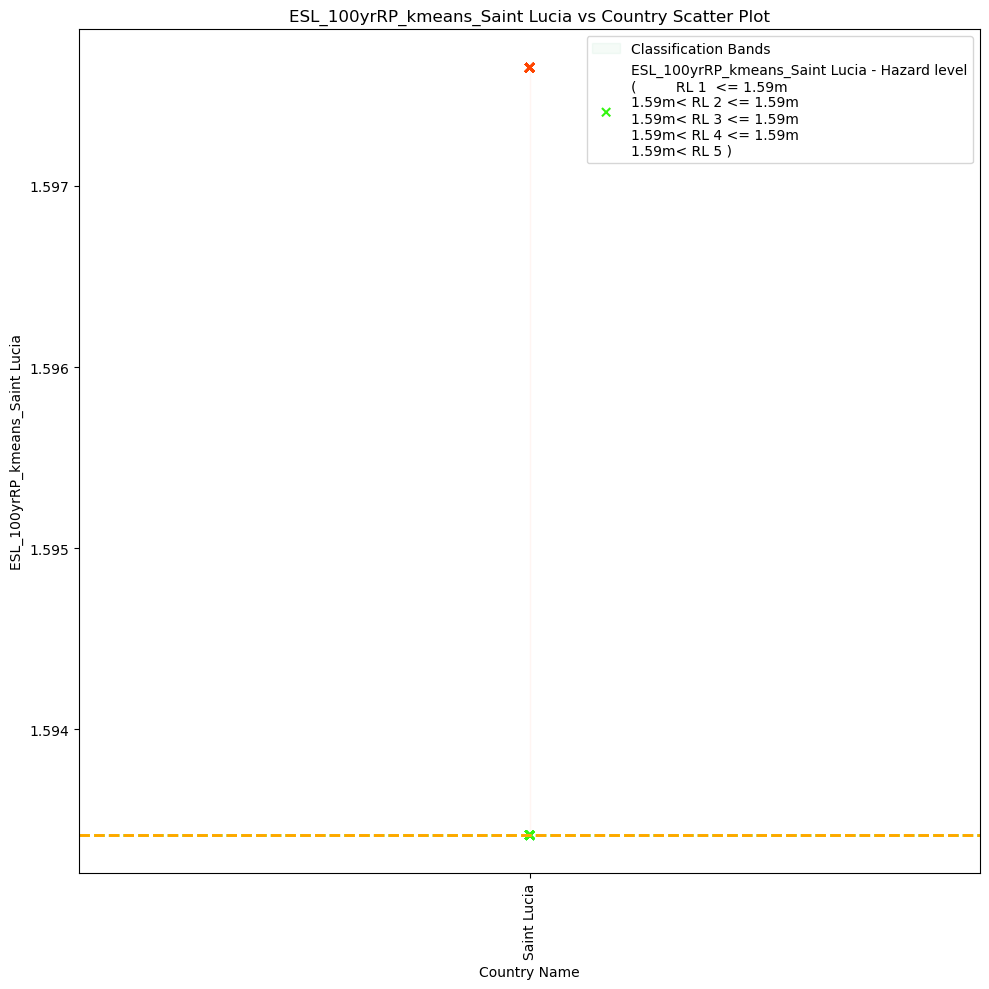

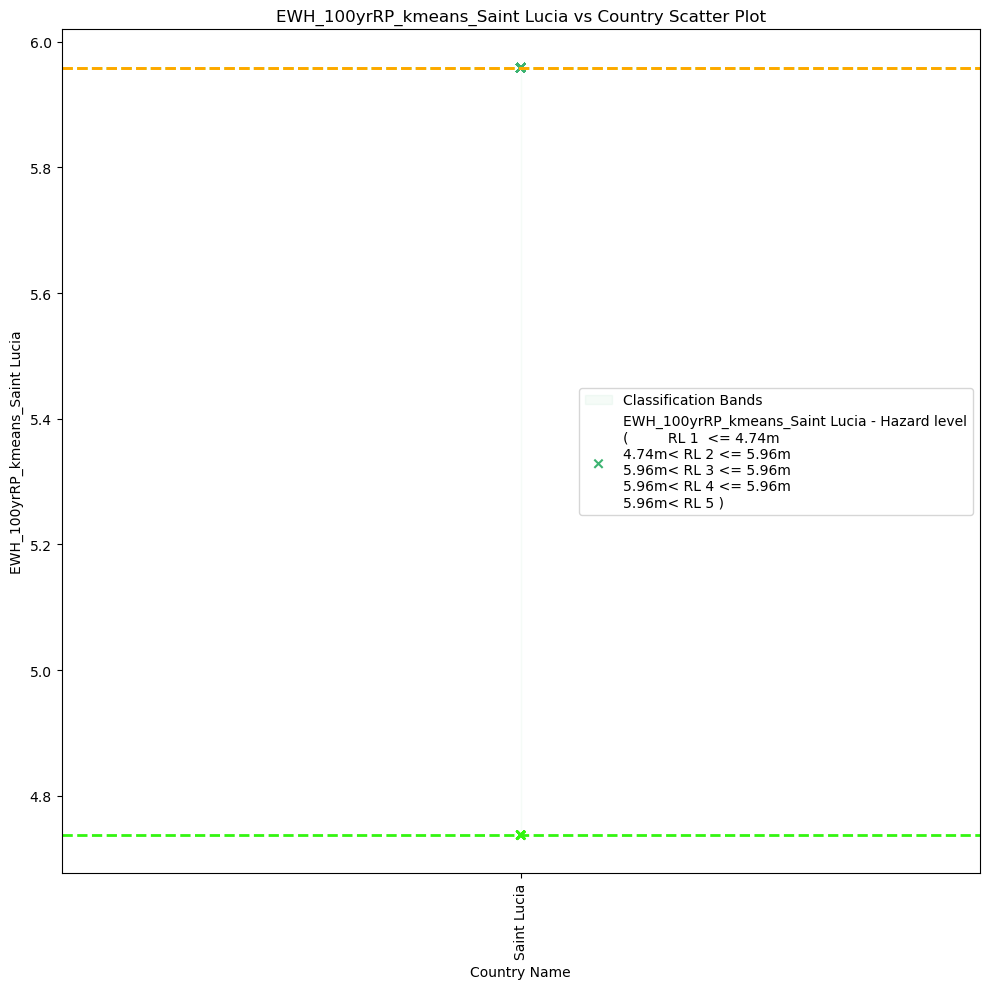

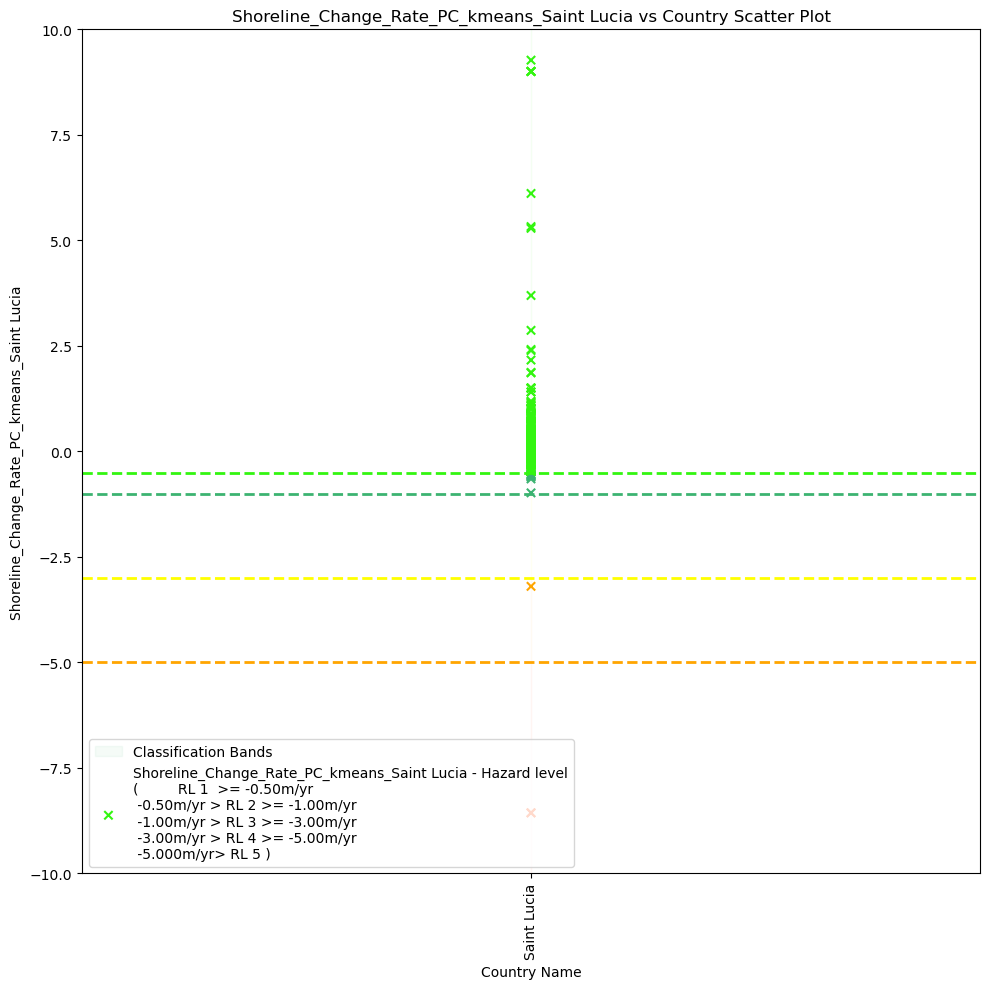

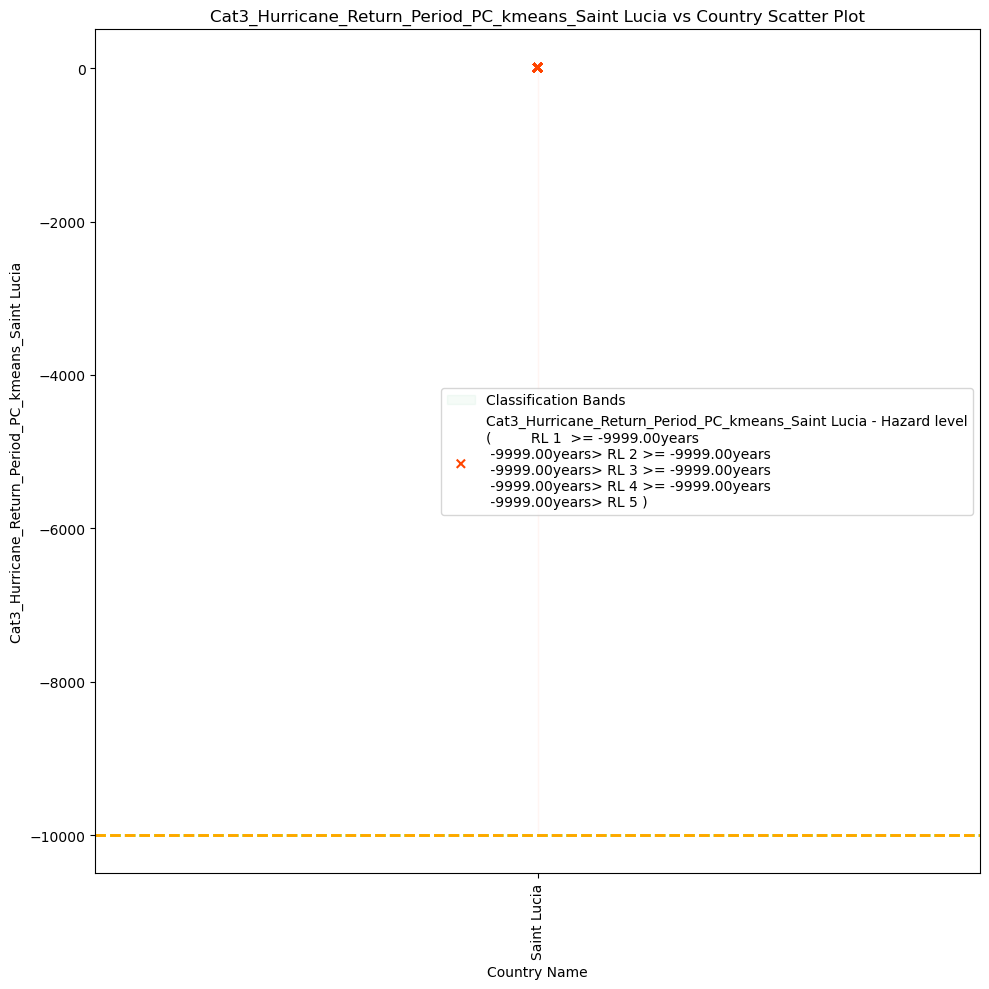

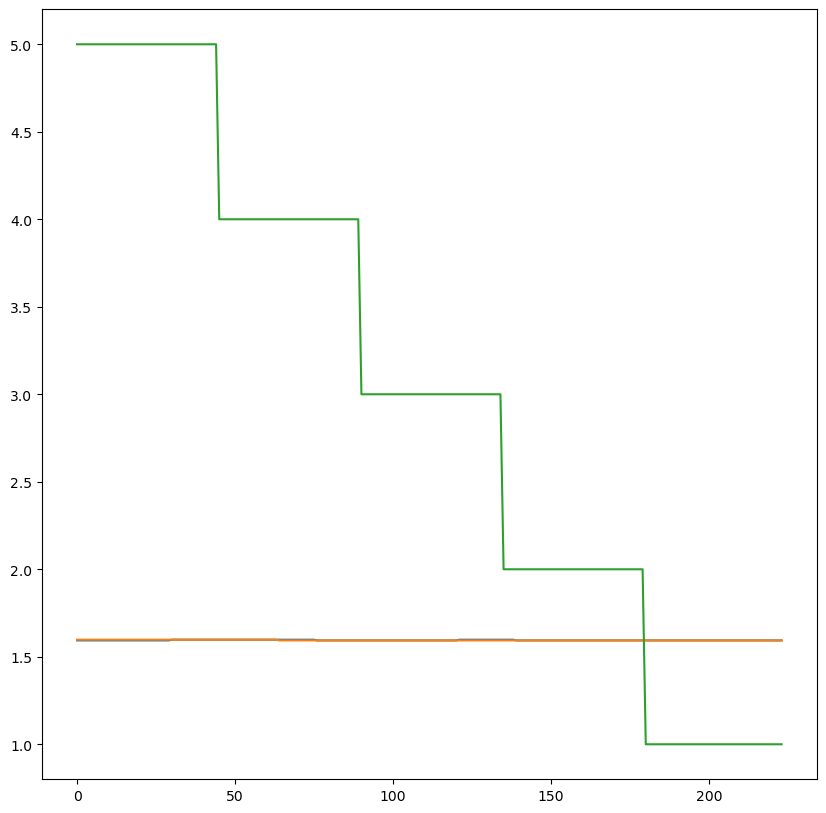

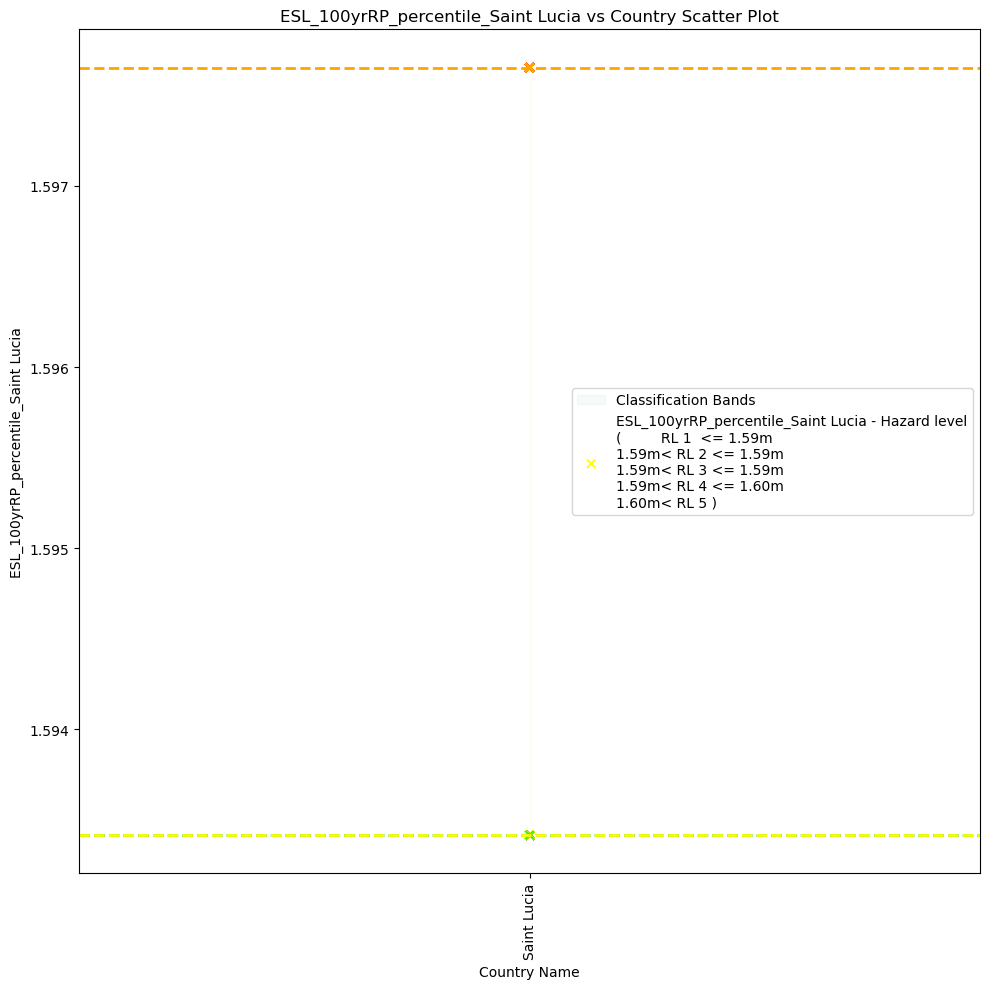

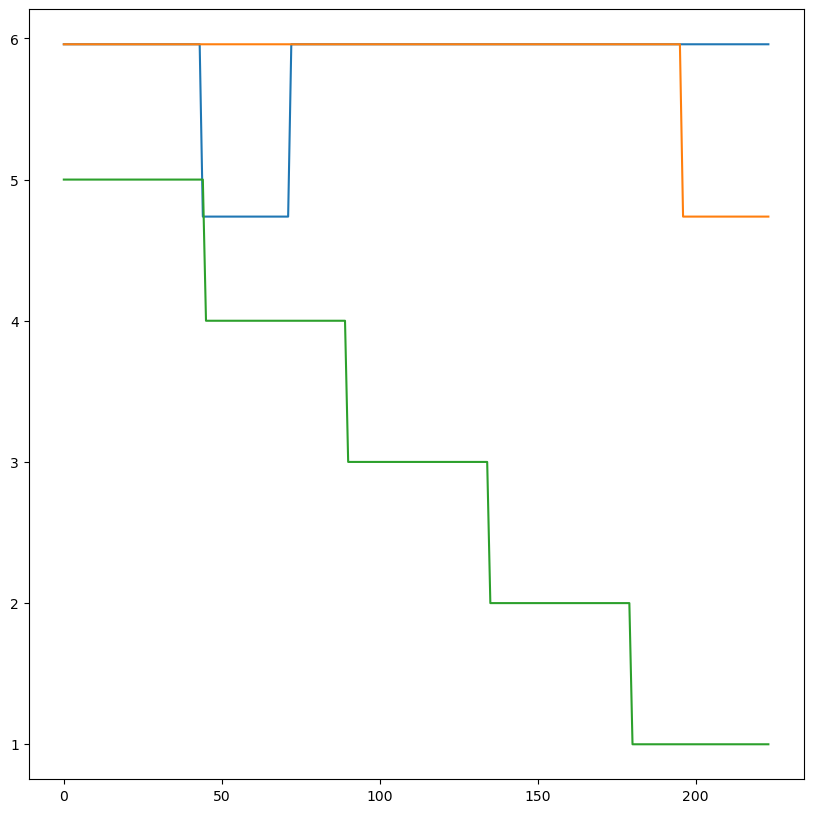

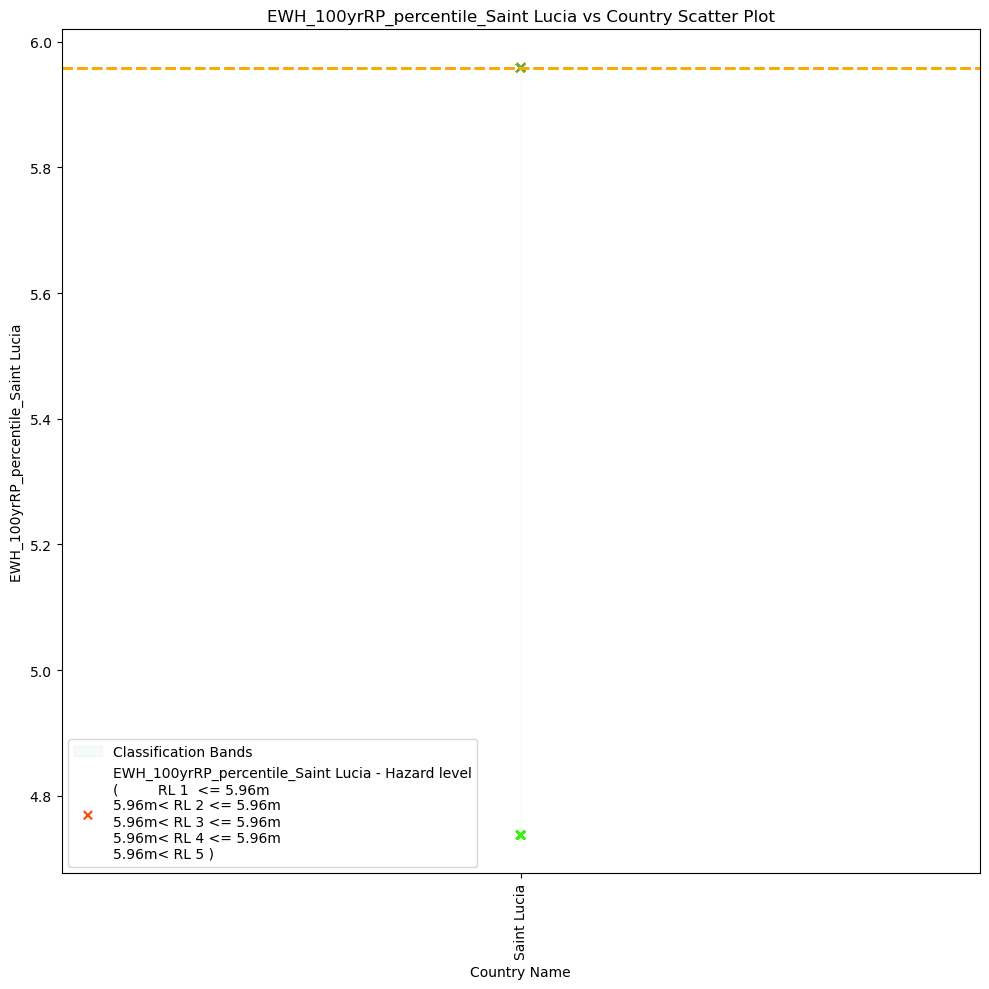

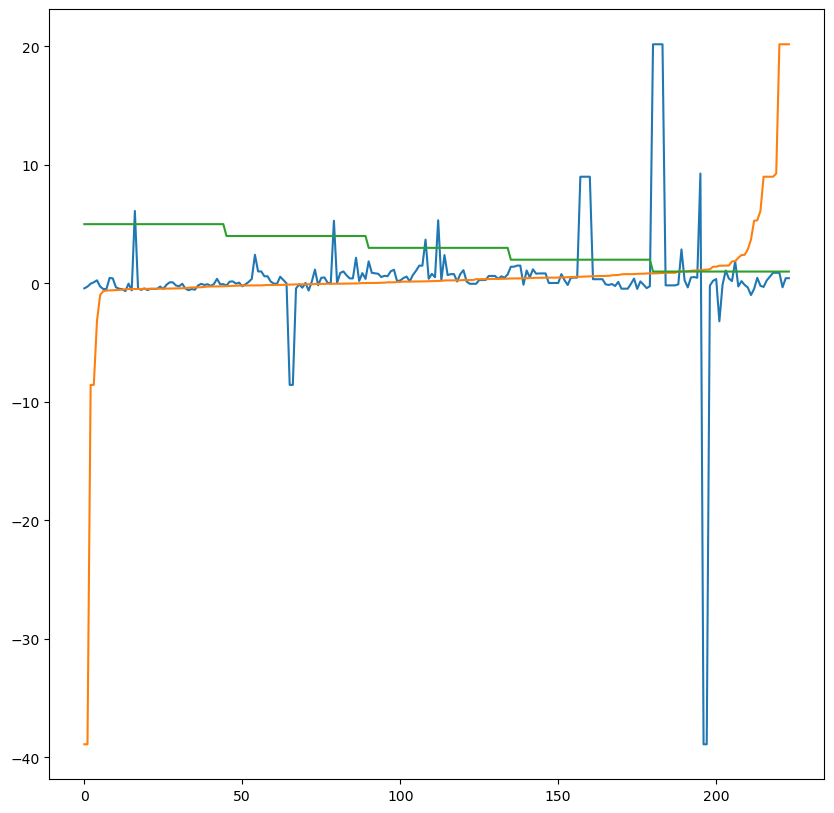

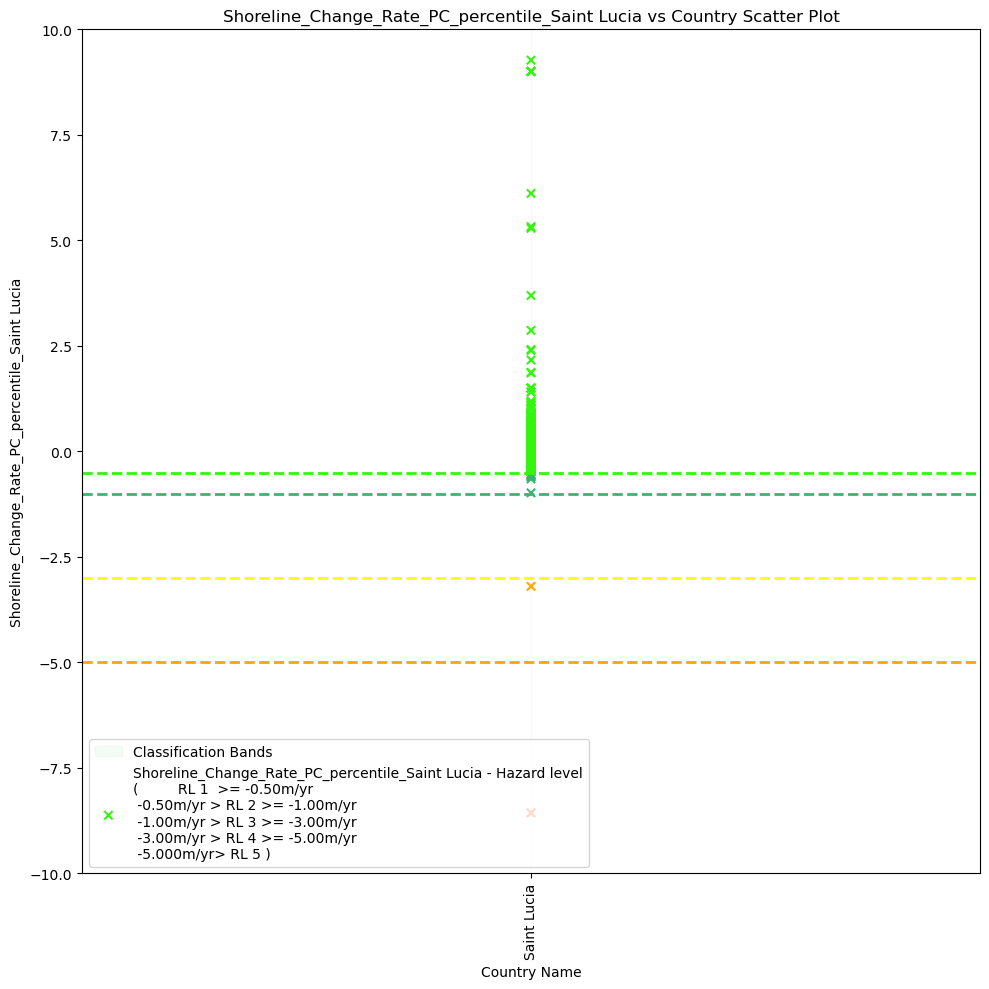

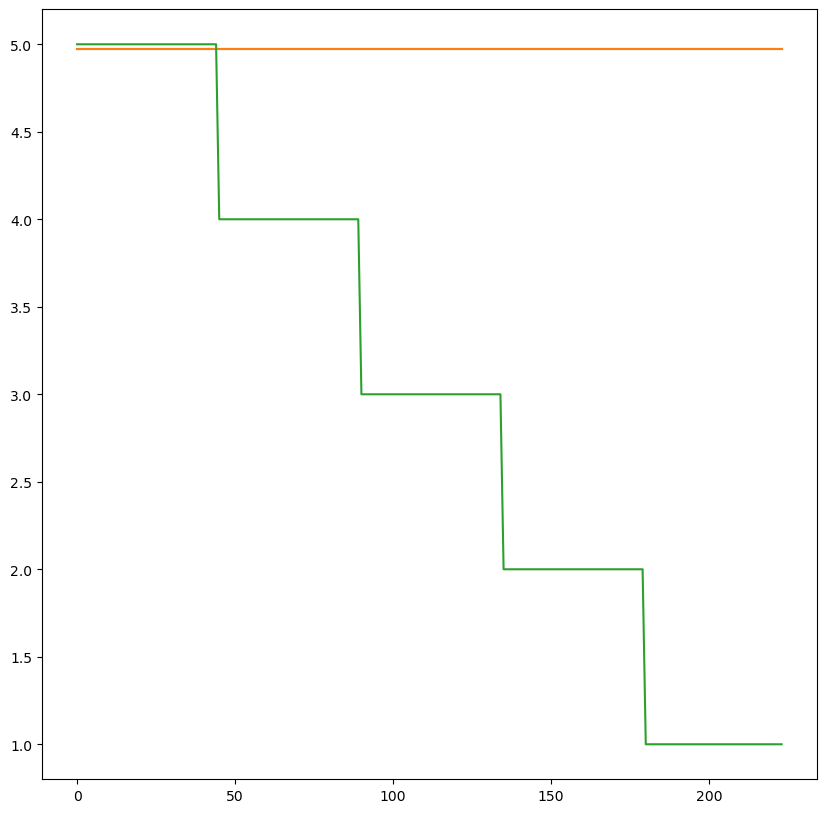

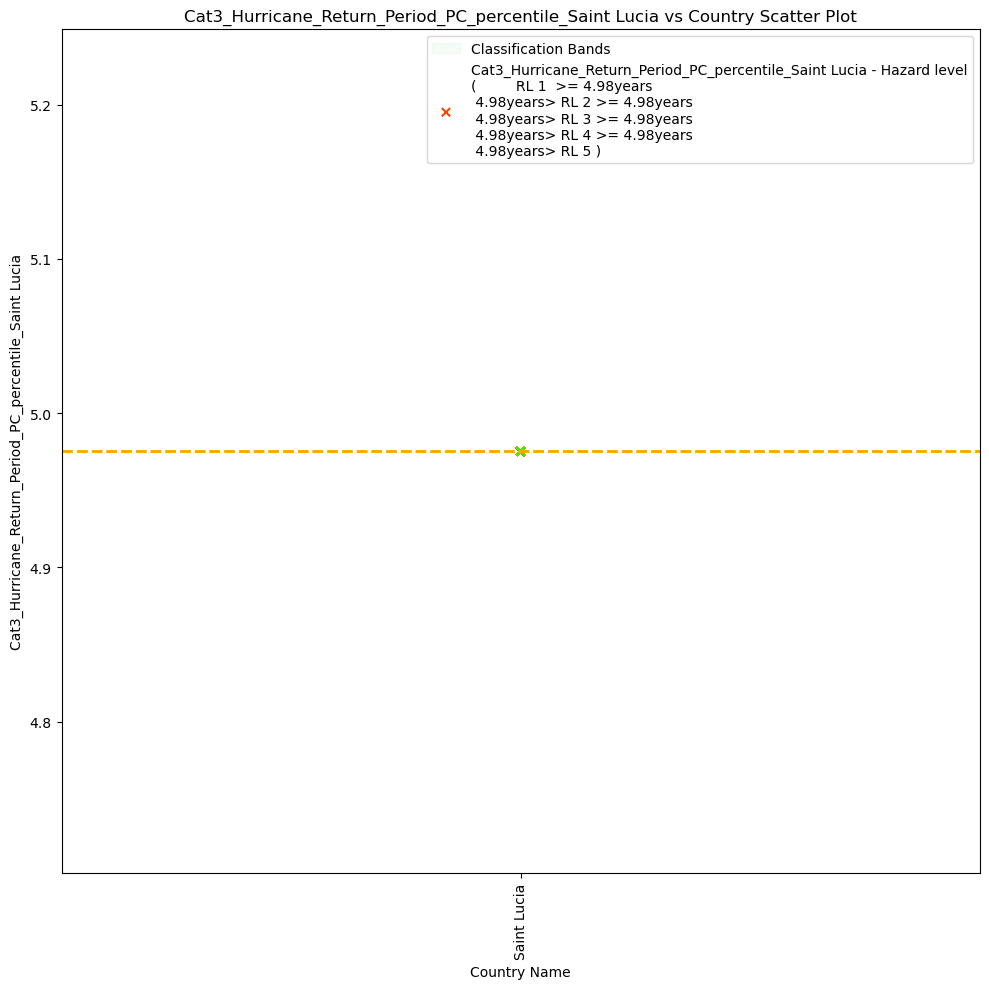

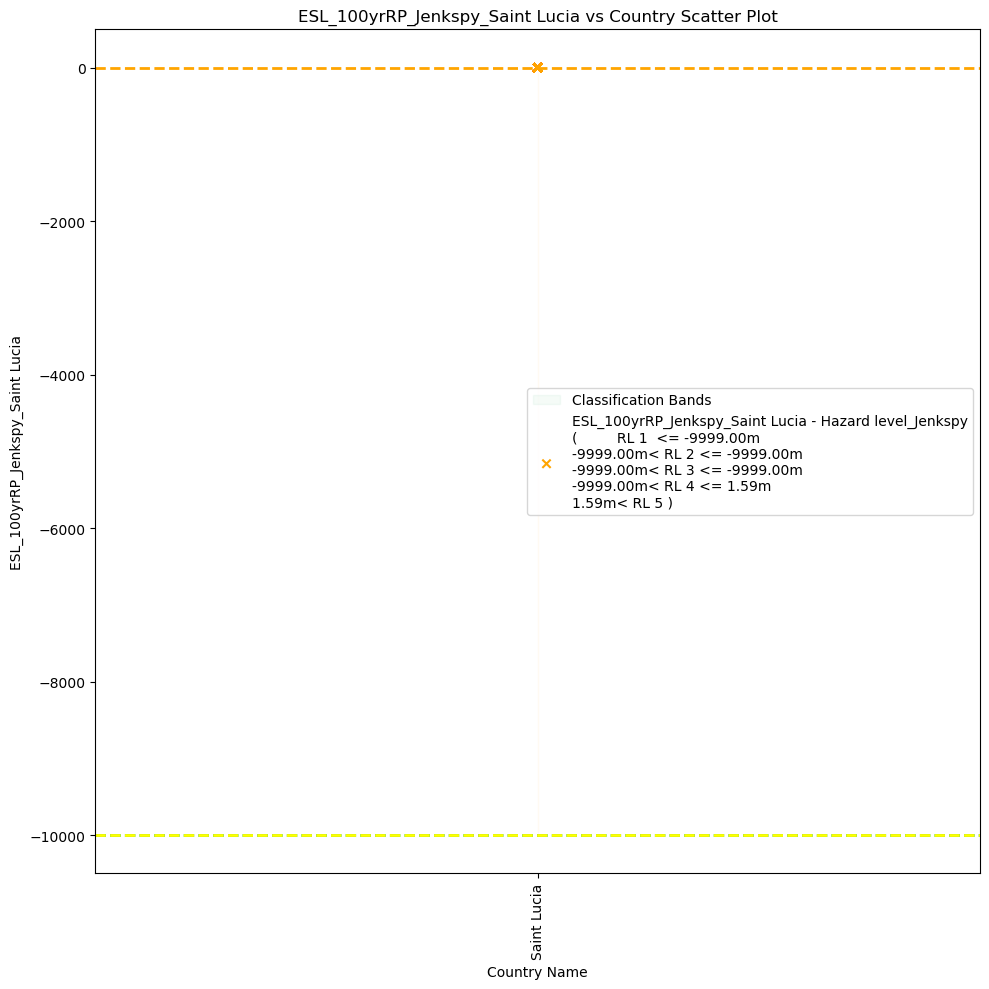

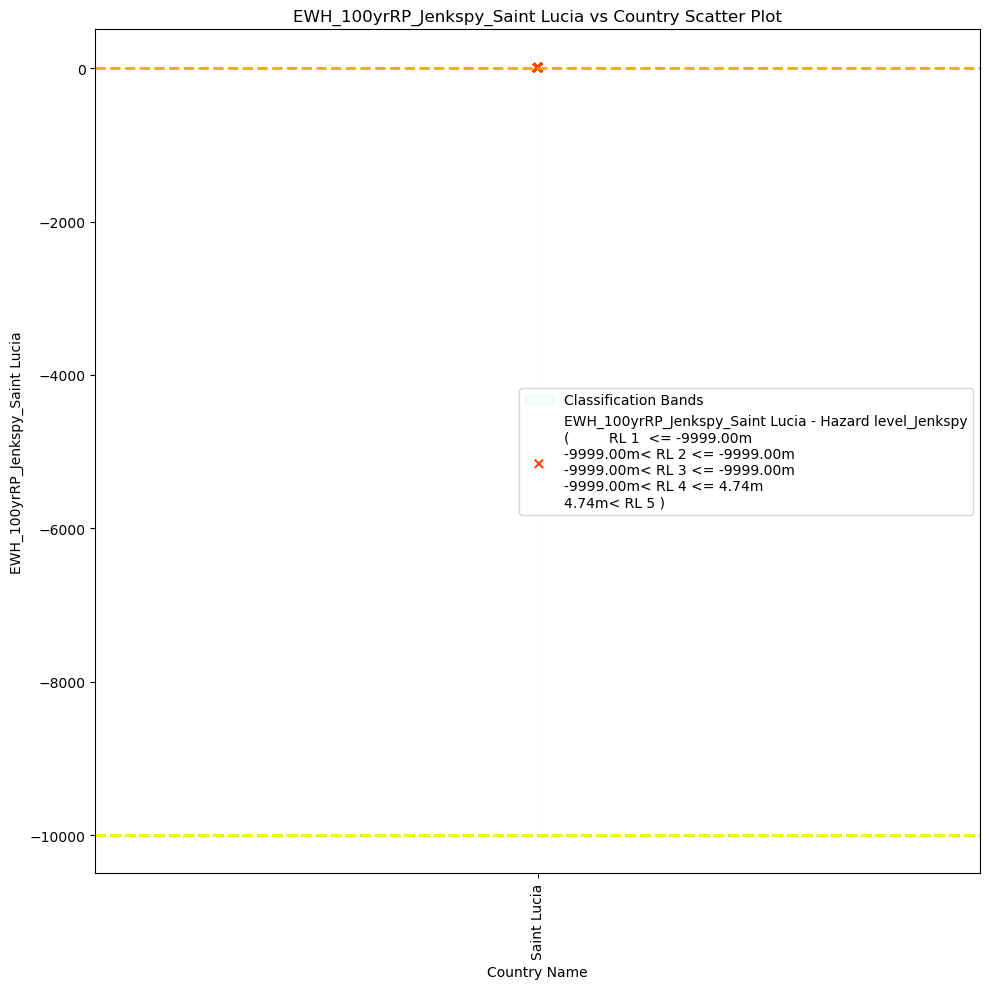

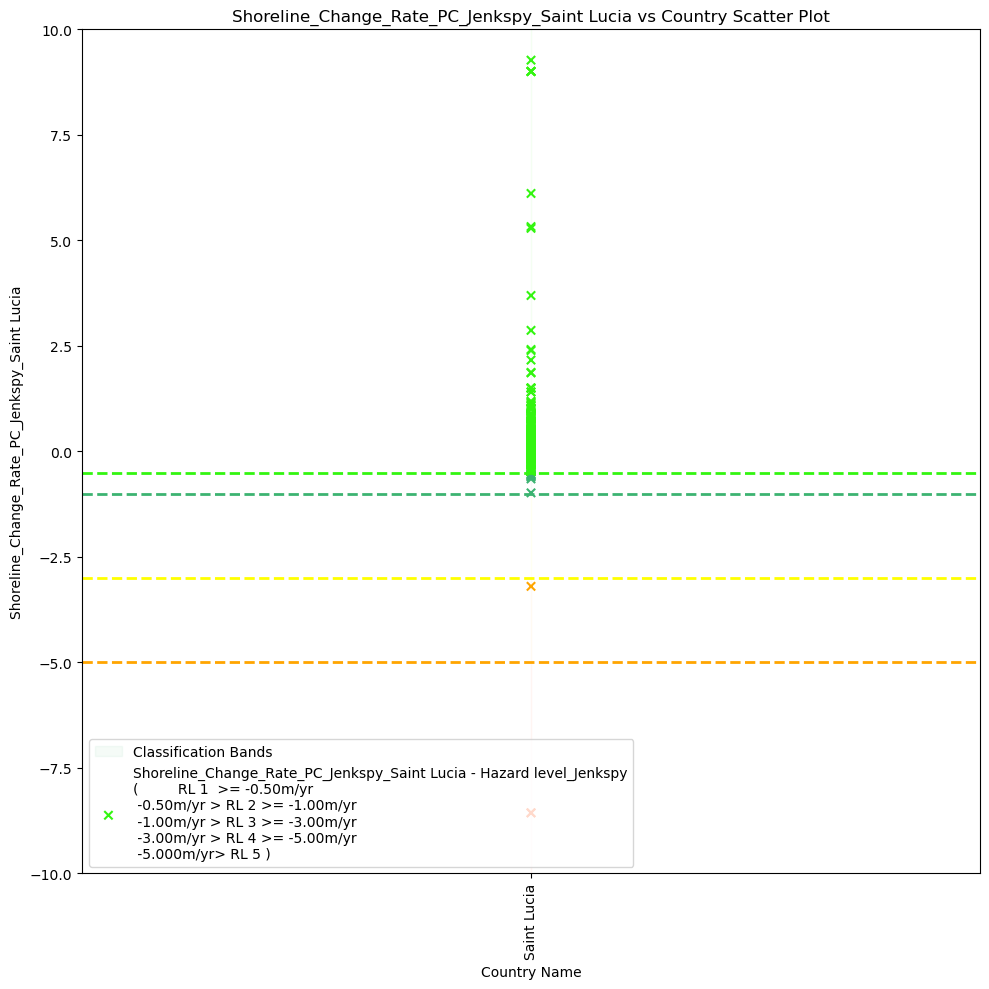

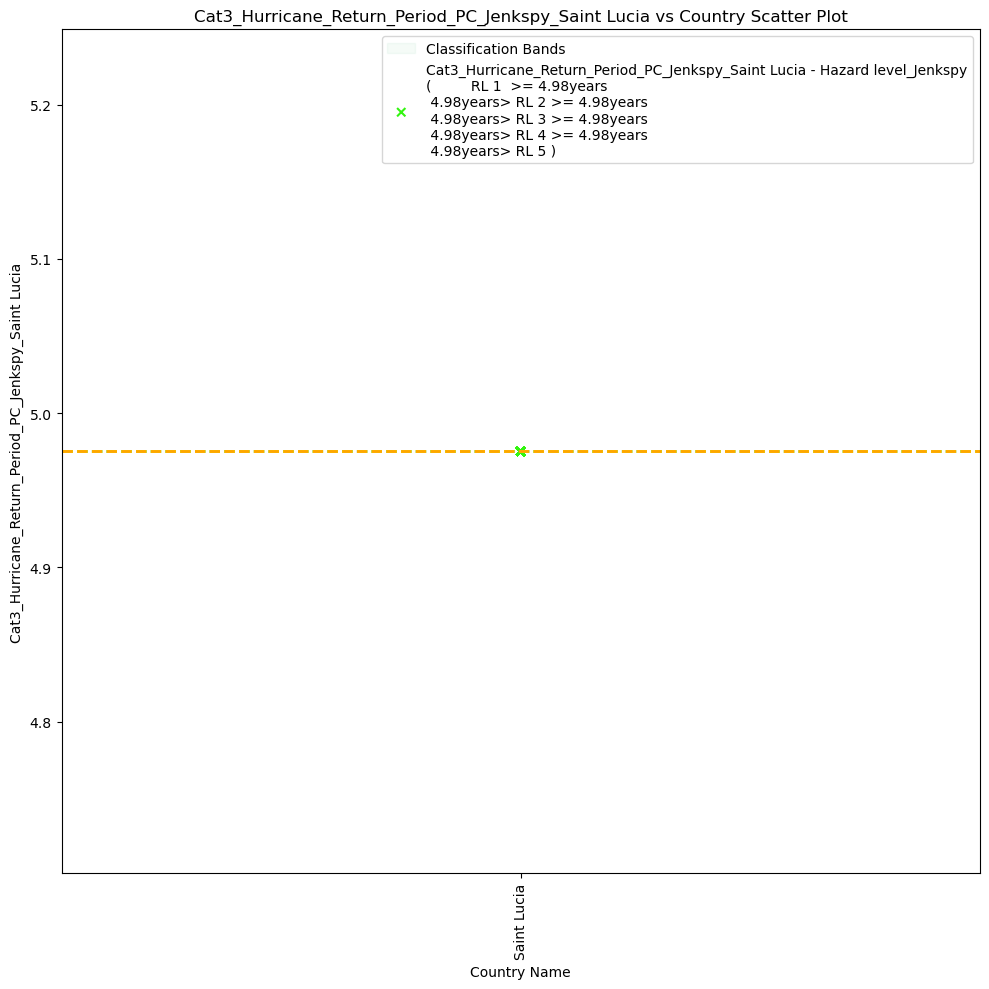

In [43]:
for zoom,country in zip(zoom_levels,countries):

    #Filter for the coutry
    circle_center_storage=circle_center_storage_orig.loc[circle_center_storage_orig["country_name"]==country,:]
    circle_center_storage.index=range(0,len(circle_center_storage.index))
    circle_center=circle_center_storage.copy()
    
    country_path=pathlib.Path.joinpath(Path(directory_path_main),country)
    country_path.mkdir(parents=True, exist_ok=True)
    directory_path=country_path

    txt_file_dir=pathlib.Path.joinpath(Path(directory_path),"Hazard Classes PC")
    txt_file_dir.mkdir(parents=True, exist_ok=True)

    img_lat = np.mean(circle_center_storage["geometry"].y)
    img_lon = np.mean(circle_center_storage["geometry"].x)
    view_width = 10

    #####################################
    #####################################
    #           kmeans
    #####################################
    #####################################


    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    import numpy as np

    circle_center_final_export=circle_center_storage.copy()

    # # in the case of *DIRECTLY* proportional variable increase to proportional exposure level increase
    # #eg wave heaight higher Hs the Higher the risk


    # in the case of *INVERSELY *proportional variable increase to proportional exposure level increase
    #eg Nearshore slope : higher tanB(m) the lower the risk
    inverse_map=[False,False,False,True,True]
    predifined_map=[False,False,True,True,False] #Expert based class?
    units=["m","m","","m/yr","years"]
    short_name= ["ESL_100yrRP_kmeans"+"_"+country,"EWH_100yrRP_kmeans"+"_"+country,"Land_Subsidence_2010_kmeans"+"_"+country,"Shoreline_Change_Rate_PC_kmeans"+"_"+country,"Cat3_Hurricane_Return_Period_PC_kmeans"+"_"+country]


    #Renames the columns
    circle_center.columns.values[4:9]=short_name

    for i,col_num in enumerate(range(4,9)):
        # col_num=2

        # distance_Exposure = pd.concat([pd.DataFrame(circle_center.index),circle_center.iloc[:, col_num]], axis=1) #Check grouping by country soon circle_center.iloc[:, 3]
        distance_Exposure = pd.concat([circle_center.iloc[:, 3],circle_center.iloc[:, col_num]], axis=1) #Check grouping by country soon circle_center.iloc[:, 3]

        # Slice the DataFrame to exclude 'geometry', 'x', and 'y' columns
        other_columns = distance_Exposure 

        # Concatenate the 'geometry' column with the other columns
        circle_center_nans = gpd.GeoDataFrame(geometry=circle_center.geometry, data=other_columns)



        #STEP 2 KMEANS CLUSTERING

        inverse=inverse_map[i]
        predifined=predifined_map[i]
        unit=units[i]


        color_scale = ['#33f510','#3CB371','#FFFF00', '#FFA500','#FF4500']


        # Create a new DataFrame without NaNs (for clustering) Because Kmeans Cannot compute NaNs
        circle_center_nans = circle_center_nans.dropna().copy()

        if len(circle_center_nans.iloc[:,0])==0:
            print("no points for " + short_name[i])
            long_name=short_name[i]+ " - Hazard level"
            circle_center_final_export[long_name]=3
            continue    

            
        # Fit KMeans clustering to the 3rd column variables
        kmeans = KMeans(n_clusters=5, random_state=42)
        kmeans.fit(circle_center_nans.iloc[:, 1:2])   # Fit the only two columns

        # kmeans.cluster_centers_ = np.sort(kmeans.cluster_centers_, axis=0)

        # Add kmeans.labels_ as a new column to circle_center_nans
        long_name=short_name[i]+ " - Hazard level"
        circle_center_nans[long_name] = kmeans.labels_ + 1




        # STEP 3 Kmeans sometimes does not rank the clusters proportional ie in increasing order
        # So we have to manually check and re-sort/re-rank
    

        a=kmeans.cluster_centers_
        p = np.sort(a, axis=0)
        levels=np.array([1,2,3,4,5]).reshape(-1, 1)


        p = np.concatenate((p, a,levels), axis=1)
        kmeansissue = pd.DataFrame(p, columns=[f'Column_{i}' for i in range(p.shape[1])])
        kmeansissue['Rank'] = kmeansissue['Column_1'].rank(method='min')

        if inverse:
            # Define the mapping dictionary
            rank_mapping = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

            # Map the ranks using the dictionary
            kmeansissue['Rank'] = kmeansissue['Rank'].map(rank_mapping)

        # REWRITE TO THE EXPOSURE LEVEL COLUMN
            

        # Map ranks to NS-Exposure level
        rank_to_exposure = kmeansissue.set_index('Column_2')['Rank'].to_dict()
        circle_center_nans[long_name] = circle_center_nans[long_name].map(rank_to_exposure).astype(int)





        ######################################################
        # Notation for Risk level Classes
        #####################################################
        if not predifined:
            if inverse:

                try:
                    RL0=circle_center_nans[circle_center_nans[long_name]==1].loc[:,short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL0 = -9999
                try:
                    RL1 = circle_center_nans[circle_center_nans[long_name] == 1].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL1 = -9999
                try:
                    RL2 = circle_center_nans[circle_center_nans[long_name] == 2].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL2 = RL1
                try:
                    RL3 = circle_center_nans[circle_center_nans[long_name] == 3].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL3 = RL2
                try:
                    RL4 = circle_center_nans[circle_center_nans[long_name] == 4].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL4 = RL3
                try:
                    RL5 = circle_center_nans[circle_center_nans[long_name] == 5].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL5 = RL4
                class_text=f"(         RL 1  >= {RL1:.2f}{unit} \n {RL1:.2f}{unit}> RL 2 >= {RL2:.2f}{unit} \n {RL2:.2f}{unit}> RL 3 >= {RL3:.2f}{unit} \n {RL3:.2f}{unit}> RL 4 >= {RL4:.2f}{unit} \n {RL4:.2f}{unit}> RL 5 )"

            if not inverse:
                try:
                    RL0=circle_center_nans[circle_center_nans[long_name]==1].loc[:,short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL0 = -9999
                try:
                    RL1 = circle_center_nans[circle_center_nans[long_name] == 1].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL1 = -9999
                try:
                    RL2 = circle_center_nans[circle_center_nans[long_name] == 2].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL2 = RL1
                try:
                    RL3 = circle_center_nans[circle_center_nans[long_name] == 3].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL3 = RL2
                try:
                    RL4 = circle_center_nans[circle_center_nans[long_name] == 4].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL4 = RL3
                try:
                    RL5 = circle_center_nans[circle_center_nans[long_name] == 5].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL5 = RL4
                class_text = f"(         RL 1  <= {RL1:.2f}{unit} \n{RL1:.2f}{unit}< RL 2 <= {RL2:.2f}{unit} \n{RL2:.2f}{unit}< RL 3 <= {RL3:.2f}{unit} \n{RL3:.2f}{unit}< RL 4 <= {RL4:.2f}{unit} \n{RL4:.2f}{unit}< RL 5 )"
        
        if predifined and "Shoreline_Change_Rate_PC" in short_name[i]:
            RL0=10
            RL1=-0.5
            RL2=-1
            RL3=-3
            RL4=-5
            RL5=-10
        
            circle_center_nans.loc[circle_center_nans[short_name[i]] >= RL1, long_name] = 1
            circle_center_nans.loc[(circle_center_nans[short_name[i]] < RL1) & (circle_center_nans[short_name[i]] >= RL2), long_name] = 2
            circle_center_nans.loc[(circle_center_nans[short_name[i]] < RL2) & (circle_center_nans[short_name[i]] >= RL3), long_name] = 3
            circle_center_nans.loc[(circle_center_nans[short_name[i]] < RL3) & (circle_center_nans[short_name[i]] >= RL4), long_name] = 4
            circle_center_nans.loc[circle_center_nans[short_name[i]] < RL4, long_name] = 5





            class_text=f"(         RL 1  >= {RL1:.2f}{unit} \n {RL1:.2f}{unit} > RL 2 >= {RL2:.2f}{unit} \n {RL2:.2f}{unit} > RL 3 >= {RL3:.2f}{unit} \n {RL3:.2f}{unit} > RL 4 >= {RL4:.2f}{unit} \n {RL4:.2f}0{unit}> RL 5 )"
        
        if predifined and "Sediment Type" in short_name[i]  or "Land_Subsidence" in short_name[i]:
            RL0=0
            RL1=1
            RL2=2
            RL3=3
            RL4=4
            RL5=5
            

            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL1, long_name] = 1
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL2, long_name] = 2
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL3, long_name] = 3
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL4, long_name] = 4
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL5, long_name] = 5

            class_text=f"(         RL 1  = Cliff \n RL 2 = Vegetated \n RL 3 = Other \n RL 4 = Sand  \n RL 5   = Mud)"

            if  "Land_Subsidence" in short_name[i]:
                    class_text=f"(         RL 1  >= {RL1:.2f}{unit} \n {RL1:.2f}{unit}> RL 2 >= {RL2:.2f}{unit} \n {RL2:.2f}{unit}> RL 3 >= {RL3:.2f}{unit} \n {RL3:.2f}{unit}> RL 4 >= {RL4:.2f}{unit} \n {RL4:.2f}{unit}> RL 5 )"


        #Plot the cluster distribution scatter plot
        plt.figure(figsize=(10, 10))

        point_colors = [color_scale[label] for label in circle_center_nans[long_name]-1]

        ############
        # Plot Risk Level Separators fill between
        ############
        hue=color_scale
        # if inverse:
        #     hue=color_scale[::-1]

        
        plt.axhline(RL1, color=hue[0], linestyle='--',linewidth=2)
        plt.axhline(RL2, color=hue[1], linestyle='--',linewidth=2)
        plt.axhline(RL3, color=hue[2], linestyle='--',linewidth=2)
        plt.axhline(RL4, color=hue[3], linestyle='--',linewidth=2)

        alpha=0.05
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL0,y2= RL1, color=hue[0], alpha=alpha)
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL1,y2= RL2, color=hue[1], alpha=alpha,label='Classification Bands')
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL2,y2= RL3, color=hue[2], alpha=alpha)
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL3, y2=RL4, color=hue[3], alpha=alpha)
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL4,y2= RL5, color=hue[4], alpha=alpha)
        
    



        # Plot original data points with custom colors
        plt.scatter(circle_center_nans.iloc[:, 0], circle_center_nans.iloc[:, 1], c=point_colors, marker='x', label=long_name +f"\n{class_text}")

        # Plot cluster centroids
        # plt.scatter((circle_center_nans.iloc[-1, 0]/2)*(kmeans.cluster_centers_[:, 0]/kmeans.cluster_centers_[:, 0]), kmeans.cluster_centers_[:, 0], s=120, c='red', marker='o', label='Cluster Centroids')


        # Plot cluster centroids by country
        # plt.scatter([circle_center_nans.iloc[len(circle_center_nans.index)//2,0]]*len(kmeans.cluster_centers_), kmeans.cluster_centers_[:, 0], s=120, c='red', marker='o', label='Cluster Centroids')

        # Add labels and legend
        plt.xlabel('Country Name')
        plt.ylabel(short_name[i])
        plt.title(short_name[i]+' vs Country Scatter Plot')
        plt.legend()

        # Rotate x-axis labels
        plt.xticks(rotation=90)
        if "Shoreline_Change_Rate_PC" in short_name[i]:
            plt.ylim(-10,10)

        # Adjust layout
        plt.tight_layout()
        # plt.show()
    
        fig_name_scatter=short_name[i]+' cluster_class_plot.png'
        plt.savefig(os.path.join(directory_path, fig_name_scatter)) 

        #############################################################
                # Saving Classess
        ############################################################
        # Define the file path where you want to save the text file
        file_path = short_name[i]+' cluster_class.txt'

        # Open the file in write mode and write the string to it
        with open(os.path.join(directory_path,"Hazard Classes PC", file_path), "w") as text_file:
            text_file.write(class_text)



        # plt.close()


        #Create GPD circle_center_final with all the information of the different exposure levels
        circle_center_final=circle_center
        circle_center_final = circle_center_final.merge(circle_center_nans[['geometry', long_name]], on='geometry', how='left')
        circle_center_final


    ##################################################################################################
    # Caribbean zoom
    ##################################################################################################
        Risk_level_name= long_name + " name"
        # color_scale = ['#33f510','#3CB371','#FFFF00', '#FFA500','#FF4500']
        label_dict = {
        1: "Very Low",
        2: "Low",
        3: "Medium",
        4: "High",
        5: "Very High"}

        colors = {'Very Low': '#33f510', 'Low': '#3CB371', 'Medium': '#FFFF00', 'High': '#FFA500', 'Very High': '#FF4500'}

    

        sorted_CCN=circle_center_final.sort_values(long_name)
        # Create scatter map plot
        fig_region = px.scatter_mapbox(sorted_CCN,
                                lat=sorted_CCN["geometry"].y,
                                lon=sorted_CCN["geometry"].x,
                                hover_name=short_name[i],
                                color=sorted_CCN[long_name].replace(label_dict),
                                color_discrete_map=colors,
                                mapbox_style="carto-positron",width=2000,
                                height=1200)


        # Update map layout to adjust center and zoom
        fig_region.update_layout(mapbox=dict(center=dict(lat=img_lat, lon=img_lon), zoom=zoom),
                        title=f"{long_name} Hazard Distribution along Caribbean's shoreline")
        
        fig_region.update_layout(legend=dict(
        traceorder='normal',
        title=long_name,
        title_font=dict(size=14),
        itemsizing='constant',))
        # fig_region.show()
        
        fig_name_shoreline=short_name[i]+' shoreline_plot.png'
        pio.write_image(fig_region, os.path.join(directory_path, fig_name_shoreline))


        circle_center_final_export[long_name]= circle_center_final[long_name]

        del kmeans
        del RL0,RL1,RL2,RL3,RL4,RL5
    
    circle_center_final_export.to_csv(pathlib.Path.joinpath(Path(directory_path),country+"_kmeans.csv"),index=False)

    
    #####################################
    #####################################
    #Percentile Classification
    #####################################
    #####################################
    circle_center=circle_center_storage.copy()
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    import numpy as np

    circle_center_final_export=circle_center.copy()

    # # in the case of *DIRECTLY* proportional variable increase to proportional exposure level increase
    # #eg wave heaight higher Hs the Higher the risk


    # in the case of *INVERSELY *proportional variable increase to proportional exposure level increase
    #eg Nearshore slope : higher tanB(m) the lower the risk
    inverse_map=[False,False,False,True,True]
    predifined_map=[False,False,True,True,False] #Expert based class?
    units=["m","m","","m/yr","years"]
    short_name= ["ESL_100yrRP_percentile"+"_"+country,"EWH_100yrRP_percentile"+"_"+country,"Land_Subsidence_2010_percentile"+"_"+country,"Shoreline_Change_Rate_PC_percentile"+"_"+country,"Cat3_Hurricane_Return_Period_PC_percentile"+"_"+country]


    #Renames the columns
    circle_center.columns.values[4:9]=short_name

    for i,col_num in enumerate(range(4,9)):
        # col_num=2

        distance_Exposure = pd.concat([pd.DataFrame(circle_center.index),circle_center.iloc[:, col_num]], axis=1) #Check grouping by country soon circle_center.iloc[:, 3]
        distance_Exposure = pd.concat([circle_center.iloc[:, 3],circle_center.iloc[:, col_num]], axis=1) #Check grouping by country soon circle_center.iloc[:, 3]

        # Slice the DataFrame to exclude 'geometry', 'x', and 'y' columns
        other_columns = distance_Exposure 

        # Concatenate the 'geometry' column with the other columns
        circle_center_nans = gpd.GeoDataFrame(geometry=circle_center.geometry, data=other_columns)
    	
  

        inverse=inverse_map[i]
        predifined=predifined_map[i]
        unit=units[i]


        color_scale = ['#33f510','#3CB371','#FFFF00', '#FFA500','#FF4500']


        ######################################################
        # Percentile classification
        #####################################################

            # Create a new DataFrame without NaNs (for clustering) Because Kmeans Cannot compute NaNs
        circle_center_nans = circle_center_nans.dropna().copy()

        if len(circle_center_nans.iloc[:,0])==0:
            print("no points for " + short_name[i])
            long_name=short_name[i]+ " - Hazard level"
            circle_center_final_export[long_name]=3
            continue    



        long_name=short_name[i]+ " - Hazard level"

        circle_center_nans


        circle_center_nans_sorted=circle_center_nans.sort_values(by=short_name[i],ascending=inverse).copy()

        circle_center_nans_sorted[long_name]=1

        count=len(circle_center_nans_sorted.iloc[:,0])

        top=0
        gap=np.ceil(count*0.2).astype(int)
        for x in range(0,5):

            bottom=top+gap
            if bottom>count:
                bottom=count

            circle_center_nans_sorted.iloc[top:bottom,-1]=5-x

            top=bottom

        circle_center_nans_sorted

        plt.figure(figsize=(10, 10))
        plt.plot(circle_center_nans.index,circle_center_nans.iloc[:,1])
        plt.plot(circle_center_nans.index,circle_center_nans_sorted.iloc[:,1])
        plt.plot(circle_center_nans.index,circle_center_nans_sorted.iloc[:,-1])
        # plt.ylim(0,5)


        circle_center_nans=circle_center_nans_sorted.sort_index().copy()
        circle_center_nans



        ######################################################
        # Notation for Risk level Classes
        #####################################################
        if not predifined:
            if inverse:

                try:
                    RL0=circle_center_nans[circle_center_nans[long_name]==1].loc[:,short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL0 = -9999
                try:
                    RL1 = circle_center_nans[circle_center_nans[long_name] == 1].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL1 = -9999
                try:
                    RL2 = circle_center_nans[circle_center_nans[long_name] == 2].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL2 = RL1
                try:
                    RL3 = circle_center_nans[circle_center_nans[long_name] == 3].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL3 = RL2
                try:
                    RL4 = circle_center_nans[circle_center_nans[long_name] == 4].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL4 = RL3
                try:
                    RL5 = circle_center_nans[circle_center_nans[long_name] == 5].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL5 = RL4
                class_text=f"(         RL 1  >= {RL1:.2f}{unit} \n {RL1:.2f}{unit}> RL 2 >= {RL2:.2f}{unit} \n {RL2:.2f}{unit}> RL 3 >= {RL3:.2f}{unit} \n {RL3:.2f}{unit}> RL 4 >= {RL4:.2f}{unit} \n {RL4:.2f}{unit}> RL 5 )"

            if not inverse:
                try:
                    RL0=circle_center_nans[circle_center_nans[long_name]==1].loc[:,short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL0 = -9999
                try:
                    RL1 = circle_center_nans[circle_center_nans[long_name] == 1].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL1 = -9999
                try:
                    RL2 = circle_center_nans[circle_center_nans[long_name] == 2].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL2 = RL1
                try:
                    RL3 = circle_center_nans[circle_center_nans[long_name] == 3].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL3 = RL2
                try:
                    RL4 = circle_center_nans[circle_center_nans[long_name] == 4].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL4 = RL3
                try:
                    RL5 = circle_center_nans[circle_center_nans[long_name] == 5].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL5 = RL4
                class_text = f"(         RL 1  <= {RL1:.2f}{unit} \n{RL1:.2f}{unit}< RL 2 <= {RL2:.2f}{unit} \n{RL2:.2f}{unit}< RL 3 <= {RL3:.2f}{unit} \n{RL3:.2f}{unit}< RL 4 <= {RL4:.2f}{unit} \n{RL4:.2f}{unit}< RL 5 )"
        
        if predifined and "Shoreline_Change_Rate_PC" in short_name[i]:
            RL0=10
            RL1=-0.5
            RL2=-1
            RL3=-3
            RL4=-5
            RL5=-10
        
            circle_center_nans.loc[circle_center_nans[short_name[i]] >= RL1, long_name] = 1
            circle_center_nans.loc[(circle_center_nans[short_name[i]] < RL1) & (circle_center_nans[short_name[i]] >= RL2), long_name] = 2
            circle_center_nans.loc[(circle_center_nans[short_name[i]] < RL2) & (circle_center_nans[short_name[i]] >= RL3), long_name] = 3
            circle_center_nans.loc[(circle_center_nans[short_name[i]] < RL3) & (circle_center_nans[short_name[i]] >= RL4), long_name] = 4
            circle_center_nans.loc[circle_center_nans[short_name[i]] < RL4, long_name] = 5





            class_text=f"(         RL 1  >= {RL1:.2f}{unit} \n {RL1:.2f}{unit} > RL 2 >= {RL2:.2f}{unit} \n {RL2:.2f}{unit} > RL 3 >= {RL3:.2f}{unit} \n {RL3:.2f}{unit} > RL 4 >= {RL4:.2f}{unit} \n {RL4:.2f}0{unit}> RL 5 )"
        
        if predifined and "Sediment Type" in short_name[i]  or "Land_Subsidence" in short_name[i]:
            RL0=0
            RL1=1
            RL2=2
            RL3=3
            RL4=4
            RL5=5
            

            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL1, long_name] = 1
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL2, long_name] = 2
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL3, long_name] = 3
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL4, long_name] = 4
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL5, long_name] = 5

            class_text=f"(         RL 1  = Cliff \n RL 2 = Vegetated \n RL 3 = Other \n RL 4 = Sand  \n RL 5   = Mud)"

            if  "Land_Subsidence" in short_name[i]:
                    class_text=f"(         RL 1  >= {RL1:.2f}{unit} \n {RL1:.2f}{unit}> RL 2 >= {RL2:.2f}{unit} \n {RL2:.2f}{unit}> RL 3 >= {RL3:.2f}{unit} \n {RL3:.2f}{unit}> RL 4 >= {RL4:.2f}{unit} \n {RL4:.2f}{unit}> RL 5 )"


        #Plot the cluster distribution scatter plot
        plt.figure(figsize=(10, 10))

        point_colors = [color_scale[label] for label in circle_center_nans[long_name]-1]

        ############
        # Plot Risk Level Separators fill between
        ############
        hue=color_scale
        # if inverse:
        #     hue=color_scale[::-1]

        
        plt.axhline(RL1, color=hue[0], linestyle='--',linewidth=2)
        plt.axhline(RL2, color=hue[1], linestyle='--',linewidth=2)
        plt.axhline(RL3, color=hue[2], linestyle='--',linewidth=2)
        plt.axhline(RL4, color=hue[3], linestyle='--',linewidth=2)

        alpha=0.05
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL0,y2= RL1, color=hue[0], alpha=alpha)
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL1,y2= RL2, color=hue[1], alpha=alpha,label='Classification Bands')
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL2,y2= RL3, color=hue[2], alpha=alpha)
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL3, y2=RL4, color=hue[3], alpha=alpha)
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL4,y2= RL5, color=hue[4], alpha=alpha)
        
    



        # Plot original data points with custom colors
        plt.scatter(circle_center_nans.iloc[:, 0], circle_center_nans.iloc[:, 1], c=point_colors, marker='x', label=long_name +f"\n{class_text}")

        # Plot cluster centroids
        # plt.scatter((circle_center_nans.iloc[-1, 0]/2)*(kmeans.cluster_centers_[:, 0]/kmeans.cluster_centers_[:, 0]), kmeans.cluster_centers_[:, 0], s=120, c='red', marker='o', label='Cluster Centroids')


        # Plot cluster centroids by country
        # plt.scatter([circle_center_nans.iloc[len(circle_center_nans.index)//2,0]]*len(kmeans.cluster_centers_), kmeans.cluster_centers_[:, 0], s=120, c='red', marker='o', label='Cluster Centroids')

        # Add labels and legend
        plt.xlabel('Country Name')
        plt.ylabel(short_name[i])
        plt.title(short_name[i]+' vs Country Scatter Plot')
        plt.legend()

        # Rotate x-axis labels
        plt.xticks(rotation=90)
        if "Shoreline_Change_Rate_PC" in short_name[i]:
            plt.ylim(-10,10)

        # Adjust layout
        plt.tight_layout()
        # plt.show()
    
        fig_name_scatter=short_name[i]+' cluster_class_plot.png'
        plt.savefig(os.path.join(directory_path, fig_name_scatter)) 

        #############################################################
                # Saving Classess
        ############################################################
        # Define the file path where you want to save the text file
        file_path = short_name[i]+' cluster_class.txt'

        # Open the file in write mode and write the string to it
        with open(os.path.join(directory_path,"Hazard Classes PC", file_path), "w") as text_file:
            text_file.write(class_text)



        # plt.close()


        #Create GPD circle_center_final with all the information of the different exposure levels
        circle_center_final=circle_center
        circle_center_final = circle_center_final.merge(circle_center_nans[['geometry', long_name]], on='geometry', how='left')
        circle_center_final

    ##################################################################################################
    # Caribbean zoom
    ##################################################################################################
        Risk_level_name= long_name + " name"
        # color_scale = ['#33f510','#3CB371','#FFFF00', '#FFA500','#FF4500']
        label_dict = {
        1: "Very Low",
        2: "Low",
        3: "Medium",
        4: "High",
        5: "Very High"}

        colors = {'Very Low': '#33f510', 'Low': '#3CB371', 'Medium': '#FFFF00', 'High': '#FFA500', 'Very High': '#FF4500'}

    

        sorted_CCN=circle_center_final.sort_values(long_name)
        # Create scatter map plot
        fig_region = px.scatter_mapbox(sorted_CCN,
                                lat=sorted_CCN["geometry"].y,
                                lon=sorted_CCN["geometry"].x,
                                hover_name=short_name[i],
                                color=sorted_CCN[long_name].replace(label_dict),
                                color_discrete_map=colors,
                                mapbox_style="carto-positron",width=2000,
                                height=1200)


        # Update map layout to adjust center and zoom
        fig_region.update_layout(mapbox=dict(center=dict(lat=img_lat, lon=img_lon), zoom=zoom),
                        title=f"{long_name} Hazard Distribution along Caribbean's shoreline")
        
        fig_region.update_layout(legend=dict(
        traceorder='normal',
        title=long_name,
        title_font=dict(size=14),
        itemsizing='constant',))
        # fig_region.show()
        
        fig_name_shoreline=short_name[i]+' shoreline_plot.png'
        pio.write_image(fig_region, os.path.join(directory_path, fig_name_shoreline))


        circle_center_final_export[long_name]= circle_center_final[long_name]

        del RL0,RL1,RL2,RL3,RL4,RL5

        
    
    circle_center_final_export.to_csv(pathlib.Path.joinpath(Path(directory_path),country+"_percentile.csv"),index=False)


    #####################################
    #####################################
    #Jenkspy Classification
    #####################################
    #####################################
    circle_center=circle_center_storage.copy()
    
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    import numpy as np

    circle_center_final_export=circle_center_storage.copy()

    # # in the case of *DIRECTLY* proportional variable increase to proportional exposure level increase
    # #eg wave heaight higher Hs the Higher the risk


    # in the case of *INVERSELY *proportional variable increase to proportional exposure level increase
    #eg Nearshore slope : higher tanB(m) the lower the risk

    #####################       ########################        ################
    short_name= ["ESL_100yrRP_Jenkspy"+"_"+country,"EWH_100yrRP_Jenkspy"+"_"+country,"Land_Subsidence_2010_Jenkspy"+"_"+country,"Shoreline_Change_Rate_PC_Jenkspy"+"_"+country,"Cat3_Hurricane_Return_Period_PC_Jenkspy"+"_"+country]


    #Renames the columns
    circle_center.columns.values[4:9]=short_name

    for i,col_num in enumerate(range(4,9)):
        # col_num=2

        distance_Exposure = pd.concat([pd.DataFrame(circle_center.index),circle_center.iloc[:, col_num]], axis=1) #Check grouping by country soon circle_center.iloc[:, 3]
        distance_Exposure = pd.concat([circle_center.iloc[:, 3],circle_center.iloc[:, col_num]], axis=1) #Check grouping by country soon circle_center.iloc[:, 3]

        # Slice the DataFrame to exclude 'geometry', 'x', and 'y' columns
        other_columns = distance_Exposure 

        # Concatenate the 'geometry' column with the other columns
        circle_center_nans = gpd.GeoDataFrame(geometry=circle_center.geometry, data=other_columns)  

        inverse=inverse_map[i]
        predifined=predifined_map[i]
        unit=units[i]


        color_scale = ['#33f510','#3CB371','#FFFF00', '#FFA500','#FF4500']


    ###############################################################
    #                   Natural breaks-Jenksy
    ###############################################################
        # Create a new DataFrame without NaNs (for clustering) Because Kmeans Cannot compute NaNs
        circle_center_nans = circle_center_nans.dropna().copy()

        if len(circle_center_nans.iloc[:,0])==0:
            print("no points for " + short_name[i])
            long_name=short_name[i]+ " - Hazard level"
            circle_center_final_export[long_name]=3
            continue    


        import jenkspy

        long_name=short_name[i]+ " - Hazard level_Jenkspy"

        circle_center_nans

        # Number of classes
        num_classes = 5

        # Fit the Jenks natural breaks
        jenks_breaks = jenkspy.JenksNaturalBreaks(n_classes=num_classes)
        try:

            jenks_breaks.fit(circle_center_nans[short_name[i]]) 
            # # Get the break points
            breaks = jenks_breaks.breaks_
            # print("Break points:", breaks)
        except ValueError as e:
            if "Number of class have to be an integer greater than or equal to 1 and smaller than or equal to the number of unique values to use" in str(e):
                num_classes = len(circle_center_nans[short_name[i]].unique())
                # Fit the Jenks natural breaks
                jenks_breaks = jenkspy.JenksNaturalBreaks(n_classes=num_classes)
                jenks_breaks.fit(circle_center_nans[short_name[i]]) 
                # # Get the break points
                breaks = jenks_breaks.breaks_
                # print("Break points:", breaks)

        #breaksf to force the first value to be a minimum and not a duplicate
        breaksf=breaks
        breaksf[0]=-9999
        breaksf

        # start from highest risk down
        additive=5-num_classes

        # Assign each value to a class based on the breaks
        circle_center_nans[long_name] = pd.cut(circle_center_nans[short_name[i]], bins=breaksf, labels=False, include_lowest=True, duplicates="drop")
        circle_center_nans[long_name] =circle_center_nans[long_name] +1 +additive
        # print(short_name[i],breaks)
        
        #FLIP JENKSKY
        if inverse:
            circle_center_jeps_flip=circle_center_nans.copy()
            circle_center_nans.loc[circle_center_jeps_flip[long_name] == 4, long_name]=2
            circle_center_nans.loc[circle_center_jeps_flip[long_name] == 1, long_name]=5
            circle_center_nans.loc[circle_center_jeps_flip[long_name] == 2, long_name]=4
            circle_center_nans.loc[circle_center_jeps_flip[long_name] == 5, long_name]=1





        ######################################################
        # Notation for Risk level Classes
        #####################################################
        if not predifined:
            if inverse:

                try:
                    RL0=circle_center_nans[circle_center_nans[long_name]==1].loc[:,short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL0 = -9999
                try:
                    RL1 = circle_center_nans[circle_center_nans[long_name] == 1].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL1 = -9999
                try:
                    RL2 = circle_center_nans[circle_center_nans[long_name] == 2].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL2 = RL1
                try:
                    RL3 = circle_center_nans[circle_center_nans[long_name] == 3].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL3 = RL2
                try:
                    RL4 = circle_center_nans[circle_center_nans[long_name] == 4].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL4 = RL3
                try:
                    RL5 = circle_center_nans[circle_center_nans[long_name] == 5].loc[:, short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL5 = RL4
                class_text=f"(         RL 1  >= {RL1:.2f}{unit} \n {RL1:.2f}{unit}> RL 2 >= {RL2:.2f}{unit} \n {RL2:.2f}{unit}> RL 3 >= {RL3:.2f}{unit} \n {RL3:.2f}{unit}> RL 4 >= {RL4:.2f}{unit} \n {RL4:.2f}{unit}> RL 5 )"

            if not inverse:
                try:
                    RL0=circle_center_nans[circle_center_nans[long_name]==1].loc[:,short_name[i]].values.min()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL0 = -9999
                try:
                    RL1 = circle_center_nans[circle_center_nans[long_name] == 1].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL1 = -9999
                try:
                    RL2 = circle_center_nans[circle_center_nans[long_name] == 2].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL2 = RL1
                try:
                    RL3 = circle_center_nans[circle_center_nans[long_name] == 3].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL3 = RL2
                try:
                    RL4 = circle_center_nans[circle_center_nans[long_name] == 4].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL4 = RL3
                try:
                    RL5 = circle_center_nans[circle_center_nans[long_name] == 5].loc[:, short_name[i]].values.max()
                except ValueError as e:
                    if "zero-size array to reduction" in str(e):
                        RL5 = RL4
                class_text = f"(         RL 1  <= {RL1:.2f}{unit} \n{RL1:.2f}{unit}< RL 2 <= {RL2:.2f}{unit} \n{RL2:.2f}{unit}< RL 3 <= {RL3:.2f}{unit} \n{RL3:.2f}{unit}< RL 4 <= {RL4:.2f}{unit} \n{RL4:.2f}{unit}< RL 5 )"
        
        if predifined and "Shoreline_Change_Rate_PC" in short_name[i]:
            RL0=10
            RL1=-0.5
            RL2=-1
            RL3=-3
            RL4=-5
            RL5=-10
        
            circle_center_nans.loc[circle_center_nans[short_name[i]] >= RL1, long_name] = 1
            circle_center_nans.loc[(circle_center_nans[short_name[i]] < RL1) & (circle_center_nans[short_name[i]] >= RL2), long_name] = 2
            circle_center_nans.loc[(circle_center_nans[short_name[i]] < RL2) & (circle_center_nans[short_name[i]] >= RL3), long_name] = 3
            circle_center_nans.loc[(circle_center_nans[short_name[i]] < RL3) & (circle_center_nans[short_name[i]] >= RL4), long_name] = 4
            circle_center_nans.loc[circle_center_nans[short_name[i]] < RL4, long_name] = 5





            class_text=f"(         RL 1  >= {RL1:.2f}{unit} \n {RL1:.2f}{unit} > RL 2 >= {RL2:.2f}{unit} \n {RL2:.2f}{unit} > RL 3 >= {RL3:.2f}{unit} \n {RL3:.2f}{unit} > RL 4 >= {RL4:.2f}{unit} \n {RL4:.2f}0{unit}> RL 5 )"
        
        if predifined and "Sediment Type" in short_name[i]  or "Land_Subsidence" in short_name[i]:
            RL0=0
            RL1=1
            RL2=2
            RL3=3
            RL4=4
            RL5=5
            

            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL1, long_name] = 1
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL2, long_name] = 2
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL3, long_name] = 3
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL4, long_name] = 4
            circle_center_nans.loc[circle_center_nans[short_name[i]] == RL5, long_name] = 5

            class_text=f"(         RL 1  = Cliff \n RL 2 = Vegetated \n RL 3 = Other \n RL 4 = Sand  \n RL 5   = Mud)"

            if  "Land_Subsidence" in short_name[i]:
                    class_text=f"(         RL 1  >= {RL1:.2f}{unit} \n {RL1:.2f}{unit}> RL 2 >= {RL2:.2f}{unit} \n {RL2:.2f}{unit}> RL 3 >= {RL3:.2f}{unit} \n {RL3:.2f}{unit}> RL 4 >= {RL4:.2f}{unit} \n {RL4:.2f}{unit}> RL 5 )"


        #Plot the cluster distribution scatter plot
        plt.figure(figsize=(10, 10))

        point_colors = [color_scale[label] for label in circle_center_nans[long_name]-1]

        ############
        # Plot Risk Level Separators fill between
        ############
        hue=color_scale
        # if inverse:
        #     hue=color_scale[::-1]

        
        plt.axhline(RL1, color=hue[0], linestyle='--',linewidth=2)
        plt.axhline(RL2, color=hue[1], linestyle='--',linewidth=2)
        plt.axhline(RL3, color=hue[2], linestyle='--',linewidth=2)
        plt.axhline(RL4, color=hue[3], linestyle='--',linewidth=2)

        alpha=0.05
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL0,y2= RL1, color=hue[0], alpha=alpha)
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL1,y2= RL2, color=hue[1], alpha=alpha,label='Classification Bands')
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL2,y2= RL3, color=hue[2], alpha=alpha)
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL3, y2=RL4, color=hue[3], alpha=alpha)
        plt.fill_between(circle_center_nans.iloc[:, 0].unique(),y1=RL4,y2= RL5, color=hue[4], alpha=alpha)
        
    



        # Plot original data points with custom colors
        plt.scatter(circle_center_nans.iloc[:, 0], circle_center_nans.iloc[:, 1], c=point_colors, marker='x', label=long_name +f"\n{class_text}")

        # Plot cluster centroids
        # plt.scatter((circle_center_nans.iloc[-1, 0]/2)*(kmeans.cluster_centers_[:, 0]/kmeans.cluster_centers_[:, 0]), kmeans.cluster_centers_[:, 0], s=120, c='red', marker='o', label='Cluster Centroids')


        # Plot cluster centroids by country
        # plt.scatter([circle_center_nans.iloc[len(circle_center_nans.index)//2,0]]*len(kmeans.cluster_centers_), kmeans.cluster_centers_[:, 0], s=120, c='red', marker='o', label='Cluster Centroids')

        # Add labels and legend
        plt.xlabel('Country Name')
        plt.ylabel(short_name[i])
        plt.title(short_name[i]+' vs Country Scatter Plot')
        plt.legend()

        # Rotate x-axis labels
        plt.xticks(rotation=90)
        if "Shoreline_Change_Rate_PC" in short_name[i]:
            plt.ylim(-10,10)

        # Adjust layout
        plt.tight_layout()
        # plt.show()
    
        fig_name_scatter=short_name[i]+' cluster_class_plot.png'
        plt.savefig(os.path.join(directory_path, fig_name_scatter)) 

        #############################################################
                # Saving Classess
        ############################################################
        # Define the file path where you want to save the text file
        file_path = short_name[i]+' cluster_class.txt'

        # Open the file in write mode and write the string to it
        with open(os.path.join(directory_path,"Hazard Classes PC", file_path), "w") as text_file:
            text_file.write(class_text)



        # plt.close()


        #Create GPD circle_center_final with all the information of the different exposure levels
        circle_center_final=circle_center
        circle_center_final = circle_center_final.merge(circle_center_nans[['geometry', long_name]], on='geometry', how='left')
        circle_center_final


    ##################################################################################################
    # Caribbean zoom
    ##################################################################################################
        Risk_level_name= long_name + " name"
        # color_scale = ['#33f510','#3CB371','#FFFF00', '#FFA500','#FF4500']
        label_dict = {
        1: "Very Low",
        2: "Low",
        3: "Medium",
        4: "High",
        5: "Very High"}

        colors = {'Very Low': '#33f510', 'Low': '#3CB371', 'Medium': '#FFFF00', 'High': '#FFA500', 'Very High': '#FF4500'}

    

        sorted_CCN=circle_center_final.sort_values(long_name)
        # Create scatter map plot
        fig_region = px.scatter_mapbox(sorted_CCN,
                                lat=sorted_CCN["geometry"].y,
                                lon=sorted_CCN["geometry"].x,
                                hover_name=short_name[i],
                                color=sorted_CCN[long_name].replace(label_dict),
                                color_discrete_map=colors,
                                mapbox_style="carto-positron",width=2000,
                                height=1200)


        # Update map layout to adjust center and zoom
        fig_region.update_layout(mapbox=dict(center=dict(lat=img_lat, lon=img_lon), zoom=zoom),
                        title=f"{long_name} Hazard Distribution along Caribbean's shoreline")
        
        fig_region.update_layout(legend=dict(
        traceorder='normal',
        title=long_name,
        title_font=dict(size=14),
        itemsizing='constant',))
        # fig_region.show()
        
        fig_name_shoreline=short_name[i]+' shoreline_plot.png'
        pio.write_image(fig_region, os.path.join(directory_path, fig_name_shoreline))


        circle_center_final_export[long_name]= circle_center_final[long_name]
        del RL0,RL1,RL2,RL3,RL4,RL5

  
 

    circle_center_final_export.to_csv(pathlib.Path.joinpath(Path(directory_path),country+"_jenkspy.csv"),index=False)

    

In [44]:
# RL0,RL1,RL2,RL3,RL4,RL5

In [45]:
breaks

[-9999, 4.975124378109452]